### Credit Card Fraud Detection - Objective and Dataset Information

The aim of this project is to predict fraudulent credit card transactions using machine-learning models.

The data set contains customer level data and was obtained from Kaggle. The data set includes credit card transactions made by European cardholders over a period of two days in September 2013.It contains thousands of individual transactions that took place over a course of two days and their respective labels.


The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from
‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA.
The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent
transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it
takes the value 1 in cases of fraud and 0 in others

In [28]:
# importing basic linear algebra and visualization libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.style as style
style.use('seaborn')

from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# importing metric libaries
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import gc
from sklearn.utils import shuffle

# ignoring future and deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

**The approach followed is mentioned below along with the links for the relevant portions :**

<a href='#I'>**1. Importing the dataset and understanding the dataset**</a>
1. Importing the credit default dataset
2. Analyzing the response variable  - `Class` - Data Imbalance, Fraud Rate
3. `auc_score` can be used as evaluation metric since the data is heavily imbalanced 


<a href='#II'>**2. Exploratory Data Analysis - `TIME` and `AMOUNT` variables**</a>
1. Univaraite and Bivariate analysis for `Time` and `Amount` Variables
2. Creation of new column `hour` based on the time data provided
3. Check for any issues with the dataset provided


<a href='#III'>**3. Data Preparation for the modelling**</a>
1. Understanding the distribution of various features and calculating skew
2. Train and Test split of the data
3. Transforming features and standardizing data of train and test data using power transformation
4. Checking the distribution and skew of the data after transformation


<a href='#IV'>**4. Modelling the Data using normal and oversampled dataset**</a>

All the models tried on the provided dataset include hyperparameter tuning based on cross validation `roc_auc` score and evlauation of the model on test dataset using metrics such as classification report, recall, precision, f1score, acccuracy etc.

1. Modelling on Normal Dataset
    - Logistic Regression
    - Random Forest
    - Lightgbm
    - XGBoost
    
2. Modelling on Random oversampled data
    - Using Random oversampling to balance the fraud class of the dataset
    - visualizing random oversampled data
    - Logisitc Regression
    - Random Forest
    - Lightgbm
    - XGBoost
    
3. Modelling on synthetic oversampling using SMOTE
    - Using SMOTE to balance the fraud class of the dataset
    - visualizing the newly created data points by SMOTE
    - Logisitc Regression
    - Random Forest
    - Lightgbm
    - XGBoost
    
4. Modelling on synthetic oversampling using ADASYN
    - Using ADASYN to balance the fraud class of the dataset
    - visualizing the newly created data points by ADASYN
    - Logisitc Regression
    - Random Forest
    - Lightgbm
    - XGBoost

<a href='#V'>**5.Comparison of the Models and Selecting the best models**</a>
1. Comparison of test roc_auc score, repeated cross_validation scores for the various models tried and selecting the best model from Normal, Random oversampled, SMOTE and ADASYN models created
2. Understanding Feature importance based on the best model
3. Evaluating various metrics such as recall, f1score for the best models and identifying optimal threshold using KS STASTIC
    - Checking out roc_auc curve, precision-recall curve and sensitivity-specificity to curve to understand the metrics at various thresholds
    - Using various metrics to determine the best_threshold - pr curve, max f1score and ksstatistic
    - Identifying right threshold based on precision and recall of the above three methods
4. Final Metrics based on the optimal threshold selected


<a href='#VI'>**6. Cost/Financial Analysis**</a>


*****

### Importing the dataset

In [2]:
# importing the dataset. Place the notebook in the same location of the dataset file.
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Understanding the Response Varibale - `Class`

Total number of frauds are 492
Total number of non fraudelent transactions are 284315
Percentage of frauds are 0.1727%


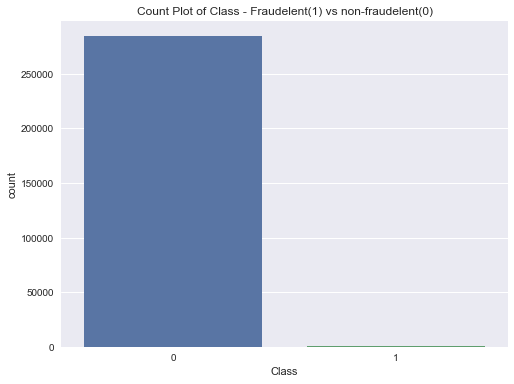

In [3]:
n_frauds = df['Class'].sum()
n_normal = df[df['Class'] == 0].shape[0]
len_df = df.shape[0]

# printing number of fraudelent, non-fraudelent and percentage of fraudelent transactions
print('Total number of frauds are {}'.format(n_frauds))
print('Total number of non fraudelent transactions are {}'.format(n_normal))
print('Percentage of frauds are {}%'.format(round(n_frauds/len_df*100, 4)))


# plotting 
plt.figure(figsize = (8,6))
sns.countplot(df['Class'])
plt.title('Count Plot of Class - Fraudelent(1) vs non-fraudelent(0)')
plt.show()

1. The target variable i.e `Class` is highly imbalanced as the number of frauds is 0.173% of the total transactions and therefore accuracy cannot be used as metric.
2. Various data imbalanced techniques such as oversampling, undersampling and synthetic oversampling techniques such as ADASYN, SMOTE can also be tried
3. Since the data is imbalanced, accuracy cannot be used as evaluation metric.`roc_auc` will be used as evaluation metric as this metric will not depend upon threshold probability

### Understanding the Amount variable

THe min value of Amount is 0.0


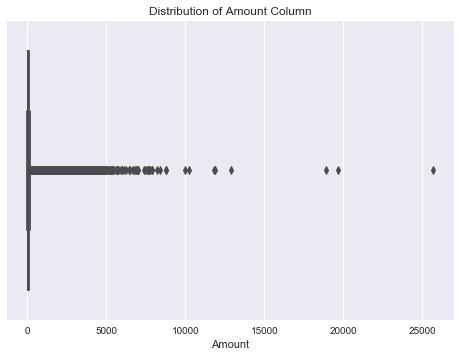

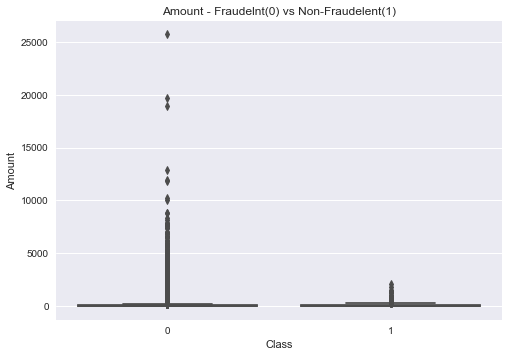

In [4]:
# Understanding the distribution of Amount varible
print('THe min value of Amount is {}'.format(df['Amount'].min()))
sns.boxplot(df['Amount'])
plt.title('Distribution of Amount Column')
plt.show()

sns.boxplot(x = df['Class'], y = df['Amount'])
plt.title('Amount - Fraudelnt(0) vs Non-Fraudelent(1)')
plt.show()

Amount variable is highly imbalanced we need to treat this before applying models. We can try power transforms, log1p etc. since the values are only positives

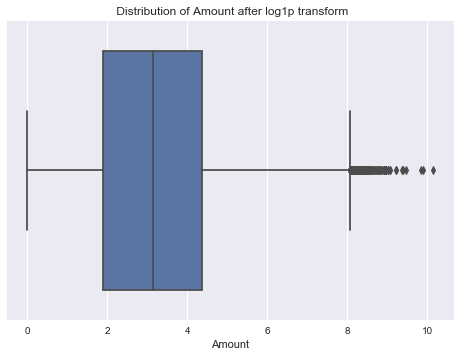

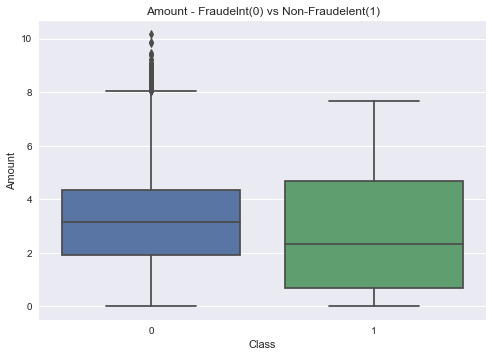

In [5]:
# Trying log1p transform
sns.boxplot(np.log1p(df['Amount']))
plt.title(' Distribution of Amount after log1p transform')
plt.show()

# understanding the distribution of Amount(log1p(transformed)) with Class 
sns.boxplot(x = df['Class'], y = np.log1p(df['Amount']))
plt.title('Amount - Fraudelnt(0) vs Non-Fraudelent(1)')
plt.show()

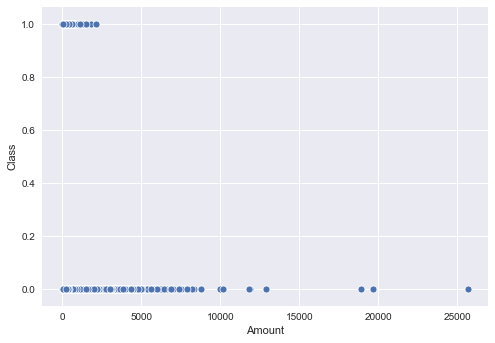

In [6]:
# scatterplot for Amount and Class
sns.scatterplot(x = df['Amount'],y = df['Class'])
plt.show()

Amount might be having some correlation with fraudelent transactions.can be invested further during analysis

### Understanind `Time` Variable

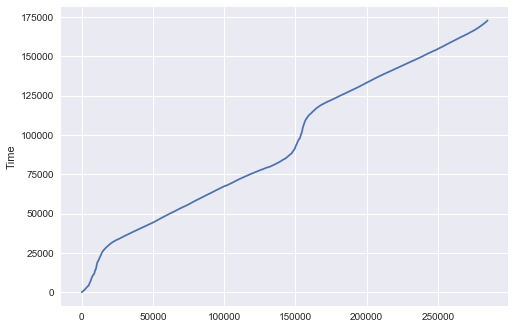

In [7]:
# plotting Time variable with number of transactions
sns.lineplot(x = range(len(df)), y = df['Time'])
plt.show()

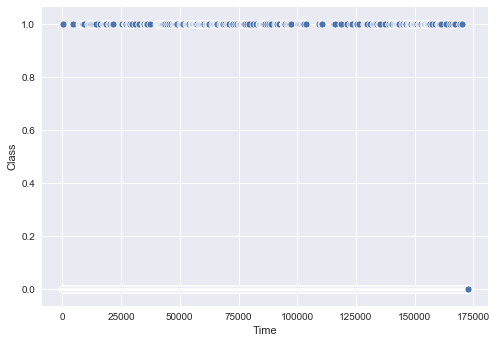

In [8]:
# scatter plot of Time and Class
# style.use('seaborn')
sns.scatterplot( x = df['Time'], y = df['Class'])
plt.show()

In [9]:
df['Time'].max()/(60*60)

47.99777777777778

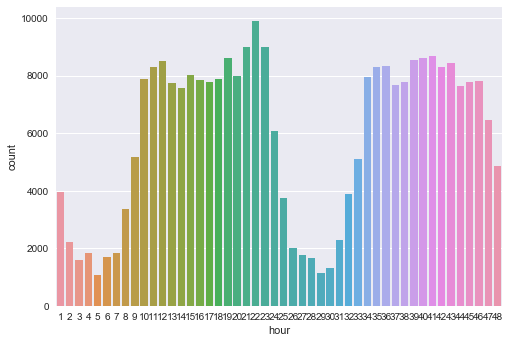

In [10]:
# The data provided is for 48 hours lets create a time variable and assign an hour to it

df['hour'] = df['Time']/3600
df['hour'] =df['hour'].astype('int') + 1

# lets understand the tranactions in each plot for 48 hours
sns.countplot(df['hour'])
plt.show()

The graph clearly indicates a trend for peak hours and non-peak hours and lets create hours for the second day also

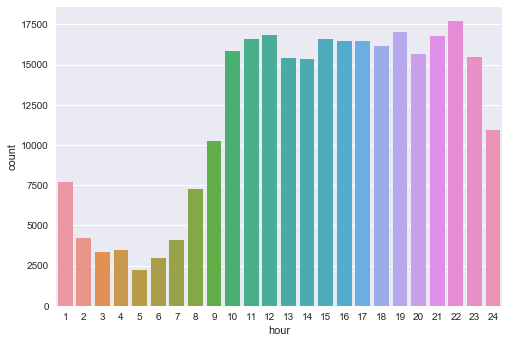

In [11]:
df['hour'] = df['hour'].apply(lambda x: x-24 if x >24 else x)
sns.countplot(df['hour'])
plt.show()

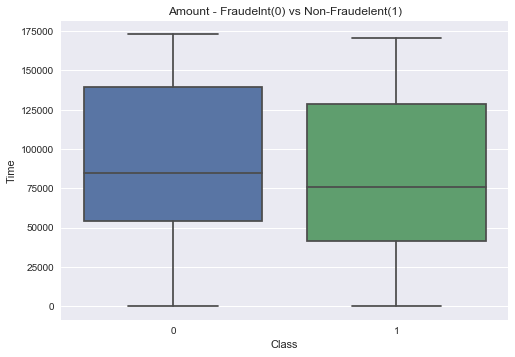

In [12]:
# understanding the distribution of Amount(log1p(transformed)) with Class 
sns.boxplot(x = df['Class'], y = df['Time'])
plt.title('Amount - Fraudelnt(0) vs Non-Fraudelent(1)')
plt.show()

### Splitting the data into train & test data

In [13]:
# creating X and y for splitting train and test data
# dropping time variable
X = df.drop(['Class', 'Time'], axis = 1)
y= df['Class']

In [14]:
# splitting the dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25, random_state = 16, shuffle = True, stratify = y)

In [15]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour
144290,-0.930335,0.991018,0.851134,0.984656,0.647303,2.053373,-0.191295,1.220456,-0.567951,-0.275907,...,0.119792,0.610601,-0.047125,-1.352114,-0.327512,-0.116225,0.350484,0.108056,8.31,24
147839,-1.907027,1.775862,0.072541,-3.020521,0.465357,-1.249426,1.802138,-1.450089,2.036612,4.733087,...,-0.583254,0.177983,-0.122853,-0.072734,-0.212049,-0.660077,0.590761,-0.407196,2.99,1
116654,1.068555,-0.180037,0.159756,-0.100057,-0.135899,0.001097,-0.040655,0.187916,-0.148236,-0.065046,...,-0.396223,-1.335157,0.305148,-0.319796,-0.270228,0.552235,-0.078233,-0.001793,53.99,21
130928,1.175316,-0.652573,1.394370,0.670637,-1.407501,0.526586,-1.239771,0.423979,-0.321673,0.826498,...,-0.351600,-0.383497,0.144630,0.156963,0.130978,-0.387221,0.103822,0.027655,1.00,23
265477,-0.464565,-0.086839,1.366160,-0.274108,0.485827,-0.666155,0.975388,-0.999741,1.716517,0.897225,...,-0.385767,0.021717,0.436603,-0.013660,-1.066230,-0.796849,-0.641220,-0.728961,9.99,21


In [16]:
# break-up of frauds in train and test dataset
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
369
123


### Understanding Distribution of variables and Skew Treatment if required

Distribution of Column V1


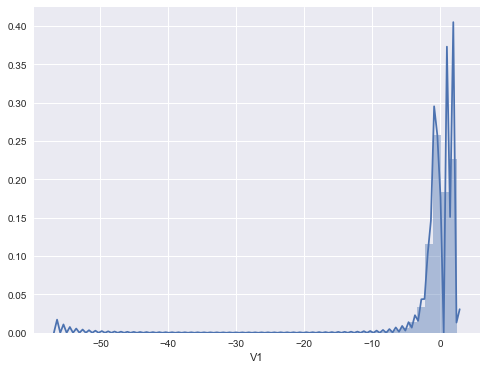

Distribution of Column V2


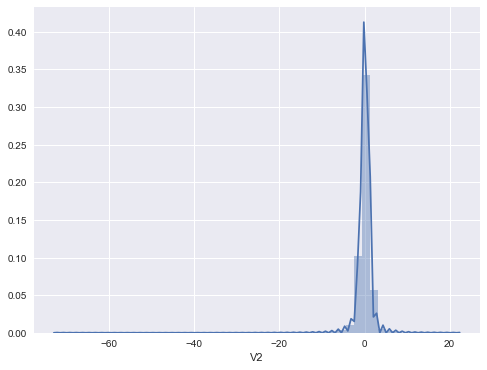

Distribution of Column V3


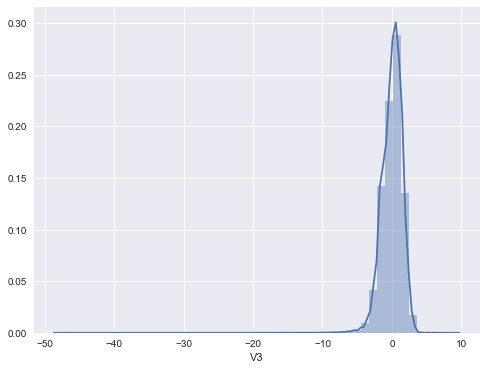

Distribution of Column V4


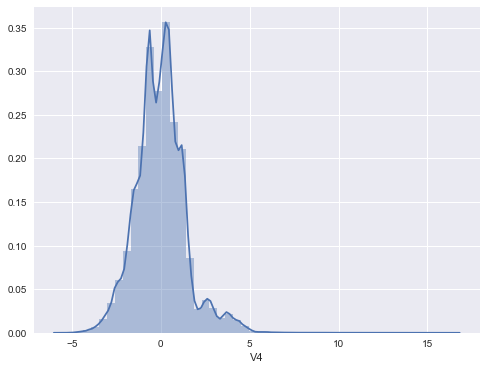

Distribution of Column V5


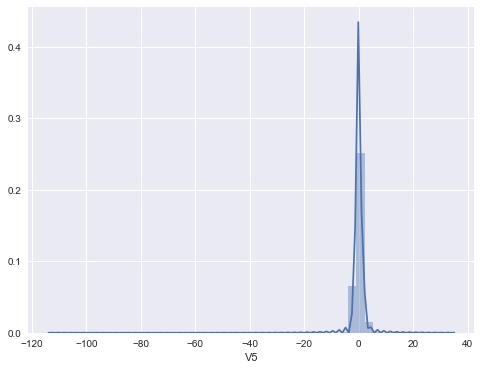

Distribution of Column V6


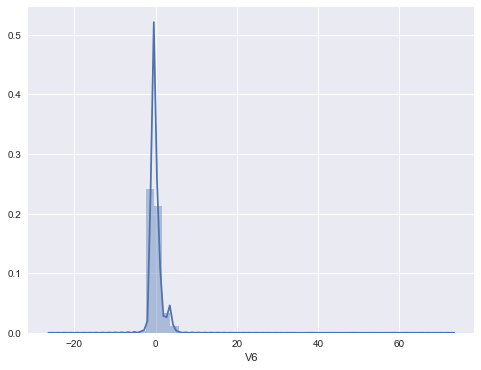

Distribution of Column V7


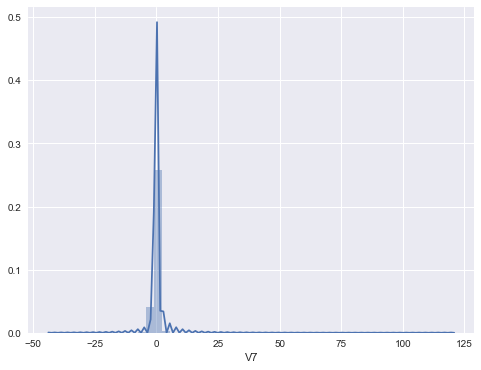

Distribution of Column V8


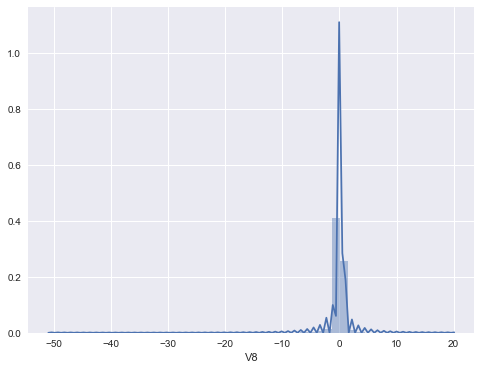

Distribution of Column V9


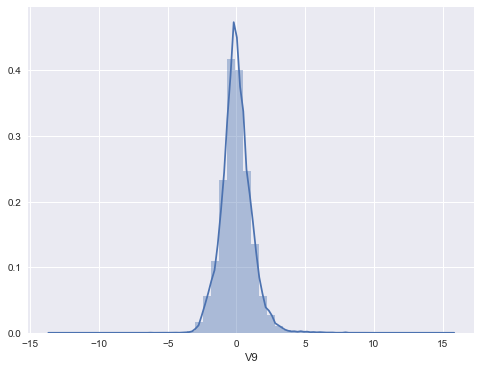

Distribution of Column V10


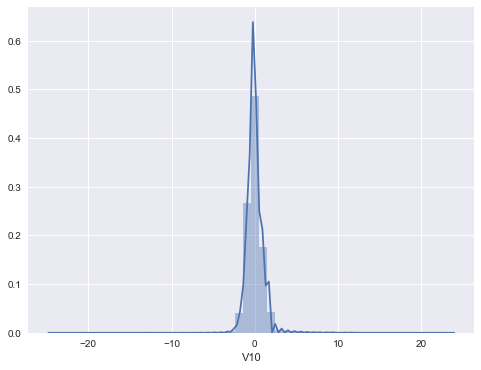

Distribution of Column V11


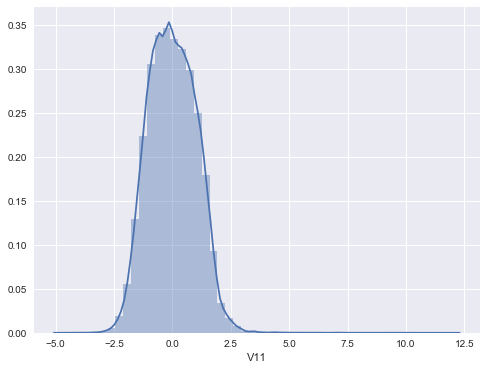

Distribution of Column V12


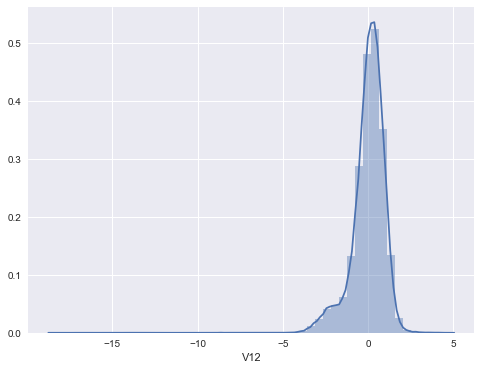

Distribution of Column V13


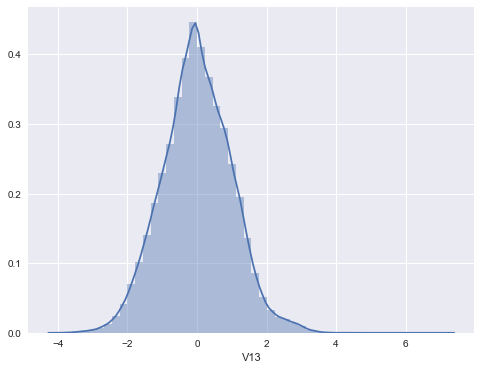

Distribution of Column V14


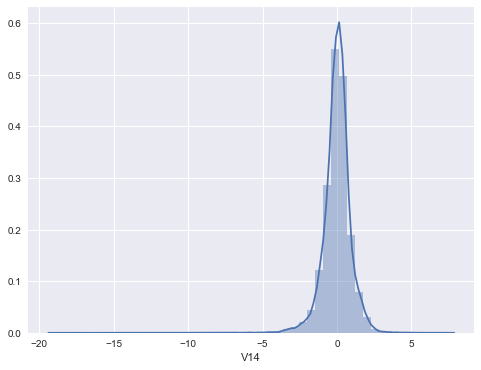

Distribution of Column V15


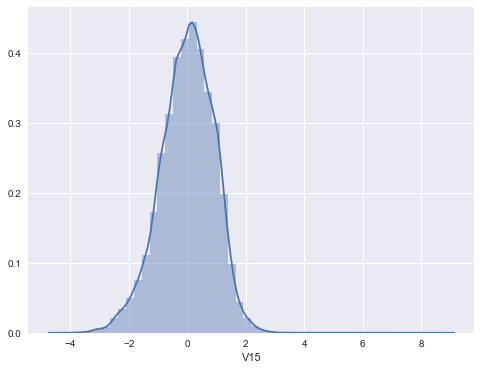

Distribution of Column V16


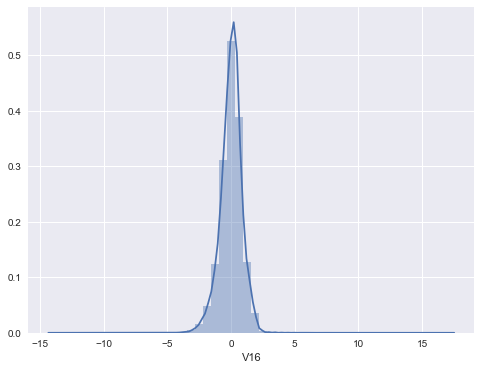

Distribution of Column V17


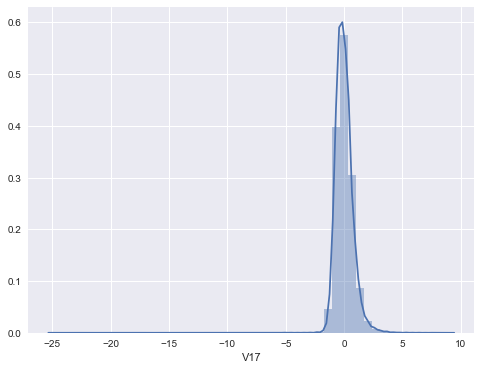

Distribution of Column V18


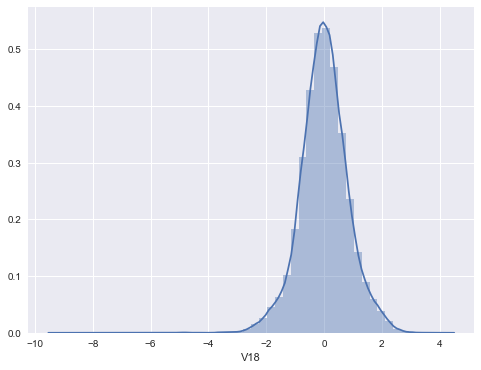

Distribution of Column V19


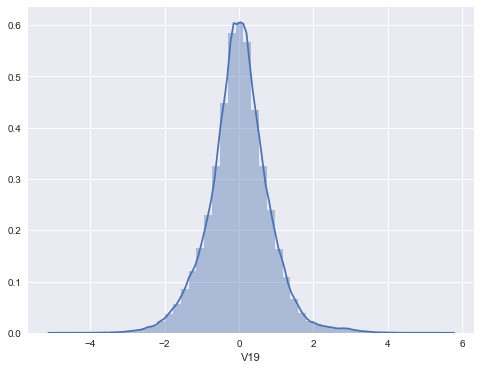

Distribution of Column V20


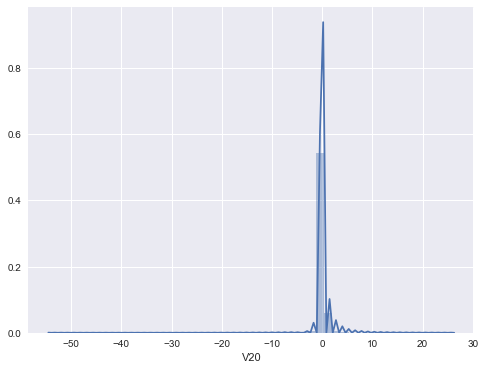

Distribution of Column V21


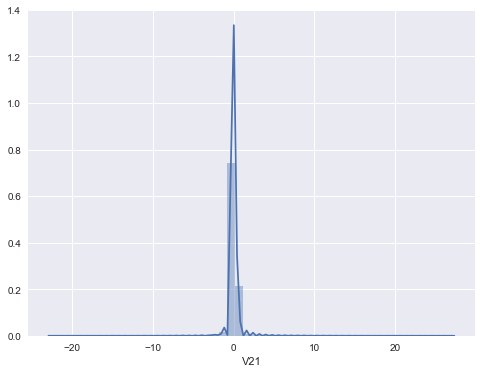

Distribution of Column V22


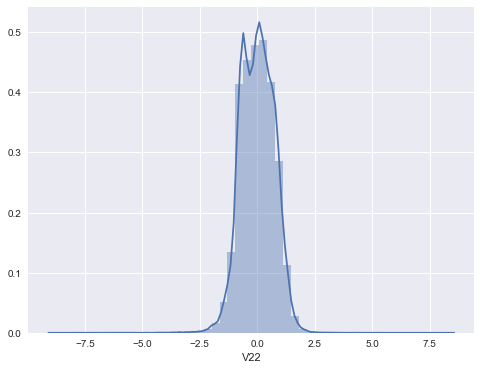

Distribution of Column V23


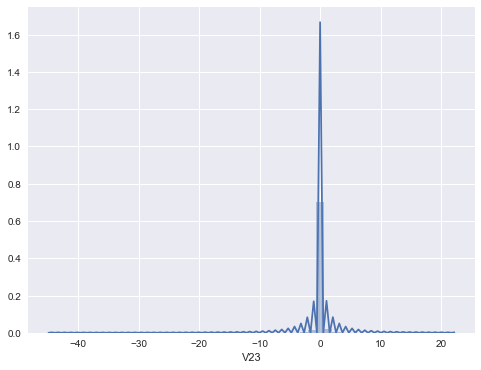

Distribution of Column V24


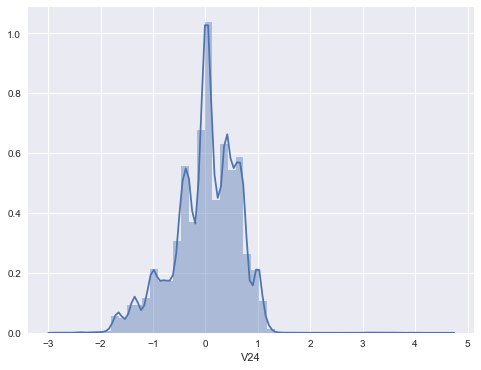

Distribution of Column V25


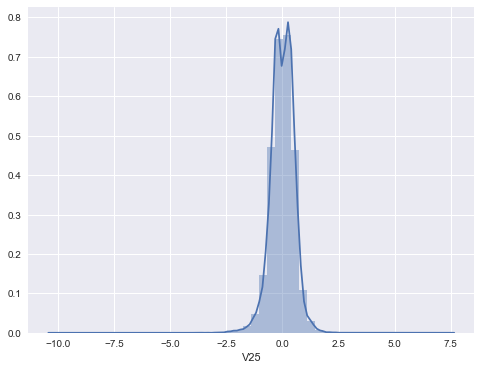

Distribution of Column V26


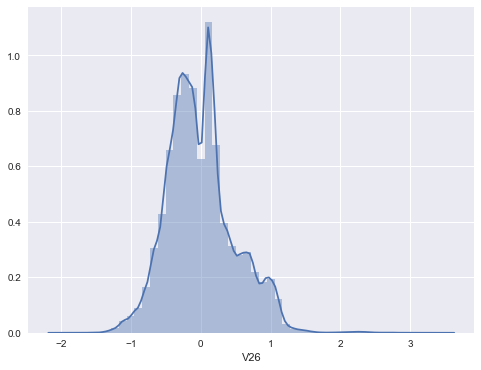

Distribution of Column V27


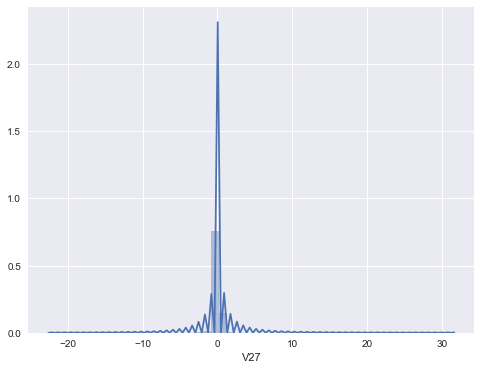

Distribution of Column V28


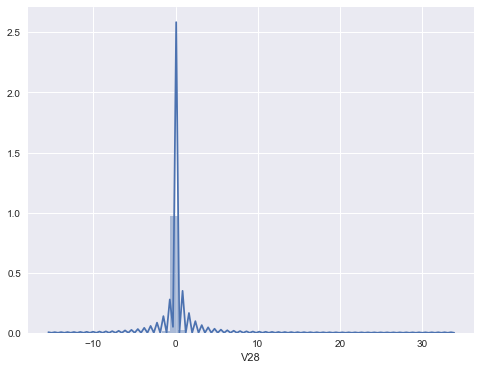

Distribution of Column Amount


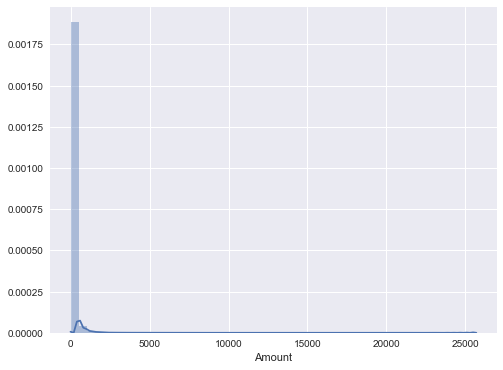

Distribution of Column hour


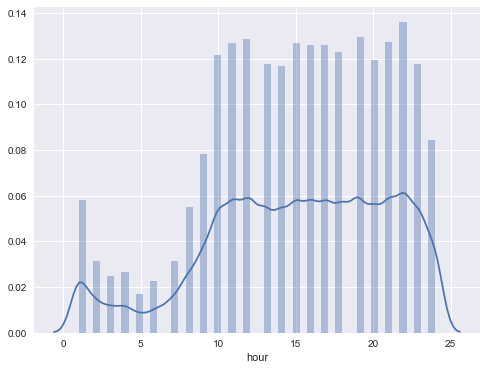

In [17]:
#observe the different feature type present in the data
for col in X_train.columns:
    if col not in ['Class', 'Time']:
        print('Distribution of Column {}'.format(col))
        plt.figure(figsize = (8,6))
        sns.distplot(X_train[col])
        plt.show()

In [18]:
# calculating skew for all features
skew_features = X_train.apply(lambda x: skew(x))
skew_features = skew_features.reset_index().rename(columns= {'index': 'features', 0: 'skew'})

# selecting cols for skew greater than 0.3 for treatment
skew_cols = skew_features[abs(skew_features['skew']) > 0.3]['features'].values

In [19]:
skew_features.sort_values('skew', ascending = False).head()

,features,skew
28,Amount,15.709982
27,V28,11.308818
6,V7,3.777423
20,V21,3.752796
5,V6,2.001003


In [20]:
skew_cols

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V15', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'hour'], dtype=object)

All these columns have higher skew. 

In [21]:
# Treating all columns with power transformer as transforming doesnt affect the dataset
ptrans = PowerTransformer(copy =True)
cols = X_train.columns
X_train_p = X_train.copy(deep = True)
X_train_p[cols] = ptrans.fit_transform(X_train_p[cols])
X_train_p.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour
144290,-0.723780,0.613310,0.517622,0.739763,0.459667,1.465028,-0.151345,1.284917,-0.488017,-0.216176,...,0.183348,0.836775,-0.086843,-1.968506,-0.653147,-0.157048,0.864830,0.339115,-0.532466,1.653742
147839,-1.105364,1.225383,-0.104086,-2.445851,0.325653,-1.021639,1.445709,-1.299012,1.741381,3.819891,...,-0.811427,0.225386,-0.206789,-0.218002,-0.440833,-1.502586,1.476434,-1.259007,-1.076965,-2.130839
116654,0.522873,-0.199592,-0.040383,0.006551,-0.112195,0.111523,-0.029745,0.110101,-0.084073,-0.014548,...,-0.541337,-1.798652,0.481067,-0.604965,-0.548270,1.138802,-0.202646,0.005669,0.543462,1.054613
130928,0.614502,-0.484597,1.011104,0.537177,-1.014114,0.502397,-1.001828,0.359253,-0.248588,0.783192,...,-0.477420,-0.543918,0.220342,0.175618,0.214558,-0.795461,0.246481,0.095460,-1.536467,1.451561
265477,-0.508352,-0.140718,0.984444,-0.122148,0.340700,-0.461649,0.785913,-0.951089,1.492554,0.843616,...,-0.526342,0.008345,0.696738,-0.120177,-1.941033,-1.879470,-1.555615,-2.294597,-0.428274,1.054613


Distribution of Column V1


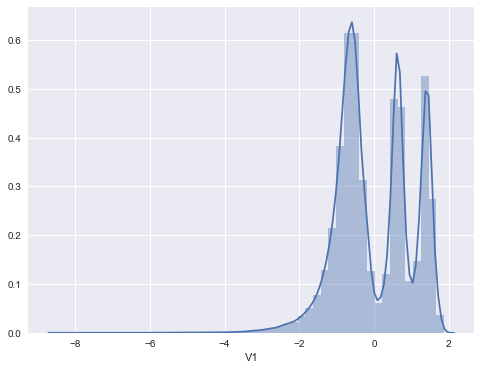

Distribution of Column V2


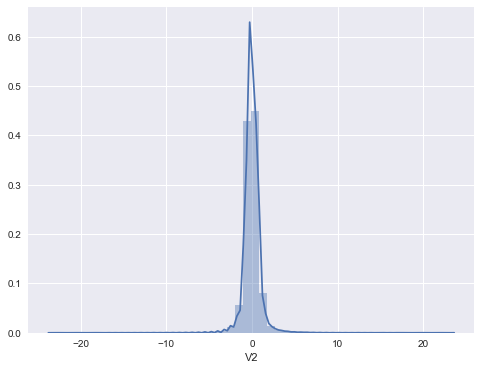

Distribution of Column V3


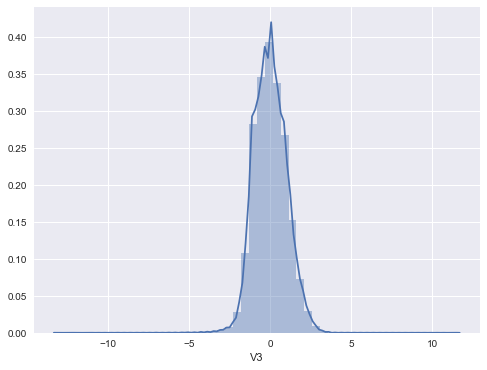

Distribution of Column V4


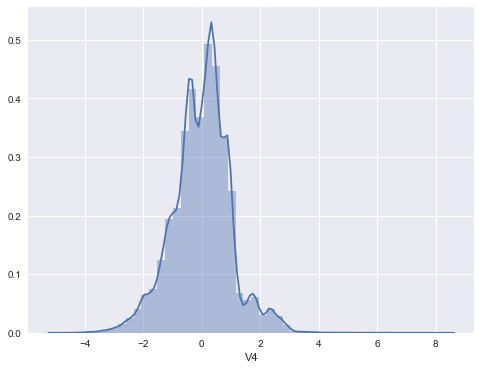

Distribution of Column V5


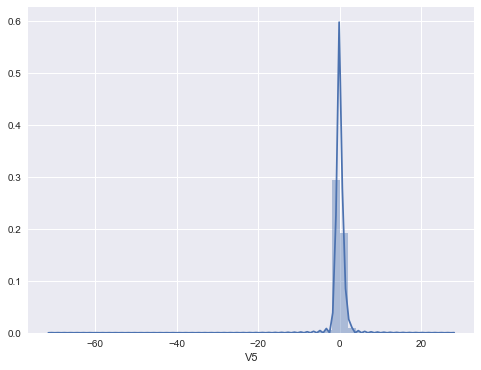

Distribution of Column V6


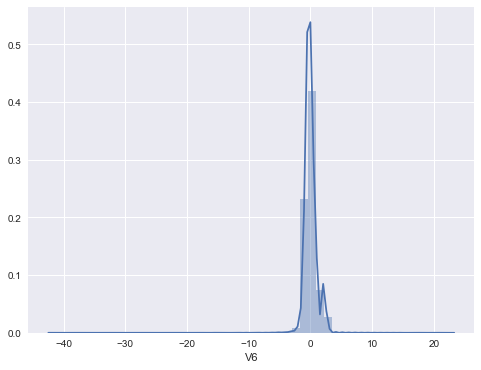

Distribution of Column V7


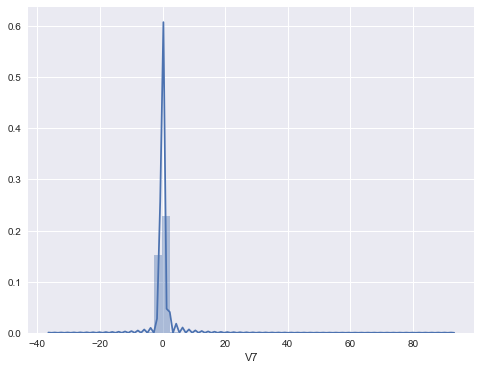

Distribution of Column V8


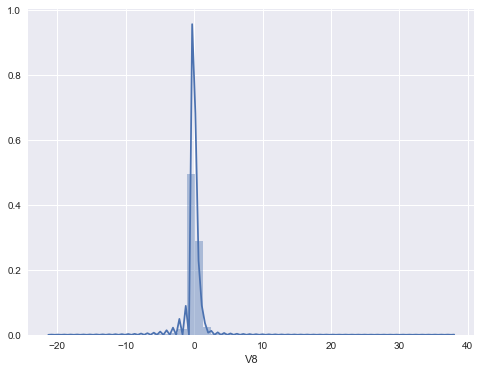

Distribution of Column V9


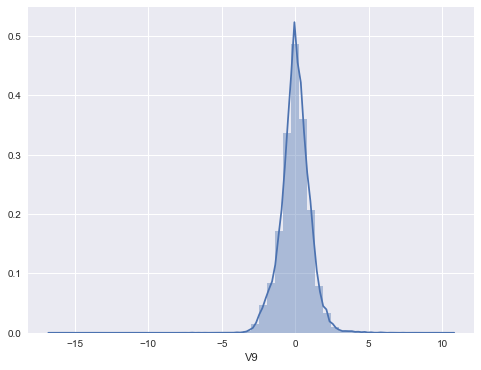

Distribution of Column V10


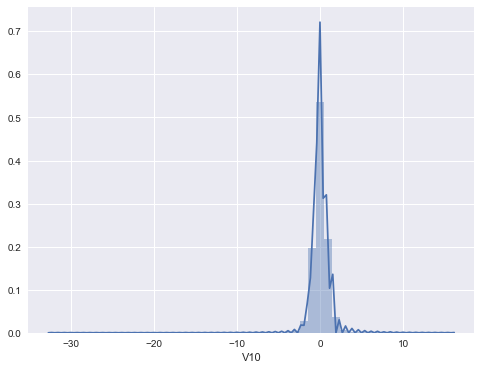

Distribution of Column V11


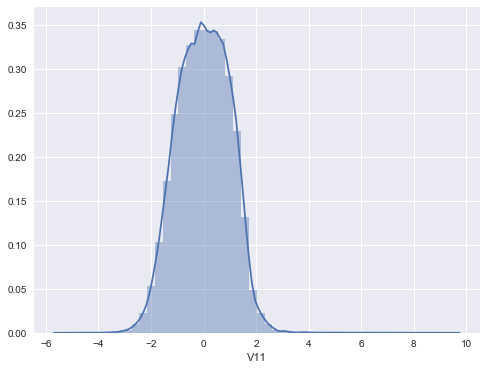

Distribution of Column V12


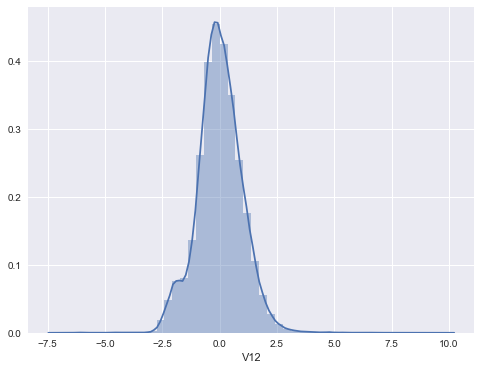

Distribution of Column V13


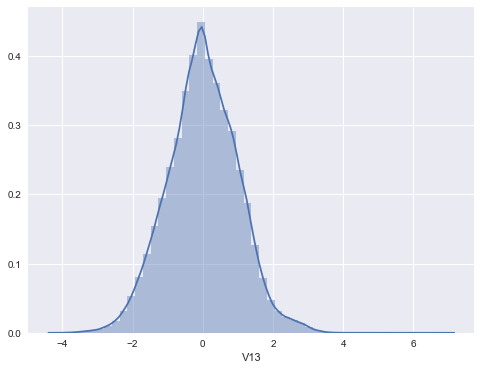

Distribution of Column V14


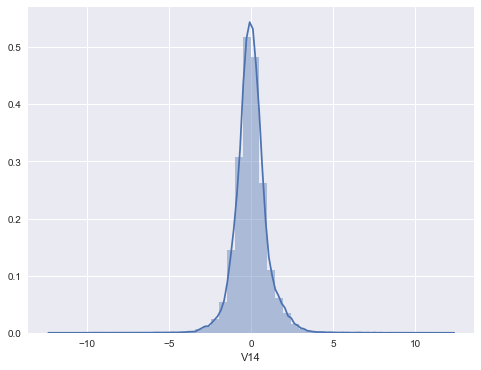

Distribution of Column V15


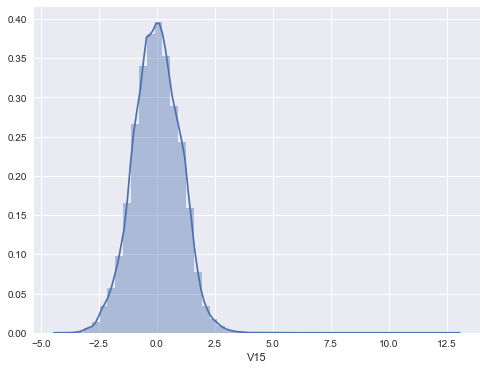

Distribution of Column V16


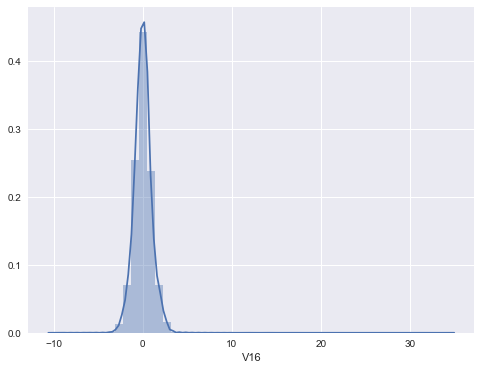

Distribution of Column V17


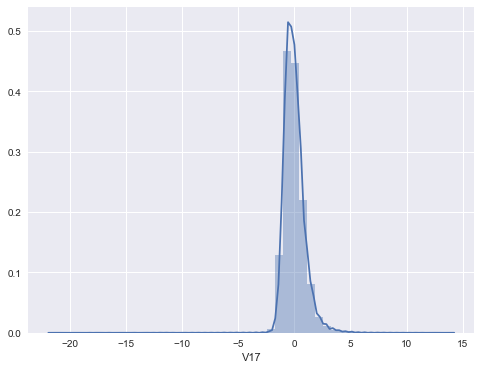

Distribution of Column V18


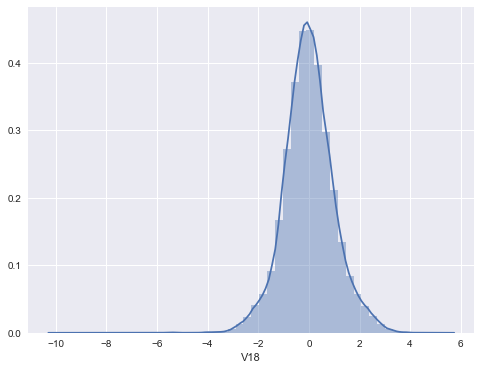

Distribution of Column V19


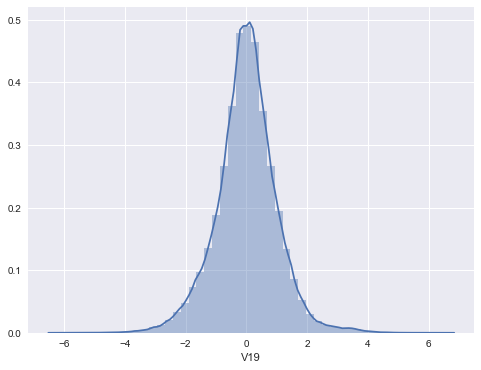

Distribution of Column V20


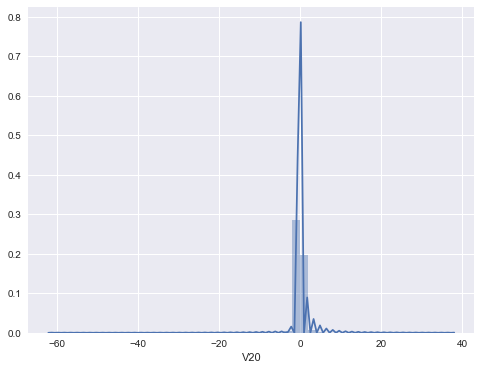

Distribution of Column V21


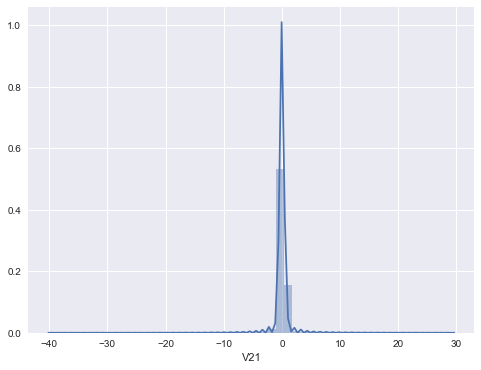

Distribution of Column V22


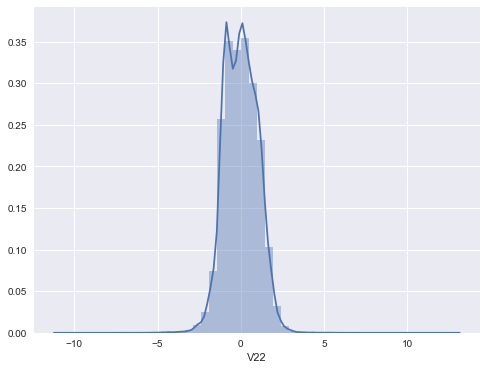

Distribution of Column V23


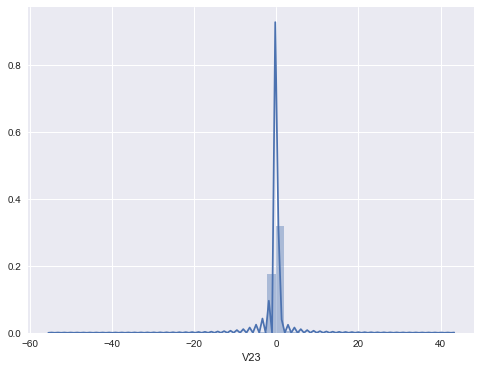

Distribution of Column V24


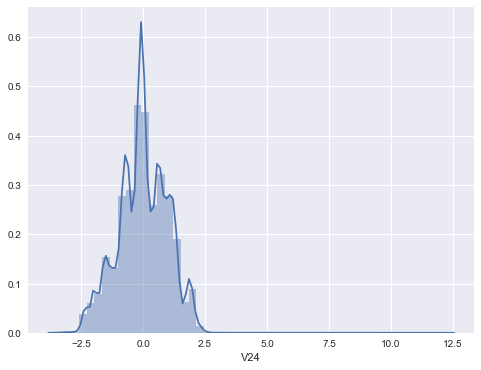

Distribution of Column V25


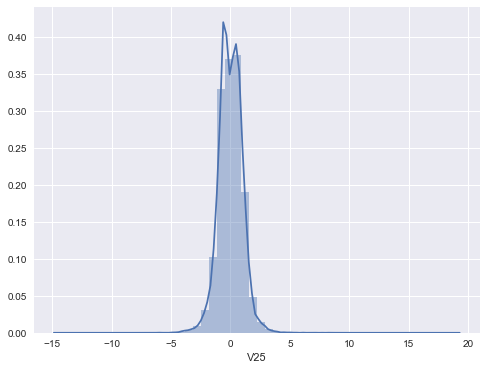

Distribution of Column V26


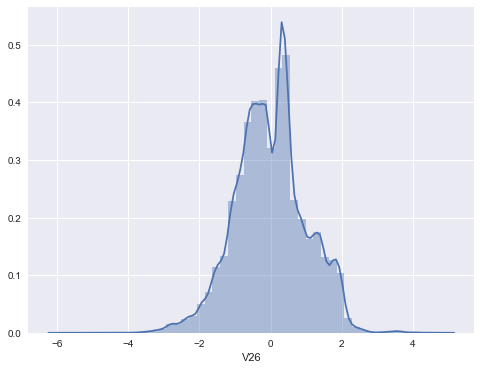

Distribution of Column V27


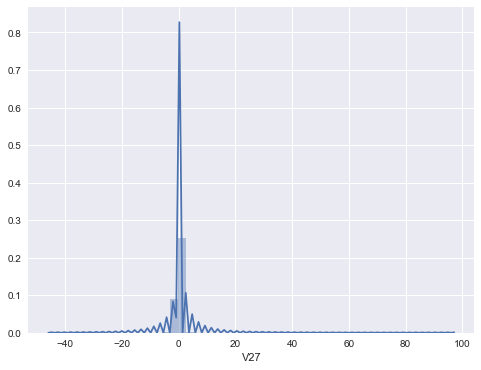

Distribution of Column V28


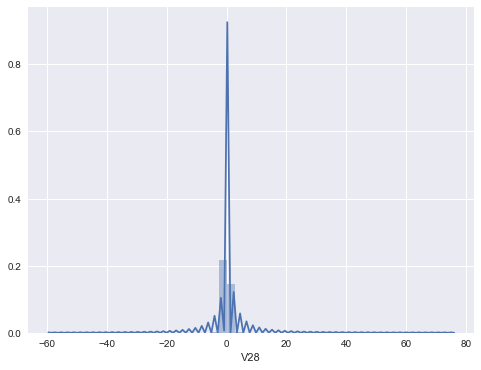

Distribution of Column Amount


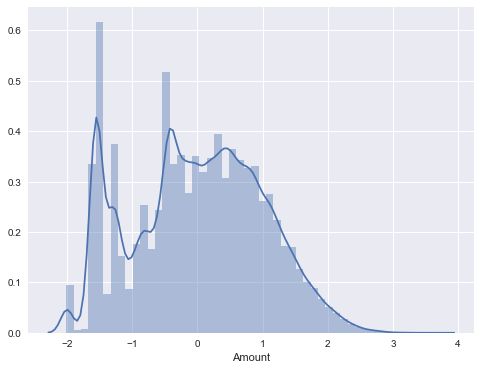

Distribution of Column hour


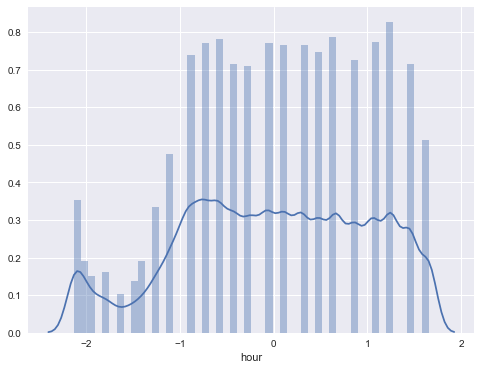

In [22]:
#observe the different feature type present in the data

for col in X_train_p.columns:
    if col not in ['Class', 'Time']:
        print('Distribution of Column {}'.format(col))
        plt.figure(figsize = (8,6))
        sns.distplot(X_train_p[col])
        plt.show()

In [23]:
# understaniding the skewness of all variables

rev_skew_features = X_train_p.apply(lambda x: skew(x))
rev_skew_features = rev_skew_features.reset_index().rename(columns= {'index': 'features', 0: 'skew'})

# skew_cols = skew_features[abs(skew_features['skew']) > 0.3]['features'].values
rev_skew_features.sort_values('skew', ascending = False).head()

,features,skew
26,V27,3.538002
6,V7,2.843959
7,V8,2.298796
27,V28,1.258154
1,V2,0.331859


We can see that skewness of variables such as `Ammount` signifcantly reduced

In [24]:
# transforming test data
X_test_p = X_test.copy(deep = True)
X_test_p[cols] = ptrans.transform(X_test_p[cols])

### Model Building with normal dataset (used sample_weight = 'balanced'  for performance boost)
- Build different models on the imbalanced dataset and see the result

In [25]:
# creating kfolds
kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 16)

# creating function for crossvalidation score

def crossvalidation_results(model, X_train, y_train):
    """Returns cross validation scores, mean and standard deviation"""
    cv_score = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = kfolds, n_jobs= -1)
    return cv_score, cv_score.mean(), cv_score.std()

# creating a function for prediction on train and test dataset and estimates various evaluation metrics
def results_auc(model, X_train, y_train,test = False):
    """Returns the Confusion Matrix and Classification Report for the dataset"""
    cols = X_train.columns
    if test == False:

        y_train_pred = model.predict(X_train[cols])
        train_auc = roc_auc_score(y_train, model.predict_proba(X_train[cols])[:,1])
        print('\n--------- Train Results ---------')
        print('\nTrain auc is {}'.format(round(train_auc,4)))
        print('\n--------- confusion matrix ---------')
        print(confusion_matrix(y_train, y_train_pred))
        print('\n--------- classification report ---------')
        print(classification_report(y_train, y_train_pred))

    if test == True:
        y_test_pred = model.predict(X_train[cols])
        test_auc = roc_auc_score(y_train, model.predict_proba(X_train[cols])[:,1])
        print('\n--------- Test Results ---------')
        print('\nTest auc is {}'.format(round(test_auc, 4)))
        print('\n--------- confusion matrix ---------')
        print(confusion_matrix(y_train, y_test_pred))
        print('\n--------- classification report ---------')
        print(classification_report(y_train, y_test_pred))
        
        
def repeated_crossvalidation(model, X, y, njobs = -1):
    """Gives the results of repeated crossvalidation """
    rfolds = RepeatedStratifiedKFold(n_splits =5, n_repeats = 10, random_state = 10)
    cv_score = cross_val_score(model, X, y, cv = rfolds, n_jobs = njobs, scoring = 'roc_auc')
    print(cv_score.mean(),cv_score.std())
    return cv_score


def grid_search(estimator, params, X, y, ncv = kfolds, score = 'roc_auc', njobs = -1):
    """Grid search function returning the best params and cv_results"""
    model = GridSearchCV(estimator, cv=ncv, param_grid=params, scoring=score, n_jobs = njobs,
                    return_train_score= True, verbose = 2)
    model.fit(X, y)
    cv_results = pd.DataFrame(model.cv_results_)
    best_params = model.best_params_
    return cv_results, best_params

In [26]:
# create a dataframe for tracking the cv_score, test_score and repeatedcv_score
models_score = pd.DataFrame({'Model':[], 'Description':[], 'train_score': [],
                            'cv_score': [], 'test_score': [], 'repeated_cv_score': []})
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score


#### Logistic Regression

In [27]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour
144290,-0.930335,0.991018,0.851134,0.984656,0.647303,2.053373,-0.191295,1.220456,-0.567951,-0.275907,...,0.119792,0.610601,-0.047125,-1.352114,-0.327512,-0.116225,0.350484,0.108056,8.31,24
147839,-1.907027,1.775862,0.072541,-3.020521,0.465357,-1.249426,1.802138,-1.450089,2.036612,4.733087,...,-0.583254,0.177983,-0.122853,-0.072734,-0.212049,-0.660077,0.590761,-0.407196,2.99,1
116654,1.068555,-0.180037,0.159756,-0.100057,-0.135899,0.001097,-0.040655,0.187916,-0.148236,-0.065046,...,-0.396223,-1.335157,0.305148,-0.319796,-0.270228,0.552235,-0.078233,-0.001793,53.99,21
130928,1.175316,-0.652573,1.394370,0.670637,-1.407501,0.526586,-1.239771,0.423979,-0.321673,0.826498,...,-0.351600,-0.383497,0.144630,0.156963,0.130978,-0.387221,0.103822,0.027655,1.00,23
265477,-0.464565,-0.086839,1.366160,-0.274108,0.485827,-0.666155,0.975388,-0.999741,1.716517,0.897225,...,-0.385767,0.021717,0.436603,-0.013660,-1.066230,-0.796849,-0.641220,-0.728961,9.99,21


In [82]:
# lets create a base model which would be used as base model
## creating a model pipeline for transformation and fitting the model

ptrans = PowerTransformer(copy=True)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, )
steps = [('ptrans', ptrans), ('lr', lr_model)]
lr_pipeline = Pipeline(steps)

crossvalidation_results(lr_pipeline, X_train, y_train)

(array([0.97887485, 0.97453324, 0.97785434, 0.9947349 , 0.97148084]),
 0.9794956343721328,
 0.008052042435821912)

In [33]:
%%time
# tuning hyperparmaters for l1 and l2 penatlies
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['l1', 'l2'], 
         'lr__solver': ['liblinear', 'lbfgs','saga'], 'lr__class_weight' :[None, 'balanced']}

cv_results, best_params = grid_search(lr_pipeline, param_grid, X_train, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.6min finished


{'lr__C': 0.1, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
Wall time: 10min 56s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__penalty,param_lr__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
26,34.535502,0.716838,0.172079,0.016980,0.1,None,l1,saga,"{'lr__C': 0.1, 'lr__class_weight': None, 'lr__...",0.982466,...,0.982343,0.009419,1,0.985620,0.985137,0.983094,0.983714,0.987026,0.984918,0.001397
38,35.785998,0.386727,0.133459,0.011668,0.2,None,l1,saga,"{'lr__C': 0.2, 'lr__class_weight': None, 'lr__...",0.982159,...,0.982112,0.009271,2,0.986546,0.985729,0.983771,0.983711,0.986730,0.985297,0.001315


In [35]:
%%time
# tuning hyperparmaters for elasticnet penalty
# elasticpenalty is only supported by saga solver
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['elasticnet'], 
         'lr__solver': ['saga'], 'lr__class_weight' :[None, 'balanced'], 'lr__l1_ratio':[i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lr_pipeline, param_grid, X_train, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 26.1min finished


{'lr__C': 0.01, 'lr__class_weight': None, 'lr__l1_ratio': 0.1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
Wall time: 26min 25s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__l1_ratio,param_lr__penalty,param_lr__solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,30.848975,0.077919,0.147809,0.016992,0.01,None,0.1,elasticnet,saga,"{'lr__C': 0.01, 'lr__class_weight': None, 'lr_...",...,0.982378,0.009174,1,0.985198,0.984764,0.982726,0.983412,0.987265,0.984673,0.001574
25,30.427302,0.469006,0.132294,0.029935,0.05,None,0.6,elasticnet,saga,"{'lr__C': 0.05, 'lr__class_weight': None, 'lr_...",...,0.982366,0.009455,2,0.984970,0.984610,0.982587,0.983485,0.987061,0.984543,0.001515


In [279]:
# final model on logistic regression after hyper parameter tuning

ptrans = PowerTransformer(copy=True)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, solver ='saga', 
                              penalty = 'elasticnet',C = 0.01, l1_ratio = 0.1, max_iter = 5000)
steps = [('ptrans', ptrans), ('lr', lr_model)]
lr_pipeline_final = Pipeline(steps)

# fitting on training data
lr_pipeline_final.fit(X_train, y_train)

# results on training and test data
results_auc(lr_pipeline_final, X_train, y_train, test = False)
results_auc(lr_pipeline_final, X_test, y_test,test = True)


--------- Train Results ---------

Train auc is 0.985

--------- confusion matrix ---------
[[213208     28]
 [   147    222]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.89      0.60      0.72       369

    accuracy                           1.00    213605
   macro avg       0.94      0.80      0.86    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9736

--------- confusion matrix ---------
[[71071     8]
 [   45    78]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.63      0.75       123

    accuracy                           1.00     71202
   macro avg       0.95      0.82      0.87     71202
weighted avg       1.00      1.00      1.00     71202



In [281]:
%%time
# repeated crossvalidation on the train data
repeated_crossvalidation(lr_pipeline_final, X_train, y_train)

0.9822068163747896 0.010829375875033765
Wall time: 4min 26s


array([0.96725472, 0.99246264, 0.99222213, 0.98369804, 0.97833155,
       0.97211355, 0.98380482, 0.96968641, 0.9911977 , 0.99346394,
       0.99384834, 0.98333966, 0.97224005, 0.96794299, 0.99270187,
       0.99645842, 0.96603671, 0.990422  , 0.97595503, 0.98312451,
       0.98138023, 0.97158984, 0.97644903, 0.98908038, 0.99207891,
       0.97462792, 0.9875518 , 0.99283464, 0.97819561, 0.97924983,
       0.97127071, 0.98063201, 0.99243317, 0.97722472, 0.98796912,
       0.97218518, 0.99465791, 0.99163783, 0.95819959, 0.99150601,
       0.95757305, 0.98498833, 0.99019734, 0.9828745 , 0.9939909 ,
       0.99524781, 0.97335163, 0.99718905, 0.99114605, 0.95672266])

In [29]:
models_score.loc[0,:] = ['Logistic Regression', 'No sampling', 0.9850, 0.9824, 0.9736, 0.9822]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.985,0.9824,0.9736,0.9822


#### Random Forest

In [40]:
# building a base model for reference
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1)

crossvalidation_results(rf_model, X_train_p, y_train)

(array([0.92967439, 0.93086282, 0.94459513, 0.9718869 , 0.93753402]),
 0.9429106548174377,
 0.015438378357014485)

hyperparameters tuning for random forest

In [41]:
%%time
# tuning n_estimators, class_weight and max_depth
param_grid = {'n_estimators': [100, 300, 500, 600, 800], 'class_weight' : [None, 'balanced'],
             'max_depth': range(2,14,2)}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 54.9min finished


{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 600}
Wall time: 55min 19s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
53,319.542035,14.043997,31.817934,6.503178,balanced,10,600,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.978450,0.985484,...,0.984671,0.003448,1,0.999966,0.999963,0.999963,0.999965,0.999966,0.999964,0.000002
52,286.439472,9.273276,21.272541,4.826622,balanced,10,500,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977986,0.986278,...,0.984516,0.003464,2,0.999966,0.999962,0.999962,0.999965,0.999966,0.999964,0.000002


In [43]:
%%time
# Further tuning n_estimators based on previous results
param_grid = {'n_estimators': range(300, 800,50), 'class_weight' : ['balanced'],
             'max_depth': [9,10,11]}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 37.1min finished


{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 450}
Wall time: 37min 26s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,229.201587,29.472628,27.773840,4.686598,balanced,10,450,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977711,0.986317,...,0.984828,0.003683,1,0.999966,0.999963,0.999962,0.999965,0.999966,0.999965,0.000002
16,340.150309,17.674909,34.427797,10.169123,balanced,10,600,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.978450,0.985484,...,0.984671,0.003448,2,0.999966,0.999963,0.999963,0.999965,0.999966,0.999964,0.000002


In [44]:
%%time
# Further tuning n_estimators and max_depth based on previous results
param_grid = {'n_estimators': range(400, 500,10), 'class_weight' : ['balanced'],
             'max_depth': [10]}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.5min finished


{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 450}
Wall time: 10min 50s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,203.207681,11.092487,19.809772,2.488036,balanced,10,450,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977711,0.986317,...,0.984828,0.003683,1,0.999966,0.999963,0.999962,0.999965,0.999966,0.999965,0.000002
6,228.198386,5.552861,13.341376,8.822962,balanced,10,460,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977596,0.986351,...,0.984691,0.003704,2,0.999966,0.999963,0.999962,0.999965,0.999966,0.999964,0.000002


In [47]:
%%time
# tuning max_features 
param_grid = {'n_estimators': [450], 'class_weight' : ['balanced'],
             'max_depth': [10], 'max_features': ['auto',0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1]}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 25.6min finished


{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 450}
Wall time: 25min 53s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,264.717660,6.388374,46.322049,0.903865,balanced,10,auto,450,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977711,...,0.984828,0.003683,1,0.999966,0.999963,0.999962,0.999965,0.999966,0.999965,0.000002
1,482.656734,9.582532,44.242472,0.744490,balanced,10,0.3,450,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.977019,...,0.983945,0.005051,2,0.999959,0.999954,0.999952,0.999957,0.999956,0.999956,0.000002


In [49]:
%%time
# tuning min_samples_split and min_samples_leaf
param_grid = {'n_estimators': [450], 'class_weight' : ['balanced'],
             'max_depth': [10], 'max_features': ['auto'], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1,5,10]}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed: 12.3min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.8min finished


{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 450}
Wall time: 13min 9s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,259.030034,44.587001,19.522152,8.780022,balanced,10,auto,1,10,450,...,0.985128,0.003409,1,0.999963,0.999958,0.999959,0.999960,0.999961,0.999960,0.000001
7,306.015365,7.260754,42.016634,7.054055,balanced,10,auto,5,20,450,...,0.984935,0.002395,2,0.999951,0.999949,0.999955,0.999949,0.999951,0.999951,0.000002


In [50]:
%%time
# further tuning min_samples_split and min_samples_leaf based on previous results 
param_grid = {'n_estimators': [450], 'class_weight' : ['balanced'],
             'max_depth': [10], 'max_features': ['auto'], 'min_samples_split': [10,15,20], 'min_samples_leaf': [1,5]}

cv_results, best_params = grid_search(rf_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  5.7min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.0min finished


{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 450}
Wall time: 7min 19s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,298.180538,7.384671,2.293970,1.943089,balanced,10,auto,1,15,450,...,0.986238,0.003872,1,0.999959,0.999953,0.999954,0.999955,0.999956,0.999956,0.000002
4,217.327144,73.515680,6.074504,3.358877,balanced,10,auto,5,15,450,...,0.985403,0.003270,2,0.999959,0.999956,0.999961,0.999956,0.999960,0.999958,0.000002


In [283]:
# final model on Random Forest model after hyperparameter tuning
rf_model = RandomForestClassifier(n_estimators= 450, min_samples_split=15, min_samples_leaf=1,
                                  max_depth = 10, max_features= 'auto', random_state=16, n_jobs = -1)

# fitting on the train data
rf_model.fit(X_train_p, y_train)

# results on training and test data
results_auc(rf_model, X_train_p, y_train, test = False)
results_auc(rf_model, X_test_p, y_test,test = True)


--------- Train Results ---------

Train auc is 0.9998

--------- confusion matrix ---------
[[213229      7]
 [    68    301]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.98      0.82      0.89       369

    accuracy                           1.00    213605
   macro avg       0.99      0.91      0.94    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9751

--------- confusion matrix ---------
[[71068    11]
 [   29    94]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.76      0.82       123

    accuracy                           1.00     71202
   macro avg       0.95      0.88      0.91     71202
weighted avg       1.00      1.00      1.00     71202



In [88]:
%%time

# repeated crossvalidation on train data
repeated_crossvalidation(rf_model, X_train_p, y_train)

0.975146246890155 0.011663402864657797
Wall time: 13min 23s


array([0.96673245, 0.9886526 , 0.97504878, 0.97333452, 0.97245046,
       0.97200338, 0.9618382 , 0.98173092, 0.98082942, 0.97785909,
       0.98688724, 0.95619856, 0.95489623, 0.97523637, 0.99616684,
       0.99300133, 0.97501171, 0.97029353, 0.97488306, 0.9663916 ,
       0.9667029 , 0.97384975, 0.96680765, 0.98839119, 0.98687148,
       0.95343629, 0.97106479, 0.98662337, 0.9894245 , 0.97978629,
       0.98218035, 0.95980421, 0.98214063, 0.97353035, 0.97535995,
       0.96087693, 0.98315144, 0.98556978, 0.96030328, 0.98177148,
       0.95291979, 0.97688535, 0.98687782, 0.96903651, 0.99404255,
       0.98521442, 0.94797454, 0.98710058, 0.98535368, 0.96481423])

In [30]:
models_score.loc[1,:] = ['Random Forest', 'No sampling', 0.9998, 0.9862, 0.9751, 0.9751]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751


#### lightgbm

In [285]:
# creating a lightgbm model for reference
# fixing the learning rate at a low value of 0.02
lgb_model= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16, learning_rate= 0.02)
crossvalidation_results(lgb_model, X_train_p, y_train)

(array([0.94504472, 0.9800203 , 0.9649489 , 0.96596541, 0.98536604]),
 0.9682690733807944,
 0.014043493723557997)

In [286]:
### Tuning n_estimators
param_grid = { 'n_estimators' : range(100, 500,10)}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


{'n_estimators': 390}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
29,23.040999,0.481421,1.207321,0.014338,390,{'n_estimators': 390},0.976616,0.987848,0.982297,0.988739,...,0.983975,0.004355,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
28,24.047040,0.388702,1.161432,0.019431,380,{'n_estimators': 380},0.975402,0.988315,0.981607,0.989162,...,0.983796,0.004999,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [219]:
%%time
# tuning num_leaves and min_child_samples
param_grid = {'n_estimators': [390], 'num_leaves' : range(11,160,10), 'min_child_samples': range(10, 100,10)}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 18.5min finished


{'min_child_samples': 30, 'n_estimators': 390, 'num_leaves': 31}
Wall time: 18min 33s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
32,20.910396,0.176634,1.208065,0.022671,30,390,31,"{'min_child_samples': 30, 'n_estimators': 390,...",0.980685,0.985965,...,0.985738,0.002591,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
121,18.683095,0.092384,1.300896,0.050524,90,390,21,"{'min_child_samples': 90, 'n_estimators': 390,...",0.982479,0.989088,...,0.985172,0.003279,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [221]:
%%time
# further tuning num_leaves and min_child_samples based on the previous results
param_grid = {'n_estimators': [390], 'num_leaves' : range(10, 41, 1), 'min_child_samples': range(20, 220,20)}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 310 candidates, totalling 1550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1550 out of 1550 | elapsed: 28.4min finished


{'min_child_samples': 40, 'n_estimators': 390, 'num_leaves': 32}
Wall time: 28min 26s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
53,23.453809,0.319727,1.253106,0.012502,40,390,32,"{'min_child_samples': 40, 'n_estimators': 390,...",0.982897,0.989498,...,0.986377,0.002259,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
292,18.454178,0.343032,1.392963,0.045949,200,390,23,"{'min_child_samples': 200, 'n_estimators': 390...",0.981683,0.990151,...,0.985901,0.004367,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [222]:
%%time
# further tuning num_leaves and min_child_samples based on previous results
param_grid = {'n_estimators': [390], 'num_leaves' : [32], 'min_child_samples': range(20, 61,1)}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 41 candidates, totalling 205 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:  4.8min finished


{'min_child_samples': 40, 'n_estimators': 390, 'num_leaves': 32}
Wall time: 4min 49s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
20,26.520053,0.262977,1.260273,0.028576,40,390,32,"{'min_child_samples': 40, 'n_estimators': 390,...",0.982897,0.989498,...,0.986377,0.002259,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,27.098244,0.511232,1.251777,0.043473,29,390,32,"{'min_child_samples': 29, 'n_estimators': 390,...",0.982008,0.989517,...,0.985843,0.002489,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [223]:
%%time
# tuning min_child_weight
param_grid = {'n_estimators': [390], 'num_leaves' : [32], 'min_child_samples': [40], 
             'min_child_weight': [0.001, 0.001, 0.01, 1,5,10]}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   35.6s remaining:   35.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.2s finished


{'min_child_samples': 40, 'min_child_weight': 0.01, 'n_estimators': 390, 'num_leaves': 32}
Wall time: 49.5 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,28.132003,0.288613,1.301094,0.028216,40,0.01,390,32,"{'min_child_samples': 40, 'min_child_weight': ...",0.982897,...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,27.973470,0.218947,1.279675,0.027726,40,0.001,390,32,"{'min_child_samples': 40, 'min_child_weight': ...",0.982897,...,0.986377,0.002259,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [227]:
# tuning subsample and colsample_bytree
param_grid = {'n_estimators': [390], 'num_leaves' : [32], 'min_child_samples': [40], 
             'min_child_weight': [0.01], 'class_weight': [None], 
             'subsample': [i/10 for i in range(1,11,1)], 'colsample_bytree': [i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2).iloc[:, 5:]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished


{'class_weight': None, 'colsample_bytree': 1.0, 'min_child_samples': 40, 'min_child_weight': 0.01, 'n_estimators': 390, 'num_leaves': 32, 'subsample': 0.1}


,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
99,1,40,0.01,390,32,1,"{'class_weight': None, 'colsample_bytree': 1.0...",0.982897,0.989498,0.985144,...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
90,1,40,0.01,390,32,0.1,"{'class_weight': None, 'colsample_bytree': 1.0...",0.982897,0.989498,0.985144,...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [229]:
# tuning reg_alpha and reg_lambda
param_grid = {'n_estimators': [390], 'num_leaves' : [32], 'min_child_samples': [40], 
             'min_child_weight': [0.01], 'class_weight': [None], 'subsample' :[0.1], 'colsample_bytree': [1],
             'reg_alpha': [0, 0.01, 0.1, 1, 5, 10], 'reg_lambda': [0, 0.01, 0.1, 1, 5, 10]}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2).iloc[:, 5:]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


{'class_weight': None, 'colsample_bytree': 1, 'min_child_samples': 40, 'min_child_weight': 0.01, 'n_estimators': 390, 'num_leaves': 32, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.1}


,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1,40,0.01,390,32,0,0,0.1,"{'class_weight': None, 'colsample_bytree': 1, ...",0.982897,...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
13,1,40,0.01,390,32,0.1,0.01,0.1,"{'class_weight': None, 'colsample_bytree': 1, ...",0.977824,...,0.984658,0.004202,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [288]:
# tuning subsample_for_bin
param_grid = {'n_estimators': [390], 'num_leaves' : [32], 'min_child_samples': [40], 
             'min_child_weight': [0.01], 'class_weight': [None], 'subsample' :[0.1], 'colsample_bytree': [1],
             'reg_alpha': [0], 'reg_lambda': [0], 
             'subsample_for_bin': range(20000, 500000, 20000)}

cv_results, best_params = grid_search(lgb_model, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2).iloc[:, 5:]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.9min finished


{'class_weight': None, 'colsample_bytree': 1, 'min_child_samples': 40, 'min_child_weight': 0.01, 'n_estimators': 390, 'num_leaves': 32, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.1, 'subsample_for_bin': 180000}


,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,param_subsample_for_bin,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,1,40,0.01,390,32,0,0,0.1,240000,"{'class_weight': None, 'colsample_bytree': 1, ...",...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
21,1,40,0.01,390,32,0,0,0.1,440000,"{'class_weight': None, 'colsample_bytree': 1, ...",...,0.986428,0.002239,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [289]:
# finalizing the lightgbm model based on hyperparameter tuning
params = {'class_weight': None, 'colsample_bytree': 1, 'min_child_samples': 40, 'min_child_weight': 0.01, 'n_estimators': 390, 
          'num_leaves': 32, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.1, 'subsample_for_bin': [240000]}
lgb_model_final = LGBMClassifier(learning_rate = 0.02, random_state = 16, n_jobs = -1)
lgb_model_final.set_params(**params)

crossvalidation_results(lgb_model_final, X_train_p, y_train)

(array([0.98289727, 0.98949769, 0.98514423, 0.98739907, 0.98720008]),
 0.986427667250876,
 0.0022394739020965104)

In [290]:
# fitting the model on train data and results for train and tests data
lgb_model_final.fit(X_train_p, y_train)
results_auc(lgb_model_final, X_train_p, y_train)
results_auc(lgb_model_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 1.0

--------- confusion matrix ---------
[[213236      0]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       1.00      1.00      1.00       369

    accuracy                           1.00    213605
   macro avg       1.00      1.00      1.00    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9741

--------- confusion matrix ---------
[[71070     9]
 [   27    96]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.78      0.84       123

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [291]:
%%time
# repeated crossvalidation on train data
repeated_crossvalidation(lgb_model_final, X_train_p, y_train)

0.9808193498018153 0.010596363602439847
Wall time: 1min 9s


array([0.97839691, 0.99063018, 0.97831428, 0.97775294, 0.97924888,
       0.97916651, 0.9683245 , 0.98563823, 0.98912284, 0.98986146,
       0.99120388, 0.98196952, 0.93658975, 0.98863581, 0.98207313,
       0.99117561, 0.98171983, 0.98680779, 0.97014618, 0.96725697,
       0.96814381, 0.97804034, 0.96876559, 0.98916023, 0.97785688,
       0.97891533, 0.98570635, 0.98756638, 0.98004834, 0.97923494,
       0.98069414, 0.98559418, 0.99098001, 0.96851875, 0.98155474,
       0.97335275, 0.99259604, 0.9777935 , 0.97596929, 0.99287869,
       0.9724097 , 0.99187801, 0.98968369, 0.97409089, 0.99592126,
       0.99665789, 0.9696712 , 0.99604326, 0.98401047, 0.96319566])

In [31]:
models_score.loc[2,:] = ['Lightgbm model', 'No sampling', 1.0, 0.9864, 0.9741, 0.9808]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808


#### XGBoost

In [51]:
%%time
# creating the base model using xgboost
# please note that for xgboost we have used gpu
xgb_model = XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', random_state =16, subsample = 0.8, 
                          colsample_bytree = 0.8, n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')

crossvalidation_results(xgb_model, X_train_p, y_train)

Wall time: 7.12 s


(array([0.98025891, 0.98109591, 0.97915762, 0.99035609, 0.98883765]),
 0.983941238731795,
 0.004683238310088967)

In [54]:
### Tuning n_estimators
param_grid = { 'n_estimators' : range(50, 510,25)}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 6)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done  95 out of  95 | elapsed:  3.5min finished


{'n_estimators': 125}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,7.013170,0.130822,0.077665,0.002802,125,{'n_estimators': 125},0.979499,0.981921,0.981753,0.990824,...,0.984499,0.004363,1,0.999999,0.999999,0.999999,1.0,0.999999,0.999999,1.456470e-07
4,8.288284,0.182233,0.085672,0.007716,150,{'n_estimators': 150},0.978547,0.981338,0.984481,0.990843,...,0.984330,0.004226,2,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,8.279456e-08


In [55]:
### Further tuning n_estimators based on previous results 
param_grid = { 'n_estimators' : range(100, 151,1)}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:  5.0min finished


{'n_estimators': 121}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
21,4.123187,0.105836,0.070459,0.001358,121,{'n_estimators': 121},0.979588,0.981836,0.982244,0.991272,...,0.984665,0.004408,1,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,1.516398e-07
26,4.266663,0.187031,0.075263,0.003062,126,{'n_estimators': 126},0.979373,0.981676,0.982276,0.990996,...,0.984510,0.004366,2,0.999999,0.999999,0.999999,1.000000,0.999999,0.999999,1.679817e-07


In [56]:
%%time
### Tuning max_depth and min_child_samples
param_grid = { 'n_estimators' : [121], 'max_depth': range(2,10,2), 'min_child_samples': [1, 5, 10, 15, 20]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.6min finished


{'max_depth': 4, 'min_child_samples': 1, 'n_estimators': 121}
Wall time: 1min 35s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_samples,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,2.532969,0.200415,0.066856,0.003313,4,20,121,"{'max_depth': 4, 'min_child_samples': 20, 'n_e...",0.978242,0.982378,...,0.985154,0.004278,1,0.999956,0.999935,0.999936,0.999944,0.999952,0.999945,0.000008
5,2.530150,0.283775,0.072862,0.005884,4,1,121,"{'max_depth': 4, 'min_child_samples': 1, 'n_es...",0.978242,0.982378,...,0.985154,0.004278,1,0.999956,0.999935,0.999936,0.999944,0.999952,0.999945,0.000008


In [58]:
%%time
### Further tuning max_depth and min_child_samples
param_grid = { 'n_estimators' : [121], 'max_depth': [3,4,5], 'min_child_samples': [1, 5, 10, 15, 20, 30,40, 50]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.6min finished


{'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 121}
Wall time: 1min 35s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_samples,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.616644,0.164593,0.068257,0.005197,3,1,121,"{'max_depth': 3, 'min_child_samples': 1, 'n_es...",0.976906,0.985716,...,0.985159,0.004577,1,0.999355,0.999118,0.999193,0.999048,0.999323,0.999207,0.000117
1,2.334573,0.080080,0.067056,0.006234,3,5,121,"{'max_depth': 3, 'min_child_samples': 5, 'n_es...",0.976906,0.985716,...,0.985159,0.004577,1,0.999355,0.999118,0.999193,0.999048,0.999323,0.999207,0.000117


In [59]:
%%time
### Tuning scale_pos_weight and gamma
param_grid = { 'n_estimators' : [121], 'max_depth': [3], 'min_child_samples': [1], 
             'scale_pos_weight': [1,5, 10, 100, 500, 587.876, 1000, 1500, 2000], 
              'gamma': [0, 0.2, 0.4, 0.8, 1, 5, 10, 50, 100]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 405 out of 405 | elapsed:  3.9min finished


{'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 121, 'scale_pos_weight': 1500}
Wall time: 3min 55s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_samples,param_n_estimators,param_scale_pos_weight,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
70,2.126893,0.483233,0.079167,0.006565,50,3,1,121,1500,"{'gamma': 50, 'max_depth': 3, 'min_child_sampl...",...,0.985737,0.004235,1,0.999853,0.999824,0.999833,0.999828,0.999828,0.999833,0.000010
36,1.876090,0.219367,0.064054,0.003636,1,3,1,121,1,"{'gamma': 1, 'max_depth': 3, 'min_child_sample...",...,0.985674,0.003032,2,0.999214,0.999013,0.999270,0.999092,0.999262,0.999170,0.000101


In [61]:
%%time
### Tuning n_estimators again for fine-tuning
param_grid = { 'n_estimators' : range(100,300,5), 'max_depth': [3], 'min_child_samples': [1], 
             'scale_pos_weight': [1500], 'gamma': [50]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.1min finished


{'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 155, 'scale_pos_weight': 1500}
Wall time: 3min 5s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_samples,param_n_estimators,param_scale_pos_weight,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,2.337753,0.461178,0.081970,0.004928,50,3,1,155,1500,"{'gamma': 50, 'max_depth': 3, 'min_child_sampl...",...,0.986985,0.002839,1,0.999900,0.999861,0.999859,0.999878,0.999890,0.999877,0.000016
9,2.289745,0.225232,0.077265,0.002788,50,3,1,145,1500,"{'gamma': 50, 'max_depth': 3, 'min_child_sampl...",...,0.986867,0.003338,2,0.999895,0.999853,0.999855,0.999872,0.999868,0.999868,0.000015


In [62]:
%%time
### fine-tuning n-estimators
param_grid = { 'n_estimators' : range(140,160, 1), 'max_depth': [3], 'min_child_samples': [1], 
             'scale_pos_weight': [1500], 'gamma': [50]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.2min finished


{'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 157, 'scale_pos_weight': 1500}
Wall time: 1min 14s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_samples,param_n_estimators,param_scale_pos_weight,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
17,2.521650,0.322002,0.084271,0.004266,50,3,1,157,1500,"{'gamma': 50, 'max_depth': 3, 'min_child_sampl...",...,0.987023,0.003012,1,0.999903,0.999859,0.99986,0.999878,0.999894,0.999879,0.000018
16,2.463996,0.396569,0.087473,0.010335,50,3,1,156,1500,"{'gamma': 50, 'max_depth': 3, 'min_child_sampl...",...,0.987020,0.002956,2,0.999902,0.999861,0.99986,0.999878,0.999893,0.999879,0.000017


In [64]:
%%time
### Tuning subsample and colsample_bytree
param_grid = { 'n_estimators' : [157], 'max_depth': [3], 'min_child_samples': [1], 
             'scale_pos_weight': [1500], 'gamma': [50], 
             'subsample': [i/10 for i in range(1,11,1)],  'colsample_bytree': [i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  6.3min finished


{'colsample_bytree': 0.8, 'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 157, 'scale_pos_weight': 1500, 'subsample': 0.8}
Wall time: 6min 19s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_samples,param_n_estimators,param_scale_pos_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
77,2.648141,0.586346,0.084071,0.005972,0.8,50,3,1,157,1500,...,0.987023,0.003012,1,0.999903,0.999859,0.999860,0.999878,0.999894,0.999879,0.000018
76,2.709518,0.382543,0.085475,0.006411,0.8,50,3,1,157,1500,...,0.986063,0.003216,2,0.999864,0.999882,0.999893,0.999882,0.999888,0.999882,0.000010


In [65]:
%%time
### Tuning reg_alpha and reg_lambda
param_grid = { 'n_estimators' : [157], 'max_depth': [3], 'min_child_samples': [1], 
             'scale_pos_weight': [1500], 'gamma': [50], 
             'subsample': [0.8],  'colsample_bytree': [0.8],
             'reg_alpha':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10], 'reg_lambda':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10]}

cv_results, best_params = grid_search(xgb_model, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  6.4min finished


{'colsample_bytree': 0.8, 'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 157, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1500, 'subsample': 0.8}
Wall time: 6min 23s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_samples,param_n_estimators,param_reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
35,2.816485,0.176638,0.088278,0.007944,0.8,50,3,1,157,0.1,...,0.987160,0.003098,1,0.999903,0.999859,0.999891,0.999878,0.999894,0.999885,0.000015
25,2.503845,0.489418,0.085476,0.009781,0.8,50,3,1,157,0.05,...,0.987023,0.003011,2,0.999903,0.999859,0.999860,0.999878,0.999894,0.999879,0.000018


In [293]:
# final xgboost model based on tuned hyperparameters
params = {'colsample_bytree': 0.8, 'gamma': 50, 'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 157,
          'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1500, 'subsample': 0.8}
xgb_model_final = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.1,  random_state =16,  
                          n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
xgb_model_final.set_params(**params)
crossvalidation_results(xgb_model_final, X_train_p, y_train)                                

(array([0.98309995, 0.98836584, 0.98939249, 0.9909968 , 0.98394266]),
 0.9871595478139017,
 0.003098205525444857)

In [294]:
# fitting on train data and results on train and tests data
xgb_model_final.fit(X_train_p, y_train)
results_auc(xgb_model_final, X_train_p, y_train)
results_auc(xgb_model_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 0.9998

--------- confusion matrix ---------
[[212207   1029]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.26      1.00      0.42       369

    accuracy                           1.00    213605
   macro avg       0.63      1.00      0.71    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9786

--------- confusion matrix ---------
[[70701   378]
 [   15   108]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.22      0.88      0.35       123

    accuracy                           0.99     71202
   macro avg       0.61      0.94      0.68     71202
weighted avg       1.00      0.99      1.00     71202



In [300]:
# repeated crossvalidation using xgboost
repeated_crossvalidation(xgb_model_final, X_train_p, y_train, njobs = 4)

0.9806451574771501 0.00992059791073004


array([0.97355189, 0.99281309, 0.98032243, 0.98443001, 0.97262442,
       0.96987927, 0.97011196, 0.97975936, 0.98644735, 0.99280676,
       0.99544118, 0.97037655, 0.94766084, 0.97987945, 0.99722835,
       0.99156555, 0.97526758, 0.98852079, 0.97131575, 0.97628077,
       0.95984106, 0.97996215, 0.98067067, 0.98862092, 0.9766645 ,
       0.97708223, 0.97691166, 0.98350507, 0.97694588, 0.97934489,
       0.98335498, 0.97851945, 0.9891447 , 0.96992596, 0.97714329,
       0.97520159, 0.98876129, 0.98365685, 0.98242834, 0.99063779,
       0.96857197, 0.9904361 , 0.98768774, 0.9714463 , 0.99573906,
       0.99609643, 0.9724194 , 0.99552644, 0.98747385, 0.972254  ])

In [32]:
models_score.loc[3,:] = ['XGBoost model', 'No sampling', 0.9998, 0.9872, 0.9786, 0.9806]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806


### Modlels with random oversampling

In [34]:
from imblearn.over_sampling import RandomOverSampler

# initiating rand_sampler instance
rand_sampler = RandomOverSampler(random_state=16)
X_rand, y_rand = rand_sampler.fit_resample(X_train_p, y_train)

# Checking the class value_counts
print(y_rand.value_counts())


X_rand.shape, y_rand.shape, X_train_p.shape, y_train.shape

1    213236
0    213236
Name: Class, dtype: int64


((426472, 30), (426472,), (213605, 30), (213605,))

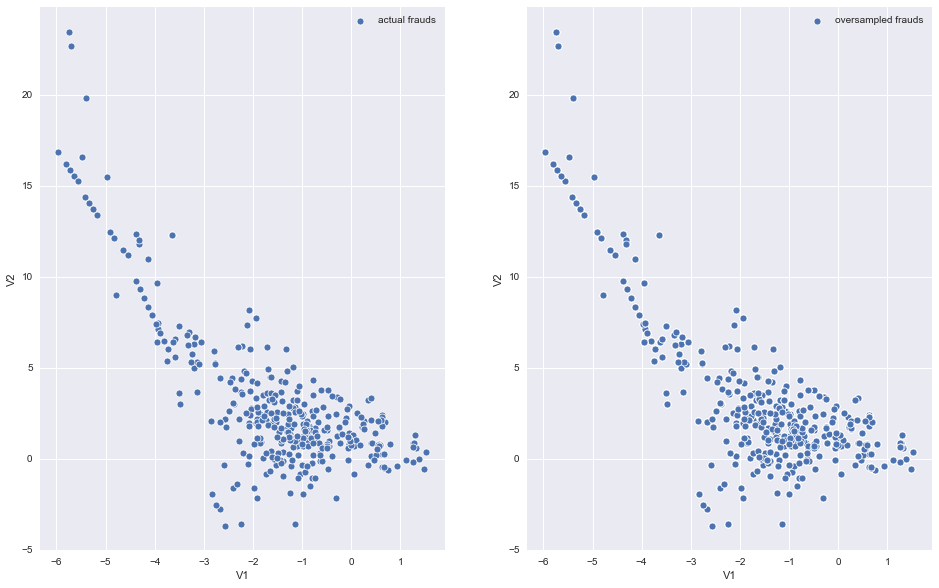

In [35]:
# lets understand the distribution of both classes
X_train_1 = X_train_p[y_train ==1]
X_rand_1 = X_rand[y_rand == 1]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (16,10))
sns.scatterplot(X_train_1.iloc[:, 0], X_train_1.iloc[:, 1], label ='actual frauds', ax = ax1)
sns.scatterplot(X_rand_1.iloc[:, 0], X_rand_1.iloc[:, 1], label ='oversampled frauds', ax = ax2)
plt.show()

#### Logistic Regression

In [36]:
# creating a pipeline for transformation, randomoversampling and logistic regression model
ptrans = PowerTransformer(copy=True)
rand_sampler = RandomOverSampler(random_state=16)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, )
steps = [('ptrans', ptrans), ('rand_sampler', rand_sampler), ('lr', lr_model)]
lr_pipeline_rand = Pipeline(steps)

# understanding the cv_result of the base model
crossvalidation_results(lr_pipeline_rand, X_train, y_train)

(array([0.97846918, 0.97427245, 0.98408874, 0.98532675, 0.97116619]),
 0.9786646598319468,
 0.005465543504572231)

In [59]:
%%time
# tuning hyperparmaters  for l1 and l2 penalties
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['l1', 'l2'], 
         'lr__solver': ['liblinear', 'lbfgs','saga'], 'lr__class_weight' :[None, 'balanced']}

cv_results, best_params = grid_search(lr_pipeline_rand, param_grid, X_train, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 14.3min finished


{'lr__C': 4, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Wall time: 14min 42s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__penalty,param_lr__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
113,48.455363,8.596681,0.162497,0.012481,4,None,l2,saga,"{'lr__C': 4, 'lr__class_weight': None, 'lr__pe...",0.978456,...,0.97867,0.005454,1,0.990243,0.990365,0.98865,0.988936,0.989973,0.989633,0.000704
119,49.677089,10.022101,0.142621,0.016597,4,balanced,l2,saga,"{'lr__C': 4, 'lr__class_weight': 'balanced', '...",0.978456,...,0.97867,0.005454,1,0.990243,0.990365,0.98865,0.988936,0.989973,0.989633,0.000704


In [60]:
%%time
# tuning hyperparmaters for elasticnet penalty
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['elasticnet'], 
         'lr__solver': ['saga'], 'lr__class_weight' :[None, 'balanced'], 'lr__l1_ratio':[i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lr_pipeline_rand, param_grid, X_train, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 39.6min finished


{'lr__C': 10, 'lr__class_weight': None, 'lr__l1_ratio': 0.1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
Wall time: 40min 11s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__l1_ratio,param_lr__penalty,param_lr__solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
220,47.764690,9.144136,0.131398,0.013281,10,None,0.1,elasticnet,saga,"{'lr__C': 10, 'lr__class_weight': None, 'lr__l...",...,0.97867,0.005454,1,0.990243,0.990366,0.98865,0.988936,0.989973,0.989634,0.000704
230,47.905731,9.392199,0.114953,0.012123,10,balanced,0.1,elasticnet,saga,"{'lr__C': 10, 'lr__class_weight': 'balanced', ...",...,0.97867,0.005454,1,0.990243,0.990366,0.98865,0.988936,0.989973,0.989634,0.000704


In [303]:
# final pipeline on logistic regression and random oversampling based on hyperparameter tuning
ptrans = PowerTransformer(copy=True)
rand_sampler = RandomOverSampler(random_state=16)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, penalty ='l2', C =4, solver ='saga', max_iter = 5000)
steps = [('ptrans', ptrans), ('rand_sampler', rand_sampler), ('lr', lr_model)]
lr_pipeline_rand_final = Pipeline(steps)
lr_pipeline_rand_final.fit(X_train, y_train)

# results on train and test data
results_auc(lr_pipeline_rand_final, X_train, y_train, test = False)
results_auc(lr_pipeline_rand_final, X_test, y_test,test = True)


--------- Train Results ---------

Train auc is 0.9884

--------- confusion matrix ---------
[[207738   5498]
 [    26    343]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    213236
           1       0.06      0.93      0.11       369

    accuracy                           0.97    213605
   macro avg       0.53      0.95      0.55    213605
weighted avg       1.00      0.97      0.99    213605


--------- Test Results ---------

Test auc is 0.9767

--------- confusion matrix ---------
[[69235  1844]
 [   14   109]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.06      0.89      0.11       123

    accuracy                           0.97     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.97      0.99     71202



In [304]:
%%time
repeated_crossvalidation(lr_pipeline_rand_final, X_train, y_train)

0.9784122359042396 0.012171998096847495
Wall time: 2min 36s


array([0.97317641, 0.99039316, 0.98656792, 0.97443406, 0.98361914,
       0.97167896, 0.97764426, 0.97184429, 0.99066345, 0.98601087,
       0.99373174, 0.98064849, 0.94124044, 0.97397048, 0.99595422,
       0.99449877, 0.97602981, 0.99094008, 0.97323249, 0.97052294,
       0.9580404 , 0.96793507, 0.97108095, 0.98943115, 0.97918107,
       0.95796652, 0.9778911 , 0.99430586, 0.97674118, 0.97568284,
       0.96988954, 0.97969028, 0.98542402, 0.97597087, 0.97412733,
       0.96985293, 0.99230959, 0.99080541, 0.96495682, 0.98562524,
       0.95695666, 0.98395439, 0.98381972, 0.97417929, 0.99384989,
       0.99258151, 0.97188389, 0.99124808, 0.98964472, 0.94878351])

In [33]:
models_score.loc[4,:] = ['Logistic Regression', 'Random over-Sampling', 0.9884, 0.9787, 0.9767, 0.9784]

models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784


#### Random Forest

In [35]:
# creating a pipeline using random oversampler and random forest model
rand_sampler = RandomOverSampler(random_state=16)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1)
steps = [('rand_sampler', rand_sampler), ('rf',rf_model)]
rf_pipeline_rand = Pipeline(steps)
rf_pipeline_rand.fit(X_train_p, y_train)

crossvalidation_results(rf_pipeline_rand, X_train, y_train)

(array([0.95722792, 0.95792185, 0.95806096, 0.97200304, 0.95057493]),
 0.9591577381190651,
 0.007001726886645023)

In [65]:
%%time
# tuning n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': [100, 300, 500, 600, 800], 'rf__class_weight' : [None, 'balanced'],
             'rf__max_depth': range(2,14,2)}

cv_results, best_params = grid_search(rf_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 80.5min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 500}
Wall time: 1h 21min 3s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
52,475.525538,24.538344,24.248524,4.870882,balanced,10,500,"{'rf__class_weight': 'balanced', 'rf__max_dept...",0.977097,0.982508,...,0.983922,0.004013,1,0.999992,0.999992,0.999992,0.999989,0.999993,0.999991,0.000001
22,492.922646,17.985750,22.951343,6.256015,None,10,500,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977097,0.982508,...,0.983922,0.004013,1,0.999992,0.999992,0.999992,0.999989,0.999993,0.999991,0.000001


In [36]:
%%time
# further tuning n_estimators, max_depth and class_weight
param_grid = {'rf__n_estimators': range(350, 600, 50), 'rf__class_weight' : [None],
             'rf__max_depth': [9,10,11]}

cv_results, best_params = grid_search(rf_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 25.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 25.7min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 500}
Wall time: 26min 17s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,485.134097,19.907238,29.894659,5.907771,None,10,500,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977097,0.982508,...,0.983922,0.004013,1,0.999992,0.999992,0.999992,0.999989,0.999993,0.999991,0.000001
9,522.735197,5.595955,31.088988,5.210140,None,10,550,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977574,0.981919,...,0.983726,0.003863,2,0.999992,0.999992,0.999992,0.999988,0.999993,0.999991,0.000002


In [37]:
%%time
# further tuning n_estimators, max_depth and class_weight
param_grid = {'rf__n_estimators': range(460, 540, 10), 'rf__class_weight' : [None],
             'rf__max_depth': [10]}

cv_results, best_params = grid_search(rf_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  8.9min remaining: 16.5min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 15.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.2min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 520}
Wall time: 15min 49s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,343.940412,22.007773,4.798041,1.823125,None,10,520,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977870,0.982096,...,0.984026,0.003820,1,0.999992,0.999991,0.999992,0.999988,0.999993,0.999991,0.000002
4,494.861642,51.734394,6.415668,2.472337,None,10,500,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977097,0.982508,...,0.983922,0.004013,2,0.999992,0.999992,0.999992,0.999989,0.999993,0.999991,0.000001


In [39]:
%%time
# tuning max_features
param_grid = {'rf__n_estimators': [520], 'rf__class_weight' : [None],
             'rf__max_depth': [10], 'rf__max_features': ['auto',0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1]}

cv_results, best_params = grid_search(rf_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  45 | elapsed: 27.0min remaining: 30.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 46.8min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__n_estimators': 520}
Wall time: 47min 20s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,556.498216,9.923816,55.721456,1.689257,None,10,auto,520,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.977870,...,0.984026,0.003820,1,0.999992,0.999991,0.999992,0.999988,0.999993,0.999991,0.000002
1,910.211016,17.247205,55.478860,2.950575,None,10,0.3,520,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.969404,...,0.980904,0.007054,2,0.999989,0.999987,0.999990,0.999987,0.999991,0.999989,0.000002


In [40]:
%%time
# tuning min_samples_split and min_samples_leaf
param_grid = {'rf__n_estimators': [520], 'rf__class_weight' : [None],
             'rf__max_depth': [10], 'rf__max_features': ['auto'], 
             'rf__min_samples_split': [2, 5, 10, 15, 20], 'rf__min_samples_leaf': [1,5,10]}

cv_results, best_params = grid_search(rf_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 28.5min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 29.7min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 520}
Wall time: 30min 19s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,509.378205,112.099271,9.449999,6.519421,None,10,auto,5,2,520,...,0.984153,0.004074,1,0.999994,0.999992,0.999993,0.999992,0.999994,0.999993,7.737116e-07
6,498.097486,113.230990,13.864644,5.144309,None,10,auto,5,5,520,...,0.984153,0.004074,1,0.999994,0.999992,0.999993,0.999992,0.999994,0.999993,7.737116e-07


In [306]:
# final pipeline based on random oversampling and rf_model
rand_sampler = RandomOverSampler(random_state=16)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1, n_estimators = 520, class_weight= None, 
                                 max_depth= 10, max_features='auto', min_samples_leaf=5, min_samples_split=5)
steps = [('rand_sampler', rand_sampler), ('rf',rf_model)]
rf_pipeline_final_rand = Pipeline(steps)

# fitting the model and results on train and tests data
rf_pipeline_final_rand.fit(X_train_p, y_train)
results_auc(rf_pipeline_final_rand, X_train_p, y_train)
results_auc(rf_pipeline_final_rand, X_test_p, y_test, test=True)


--------- Train Results ---------

Train auc is 1.0

--------- confusion matrix ---------
[[213155     81]
 [     2    367]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.82      0.99      0.90       369

    accuracy                           1.00    213605
   macro avg       0.91      1.00      0.95    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9696

--------- confusion matrix ---------
[[71036    43]
 [   24    99]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.70      0.80      0.75       123

    accuracy                           1.00     71202
   macro avg       0.85      0.90      0.87     71202
weighted avg       1.00      1.00      1.00     71202



In [42]:
%%time
# repeated cross validation  using final rf_pipeline
repeated_crossvalidation(rf_pipeline_final_rand, X_train_p, y_train)

0.9821481733691002 0.009093892570078595
Wall time: 19min 29s


array([0.96891245, 0.99238912, 0.98439198, 0.98459224, 0.98204018,
       0.98260112, 0.9634406 , 0.98969257, 0.98570319, 0.98899767,
       0.99180774, 0.97711635, 0.95145028, 0.9780077 , 0.99759591,
       0.99236663, 0.98406149, 0.98095681, 0.98159213, 0.97497844,
       0.97488649, 0.98081516, 0.97963293, 0.99167237, 0.97906415,
       0.97150616, 0.98725901, 0.99574255, 0.98326139, 0.98583722,
       0.98310958, 0.9876494 , 0.98776505, 0.98184436, 0.98149612,
       0.975226  , 0.99054431, 0.983038  , 0.97671583, 0.9891447 ,
       0.96316871, 0.9886149 , 0.98805626, 0.96991075, 0.99089762,
       0.98774678, 0.96515265, 0.99414584, 0.97886103, 0.98194876])

In [34]:
models_score.loc[5,:] = ['Random Forest', 'Random over-sampling', 1.0, 0.9842, 0.9696, 0.9821]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821


#### lightgbm

In [106]:
#  creating a base pipeline using random oversampling and lightgbm
rand_sampler = RandomOverSampler(random_state=16)
lgb_model_rand= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16, learning_rate= 0.05,
                              subsample = 0.8, colsample_bytree = 0.8)
steps = [('rand_sampler', rand_sampler), ('lgb',lgb_model_rand)]
lgb_pipeline_rand = Pipeline(steps)
lgb_pipeline_rand.fit(X_train_p, y_train)

crossvalidation_results(lgb_pipeline_rand, X_train_p, y_train)

(array([0.96361823, 0.98189537, 0.97922543, 0.98559735, 0.98625169]),
 0.9793176151081695,
 0.008253973064053054)

In [107]:
### Tuning n_estimators and learning rate
param_grid = { 'lgb__n_estimators' : range(25, 500,25), 'lgb__learning_rate': [0.01, 0.02, 0.05, 0.1]}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:  9.0min finished


{'lgb__learning_rate': 0.02, 'lgb__n_estimators': 125}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
23,13.971033,0.217628,0.459794,0.023335,0.02,125,"{'lgb__learning_rate': 0.02, 'lgb__n_estimator...",0.963494,0.982189,0.988906,...,0.982682,0.010033,1,0.999891,0.999877,0.999879,0.999884,0.999872,0.999881,0.000006
18,48.944307,0.690272,1.867895,0.105258,0.01,475,"{'lgb__learning_rate': 0.01, 'lgb__n_estimator...",0.961900,0.985459,0.988076,...,0.982629,0.010495,2,0.999901,0.999892,0.999893,0.999898,0.999888,0.999894,0.000005


In [108]:
### Tuning n_estimators
param_grid = { 'lgb__n_estimators' : range(100,150,1), 'lgb__learning_rate': [0.02]}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.2min finished


{'lgb__learning_rate': 0.02, 'lgb__n_estimators': 115}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,14.416106,0.209249,0.436367,0.019314,0.02,115,"{'lgb__learning_rate': 0.02, 'lgb__n_estimator...",0.969454,0.981015,0.989123,...,0.983816,0.007980,1,0.999883,0.999872,0.999874,0.999884,0.999865,0.999876,0.000007
17,15.079869,0.182495,0.438176,0.018608,0.02,117,"{'lgb__learning_rate': 0.02, 'lgb__n_estimator...",0.964765,0.981215,0.988924,...,0.982863,0.009656,2,0.999883,0.999875,0.999876,0.999883,0.999867,0.999877,0.000006


In [110]:
### Tuning num_leaves and min_child_samples
param_grid = { 'lgb__n_estimators' :[115], 'lgb__learning_rate': [0.02],
             'lgb__num_leaves': range(11,100,10), 'lgb__min_child_samples': range(10,100,10)}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  5.1min finished


{'lgb__learning_rate': 0.02, 'lgb__min_child_samples': 10, 'lgb__n_estimators': 115, 'lgb__num_leaves': 21}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__n_estimators,param_lgb__num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
19,12.716106,0.353975,0.401399,0.024860,0.02,30,115,21,"{'lgb__learning_rate': 0.02, 'lgb__min_child_s...",0.977435,...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019
55,12.139182,0.323191,0.412614,0.063408,0.02,70,115,21,"{'lgb__learning_rate': 0.02, 'lgb__min_child_s...",0.977435,...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019


In [112]:
### Tuning min_child_weight
param_grid = { 'lgb__n_estimators' :[115], 'lgb__learning_rate': [0.02],
             'lgb__num_leaves': [21], 'lgb__min_child_samples': [1,5, 10],
             'lgb__min_child_weight': [0.001, 0.01, 0.1,1, 5,10]}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


{'lgb__learning_rate': 0.02, 'lgb__min_child_samples': 1, 'lgb__min_child_weight': 0.001, 'lgb__n_estimators': 115, 'lgb__num_leaves': 21}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__num_leaves,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,14.548614,0.091228,0.395143,0.014481,0.02,1,0.001,115,21,"{'lgb__learning_rate': 0.02, 'lgb__min_child_s...",...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019
15,10.136316,0.101278,0.305918,0.060803,0.02,10,1,115,21,"{'lgb__learning_rate': 0.02, 'lgb__min_child_s...",...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019


In [113]:
### Tuning subsample and colsample_bytree
param_grid = { 'lgb__n_estimators' :[115], 'lgb__learning_rate': [0.02],
             'lgb__num_leaves': [21], 'lgb__min_child_samples': [10],
             'lgb__min_child_weight': [0.001], 'lgb__subsample':[i/10 for i in range(1,11,1)], 
             'lgb__colsample_bytree':[i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished


{'lgb__colsample_bytree': 0.8, 'lgb__learning_rate': 0.02, 'lgb__min_child_samples': 10, 'lgb__min_child_weight': 0.001, 'lgb__n_estimators': 115, 'lgb__num_leaves': 21, 'lgb__subsample': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__num_leaves,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
79,12.741917,0.266860,0.386480,0.007429,0.8,0.02,10,0.001,115,21,...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019
70,11.914259,0.169552,0.392483,0.015348,0.8,0.02,10,0.001,115,21,...,0.985297,0.004654,1,0.999835,0.999809,0.999802,0.99985,0.999804,0.99982,0.000019


In [114]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'lgb__n_estimators' :[115], 'lgb__learning_rate': [0.02],
             'lgb__num_leaves': [21], 'lgb__min_child_samples': [10],
             'lgb__min_child_weight': [0.001], 'lgb__subsample':[0.8], 
             'lgb__colsample_bytree':[0.8], 'lgb__reg_alpha':[0.01,0.1, 0.5, 1, 5, 10, 50, 100], 
             'lgb__reg_lambda':[0.01,0.1, 0.5, 1, 5, 10, 50, 100]}

cv_results, best_params = grid_search(lgb_pipeline_rand, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.4min finished


{'lgb__colsample_bytree': 0.8, 'lgb__learning_rate': 0.02, 'lgb__min_child_samples': 10, 'lgb__min_child_weight': 0.001, 'lgb__n_estimators': 115, 'lgb__num_leaves': 21, 'lgb__reg_alpha': 10, 'lgb__reg_lambda': 5, 'lgb__subsample': 0.8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__num_leaves,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
44,12.275596,0.305485,0.400737,0.018879,0.8,0.02,10,0.001,115,21,...,0.986537,0.005336,1,0.999828,0.999789,0.999780,0.999844,0.999789,0.999806,0.000025
51,12.634580,0.582815,0.398538,0.010101,0.8,0.02,10,0.001,115,21,...,0.985977,0.005795,2,0.999811,0.999736,0.999747,0.999839,0.999773,0.999781,0.000039


In [310]:
# Finalizing the lightgbm pipeline based on pipeline and lightgbm
params = {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'min_child_samples': 10, 
          'min_child_weight': 0.001, 'n_estimators': 115, 'num_leaves': 21, 
          'reg_alpha': 10, 'reg_lambda': 5, 'subsample': 0.8}

lgb_model_rand_final= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16)
lgb_model_rand_final.set_params(**params)
steps = [('rand_sampler', rand_sampler), ('lgb',lgb_model_rand_final)]
lgb_pipeline_rand_final = Pipeline(steps)

# cross validation score of the final model
crossvalidation_results(lgb_pipeline_rand_final, X_train_p, y_train)

(array([0.97788427, 0.98332905, 0.98829866, 0.99034088, 0.99283321]),
 0.9865372137188713,
 0.005336216710967237)

In [311]:
# results on train and test set
lgb_pipeline_rand_final.fit(X_train_p, y_train)
results_auc(lgb_pipeline_rand_final, X_train_p, y_train)
results_auc(lgb_pipeline_rand_final, X_test_p, y_test, test =True)


--------- Train Results ---------

Train auc is 0.9997

--------- confusion matrix ---------
[[212161   1075]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    213236
           1       0.26      1.00      0.41       369

    accuracy                           0.99    213605
   macro avg       0.63      1.00      0.70    213605
weighted avg       1.00      0.99      1.00    213605


--------- Test Results ---------

Test auc is 0.9706

--------- confusion matrix ---------
[[70730   349]
 [   16   107]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.23      0.87      0.37       123

    accuracy                           0.99     71202
   macro avg       0.62      0.93      0.68     71202
weighted avg       1.00      0.99      1.00     71202



In [317]:
# repeated crossvalidation using the final rand model
repeated_crossvalidation(lgb_pipeline_rand_final, X_train_p, y_train, njobs = 12)

0.9802074627443264 0.009785468943543785


array([0.97012129, 0.98822435, 0.98451493, 0.98232188, 0.97627047,
       0.98413004, 0.96920572, 0.98381718, 0.9826904 , 0.98880945,
       0.99006939, 0.97252983, 0.94159312, 0.97545849, 0.99495671,
       0.98255744, 0.97941397, 0.98150325, 0.98361993, 0.97613311,
       0.97325221, 0.97920357, 0.97864841, 0.98754974, 0.97032062,
       0.9703532 , 0.98468287, 0.98997569, 0.99080399, 0.98103555,
       0.99144976, 0.98395914, 0.98441812, 0.97341849, 0.98307603,
       0.97911383, 0.98973883, 0.97985711, 0.97117537, 0.98215156,
       0.96349569, 0.98594432, 0.987779  , 0.97245014, 0.99375816,
       0.99220764, 0.95802785, 0.99406504, 0.97849347, 0.9720268 ])

In [35]:
models_score.loc[6,:] = ['Light GBM', 'Random over-sampling', 0.9997, 0.9865, 0.9706, 0.9802]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802


#### XGBoost

In [319]:
%%time
# creating the base pipeline using xgboost and random oversampling
rand_sampler = RandomOverSampler(random_state=16)
xgb_model_rand = XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', random_state =16, subsample = 0.8, 
                          colsample_bytree = 0.8, n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
steps = [('rand_sampler', rand_sampler), ('xgb',xgb_model_rand)]
xgb_pipeline_rand = Pipeline(steps)

crossvalidation_results(xgb_model_rand, X_train_p, y_train)

Wall time: 9.01 s


(array([0.98025891, 0.98109591, 0.97915762, 0.99035609, 0.98883765]),
 0.983941238731795,
 0.004683238310088967)

In [156]:
### Tuning n_estimators and learning_rate
param_grid = { 'xgb__n_estimators' : range(25, 510,25), 'xgb__learning_rate': [0.01, 0.02, 0.05, 0.1]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 18.0min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 20.6min finished


{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 175}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
66,7.585359,0.526284,0.125474,0.014109,0.1,175,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.984833,0.985993,0.988898,...,0.986680,0.001752,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
53,15.479633,0.518387,0.203374,0.005457,0.05,350,"{'xgb__learning_rate': 0.05, 'xgb__n_estimator...",0.985240,0.982763,0.990691,...,0.986444,0.002827,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [157]:
### further Tuning n_estimators and learning_rate
param_grid = { 'xgb__n_estimators' : range(150,200,1), 'xgb__learning_rate': [0.1]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  8.6min finished


{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 175}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
25,7.720891,0.194501,0.120271,0.002823,0.1,175,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.984833,0.985993,0.988898,...,0.986680,0.001752,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
27,7.734395,0.233897,0.130912,0.011351,0.1,177,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.985230,0.986140,0.988758,...,0.986663,0.001671,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [159]:
### Tuning max_depth and min_child_samples
param_grid = { 'xgb__n_estimators' : [175], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': range(2,12,2), 'xgb__min_child_samples':[1,5, 10, 20]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.3min finished


{'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_samples': 1, 'xgb__n_estimators': 175}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,7.610798,0.292688,0.131310,0.007916,0.1,6,5,175,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.984833,...,0.98668,0.001752,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
11,7.569976,0.951620,0.140118,0.016494,0.1,6,20,175,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.984833,...,0.98668,0.001752,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [161]:
### Tuning gamma
param_grid = { 'xgb__n_estimators' : [175], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [6], 'xgb__min_child_samples': [1], 
             'xgb__gamma': [0.01,0.1, 0.5, 1, 5, 10,50, 100]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.1min finished


{'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_samples': 1, 'xgb__n_estimators': 175}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,7.995190,0.780627,0.129514,0.021058,0.1,0.1,6,1,175,"{'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1,...",...,0.986667,0.001757,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,8.787221,0.419778,0.127107,0.012339,0.01,0.1,6,1,175,"{'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1...",...,0.986128,0.001703,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [163]:
### Tuning subsample and colsample_bytree
param_grid = { 'xgb__n_estimators' : [175], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [6], 'xgb__min_child_samples': [1], 
             'xgb__gamma': [0.1], 
             'xgb__colsample_bytree': [i/10 for i in range(1,11,1)], 'xgb__subsample': [i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 16.8min finished


{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_samples': 1, 'xgb__n_estimators': 175, 'xgb__subsample': 0.8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
67,7.499642,0.196158,0.122554,0.012312,0.7,0.1,0.1,6,1,175,...,0.987635,0.003360,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
55,7.237536,0.318052,0.126907,0.014259,0.6,0.1,0.1,6,1,175,...,0.987230,0.002704,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [164]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'xgb__n_estimators' : [175], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [6], 'xgb__min_child_samples': [1], 
             'xgb__gamma': [0.1], 
             'xgb__colsample_bytree': [0.7], 'xgb__subsample': [0.8], 
             'xgb__reg_alpha': [0.01, 0.1, 0.5, 1, 5, 10], 'xgb__reg_lambda': [0.01, 0.1, 0.5, 1, 5, 10]}

cv_results, best_params = grid_search(xgb_pipeline_rand, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  6.3min finished


{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__min_child_samples': 1, 'xgb__n_estimators': 175, 'xgb__reg_alpha': 1, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
21,7.197809,1.064368,0.134113,0.008929,0.7,0.1,0.1,6,1,175,...,0.988467,0.002946,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,7.778454,1.039330,0.131570,0.007699,0.7,0.1,0.1,6,1,175,...,0.987865,0.002600,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [324]:
# Finalizing the model
params = {'colsample_bytree': 0.7, 'gamma': 0.1, 
          'learning_rate': 0.1, 'max_depth': 6, 
          'min_child_samples': 1, 'n_estimators': 175, 
          'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}

xgb_model_rand_final = XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', random_state =16,  
                                      n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
xgb_model_rand_final.set_params(**params)
steps = [('rand_sampler', rand_sampler), ('xgb',xgb_model_rand_final)]
xgb_pipeline_rand_final = Pipeline(steps)

crossvalidation_results(xgb_pipeline_rand_final, X_train_p, y_train)

(array([0.98499986, 0.98542878, 0.99189449, 0.99168916, 0.98832338]),
 0.9884671323785685,
 0.0029462684880541537)

In [325]:
# results on train and test set
xgb_pipeline_rand_final.fit(X_train_p, y_train)
results_auc(xgb_pipeline_rand_final, X_train_p, y_train)
results_auc(xgb_pipeline_rand_final, X_test_p, y_test, test =True)


--------- Train Results ---------

Train auc is 1.0

--------- confusion matrix ---------
[[213226     10]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.97      1.00      0.99       369

    accuracy                           1.00    213605
   macro avg       0.99      1.00      0.99    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9806

--------- confusion matrix ---------
[[71060    19]
 [   24    99]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.80      0.82       123

    accuracy                           1.00     71202
   macro avg       0.92      0.90      0.91     71202
weighted avg       1.00      1.00      1.00     71202



In [330]:
# repeated crossvalidation 
repeated_crossvalidation(xgb_pipeline_rand_final, X_train_p, y_train, njobs = 2)

0.982781302296017 0.009142854226116331


array([0.97190798, 0.99113876, 0.987997  , 0.97898018, 0.98046249,
       0.97752388, 0.96725982, 0.98547346, 0.99085453, 0.99269585,
       0.99392607, 0.97534854, 0.95167842, 0.98704639, 0.99526312,
       0.9928192 , 0.98481944, 0.98688542, 0.98163681, 0.97353985,
       0.97093666, 0.98418824, 0.9817512 , 0.99121195, 0.97804193,
       0.9795611 , 0.98645068, 0.98694119, 0.98023561, 0.98589806,
       0.98376098, 0.98131455, 0.98913773, 0.97398711, 0.98481215,
       0.97387502, 0.99205451, 0.98648268, 0.98138268, 0.98839974,
       0.96965443, 0.98945555, 0.99312838, 0.96958881, 0.99484803,
       0.99635403, 0.96979509, 0.99601917, 0.98289319, 0.96964743])

In [36]:
models_score.loc[7,:] = ['XGBoost', 'Random over-sampling', 1.0, 0.9885, 0.9806, 0.9828]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828


### Models with SMOTE

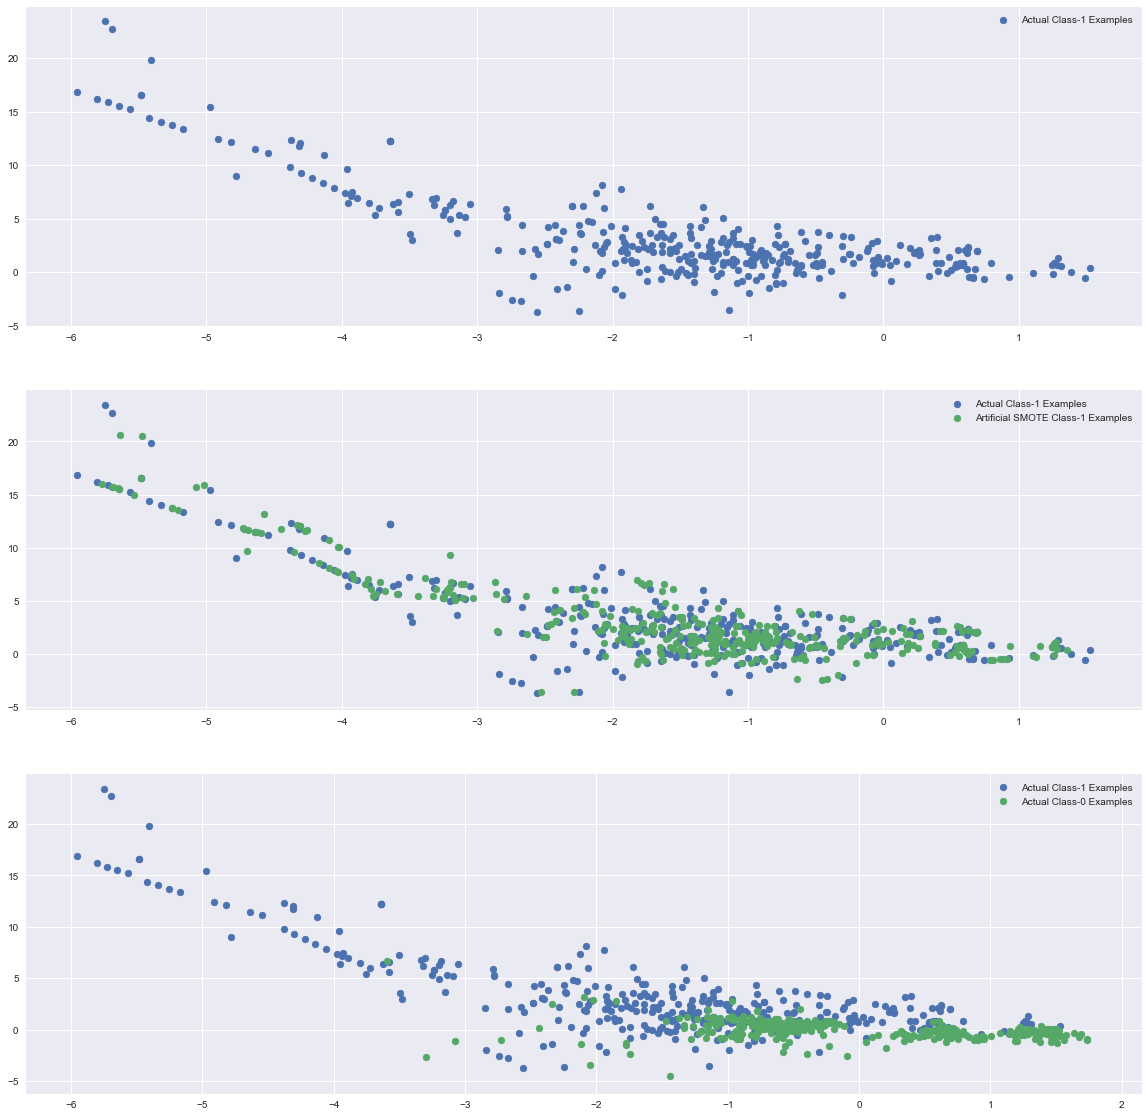

In [150]:
# creating smote and transforming the train datasets using smote
sm = SMOTE(random_state=16, n_jobs = -1)
X_train_smote, y_train_smote = sm.fit_resample(X_train_p, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train_p.shape[0]:]

X_train_1 = X_train_p.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_p.to_numpy()[np.where(y_train==0.0)]


# visualizing synthetically created points
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_smote_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3,)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

plt.show()

#### Logistic Regression

In [127]:
# building a base logistic regression pipeline
ptrans = PowerTransformer(copy=True)
smote = SMOTE(random_state=16, n_jobs = -1)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, )
steps = [('ptrans', ptrans), ('smote', smote), ('lr', lr_model)]
lr_pipeline_smote = Pipeline(steps)

crossvalidation_results(lr_pipeline_smote, X_train, y_train)

(array([0.97886843, 0.97647121, 0.98406973, 0.98249267, 0.96499643]),
 0.9773796924062378,
 0.0067421953225913975)

In [128]:
%%time
# tuning hyperparmaters for logistic regression for penalty l1 and l2
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['l1', 'l2'], 
         'lr__solver': ['liblinear', 'lbfgs','saga'], 'lr__class_weight' :[None, 'balanced']}

cv_results = grid_search(lr_pipeline_smote, param_grid, X_train, y_train)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 14.7min finished


Wall time: 14min 56s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__penalty,param_lr__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
94,14.216710,0.508823,0.138917,0.013344,2,balanced,l2,lbfgs,"{'lr__C': 2, 'lr__class_weight': 'balanced', '...",0.978871,...,0.977381,0.006741,1,0.98866,0.989567,0.987688,0.987819,0.988382,0.988423,0.000674
88,14.434576,0.681964,0.131110,0.022100,2,None,l2,lbfgs,"{'lr__C': 2, 'lr__class_weight': None, 'lr__pe...",0.978871,...,0.977381,0.006741,1,0.98866,0.989567,0.987688,0.987819,0.988382,0.988423,0.000674


In [129]:
%%time
# tuning hyperparmaters for penalty elasticnet
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['elasticnet'], 
         'lr__solver': ['saga'], 'lr__class_weight' :[None, 'balanced'], 'lr__l1_ratio':[i/10 for i in range(1,11,1)]}

cv_results = grid_search(lr_pipeline_smote, param_grid, X_train, y_train)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 42.8min finished


Wall time: 43min 29s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__l1_ratio,param_lr__penalty,param_lr__solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
207,50.850178,6.802386,0.112096,0.004907,5,None,0.8,elasticnet,saga,"{'lr__C': 5, 'lr__class_weight': None, 'lr__l1...",...,0.977376,0.00675,1,0.988672,0.989465,0.98769,0.987818,0.988385,0.988406,0.00064
217,50.671078,6.845074,0.111694,0.008624,5,balanced,0.8,elasticnet,saga,"{'lr__C': 5, 'lr__class_weight': 'balanced', '...",...,0.977376,0.00675,1,0.988672,0.989465,0.98769,0.987818,0.988385,0.988406,0.00064


In [47]:
%%time
# final model on logistic regression
ptrans = PowerTransformer(copy=True)
smote = SMOTE(random_state=16, n_jobs = -1)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, penalty = 'l2', C = 2, solver = 'lbfgs')
steps = [('ptrans', ptrans), ('smote', smote), ('lr', lr_model)]
lr_pipeline_smote_final = Pipeline(steps)

lr_pipeline_smote_final.fit(X_train, y_train)

# results on train and test data
results_auc(lr_pipeline_smote_final, X_train, y_train, test = False)
results_auc(lr_pipeline_smote_final, X_test, y_test,test = True)


--------- Train Results ---------

Train auc is 0.9876

--------- confusion matrix ---------
[[207205   6031]
 [    27    342]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    213236
           1       0.05      0.93      0.10       369

    accuracy                           0.97    213605
   macro avg       0.53      0.95      0.54    213605
weighted avg       1.00      0.97      0.98    213605


--------- Test Results ---------

Test auc is 0.9746

--------- confusion matrix ---------
[[69070  2009]
 [   13   110]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.05      0.89      0.10       123

    accuracy                           0.97     71202
   macro avg       0.53      0.93      0.54     71202
weighted avg       1.00      0.97      0.98     71202

Wall tim

In [48]:
%%time
# repeated crossvalidation
repeated_crossvalidation(lr_pipeline_smote_final, X_train, y_train)

0.977006480624215 0.012175013830392338
Wall time: 48.4 s


array([0.9649305 , 0.9884327 , 0.98589521, 0.97346539, 0.98394678,
       0.9690284 , 0.97815885, 0.972626  , 0.98878347, 0.98178605,
       0.99260914, 0.98064406, 0.93928758, 0.97164846, 0.99575554,
       0.99366461, 0.97423918, 0.98787342, 0.96960307, 0.9691848 ,
       0.95948195, 0.96984991, 0.9666695 , 0.99098666, 0.97572276,
       0.96059909, 0.97790599, 0.99411067, 0.97349961, 0.97135567,
       0.96692132, 0.98122456, 0.98402758, 0.97256009, 0.97395558,
       0.96923847, 0.99301969, 0.98894286, 0.96165631, 0.98047231,
       0.95793119, 0.98571871, 0.98408113, 0.97184429, 0.99008707,
       0.99108279, 0.97413968, 0.98855279, 0.98594686, 0.94717571])

In [37]:
models_score.loc[8,:] = ['Logistic Regression', 'SMOTE over-sampling', 0.9875, 0.9774, 0.9746, 0.9770]

models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770


#### Random Forest

In [43]:
# creating a pipeline for smote and rf
smote = SMOTE(random_state=16, n_jobs = -1)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1)
steps = [('smote', smote), ('rf',rf_model)]
rf_pipeline_smote = Pipeline(steps)
rf_pipeline_smote.fit(X_train_p, y_train)

crossvalidation_results(rf_pipeline_smote, X_train, y_train)

(array([0.96670595, 0.98771657, 0.96656556, 0.98235356, 0.96811442]),
 0.9742912139887656,
 0.0089511608431672)

In [44]:
%%time
# tuning hyperparmaters for Random Forest - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': [100, 300, 500, 600, 800], 'rf__class_weight' : [None],
             'rf__max_depth': range(2,14,2)}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 61.4min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 500}
Wall time: 1h 2min 13s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
22,775.418242,10.173193,45.114511,5.737939,None,10,500,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.978522,0.991014,...,0.986283,0.004631,1,0.999947,0.999936,0.999945,0.999932,0.999972,0.999946,0.000014
25,263.781226,20.759319,39.305108,11.061806,None,12,100,"{'rf__class_weight': None, 'rf__max_depth': 12...",0.978244,0.990300,...,0.986237,0.004245,2,0.999990,0.999990,0.999993,0.999989,0.999996,0.999992,0.000002


In [45]:
%%time
# tuning hyperparmaters for Random Forest - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': range(50,300,50), 'rf__class_weight' : [None],
             'rf__max_depth': range(10,16,2)}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 14.6min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 15.5min finished


{'rf__class_weight': None, 'rf__max_depth': 14, 'rf__n_estimators': 200}
Wall time: 15min 58s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,271.906633,38.019904,10.013434,5.340062,None,14,200,"{'rf__class_weight': None, 'rf__max_depth': 14...",0.979191,0.989164,...,0.986691,0.004032,1,1.000000,0.999999,0.999999,0.999999,1.000000,1.000000,1.688164e-07
3,246.061504,15.060595,17.257644,6.047933,None,10,200,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.979463,0.991721,...,0.986432,0.004566,2,0.999949,0.999927,0.999937,0.999919,0.999971,0.999941,1.820040e-05


In [46]:
%%time
# tuning hyperparmaters for Random Forest - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': range(50,300,50), 'rf__class_weight' : [None],
             'rf__max_depth': range(16,22,2)}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 17.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 18.3min finished


{'rf__class_weight': None, 'rf__max_depth': 16, 'rf__n_estimators': 200}
Wall time: 18min 43s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,346.978533,22.754365,13.378339,2.372935,None,16,200,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.980551,0.992966,...,0.986905,0.004730,1,1.0,1.0,1.0,1.0,1.0,1.0,4.634751e-08
4,367.330138,49.681761,21.821249,9.466700,None,16,250,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.980706,0.992502,...,0.986820,0.004545,2,1.0,1.0,1.0,1.0,1.0,1.0,4.052972e-08


In [47]:
%%time
# tuning hyperparmaters for Random Forest - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': range(200, 300,10), 'rf__class_weight' : [None],
             'rf__max_depth': [16]}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed: 17.9min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 19.4min finished


{'rf__class_weight': None, 'rf__max_depth': 16, 'rf__n_estimators': 270}
Wall time: 19min 58s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,574.388028,9.678435,12.56120,4.227622,None,16,270,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.981652,0.992472,...,0.987028,0.004445,1,1.0,1.0,1.0,1.0,1.0,1.0,4.802124e-08
0,446.297737,16.584561,31.43297,8.283526,None,16,200,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.980551,0.992966,...,0.986905,0.004730,2,1.0,1.0,1.0,1.0,1.0,1.0,4.634751e-08


In [48]:
%%time
# tuning hyperparmaters for Random Forest - max_features
param_grid = {'rf__n_estimators': [270], 'rf__class_weight' : [None],
             'rf__max_depth': [16], 'rf__max_features': ['auto',0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1]}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  45 | elapsed: 35.1min remaining: 40.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 58.3min finished


{'rf__class_weight': None, 'rf__max_depth': 16, 'rf__max_features': 'auto', 'rf__n_estimators': 270}
Wall time: 58min 55s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,611.627383,10.667579,40.473776,3.443818,None,16,auto,270,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.981652,...,0.987028,0.004445,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.802124e-08
2,1428.813481,64.944049,40.329810,6.530080,None,16,0.4,270,"{'rf__class_weight': None, 'rf__max_depth': 16...",0.970797,...,0.984634,0.007374,2,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,1.581228e-07


In [50]:
%%time
# tuning hyperparmaters for Random Forest - min_samples_split and min_samples_leaf
param_grid = {'rf__n_estimators': [270], 'rf__class_weight' : [None],
             'rf__max_depth': [16], 'rf__max_features': ['auto'], 'rf__min_samples_split': [2,5,10,15,20], 
             'rf__min_samples_leaf': [1,5,10]}

cv_results, best_params = grid_search(rf_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 31.2min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 31.7min finished


{'rf__class_weight': None, 'rf__max_depth': 16, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 270}
Wall time: 32min 17s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,590.910929,12.637671,13.527026,10.320159,None,16,auto,1,2,270,...,0.987028,0.004445,1,1.0,1.000000,1.0,1.0,1.0,1.0,4.802124e-08
4,590.331975,29.369216,9.314878,13.831804,None,16,auto,1,20,270,...,0.985376,0.007828,2,1.0,0.999999,1.0,1.0,1.0,1.0,1.981561e-07


In [51]:
# final pipeline based on random oversampling and rf_model
smote = SMOTE(random_state=16, n_jobs = -1)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1, max_depth = 16, max_features = 'auto', 
                                 min_samples_leaf= 1, min_samples_split=2, n_estimators=270)
steps = [('smote', smote), ('rf',rf_model)]
rf_pipeline_final_smote = Pipeline(steps)
rf_pipeline_final_smote.fit(X_train_p, y_train)

crossvalidation_results(rf_pipeline_final_smote, X_train_p, y_train)

(array([0.98165197, 0.99247183, 0.9921144 , 0.98371673, 0.98518542]),
 0.9870280695834897,
 0.004444501395310895)

In [52]:
# fitting the model and results on train and tests data
rf_pipeline_final_smote.fit(X_train_p, y_train)
results_auc(rf_pipeline_final_smote, X_train_p, y_train)
results_auc(rf_pipeline_final_smote, X_test_p, y_test, test=True)


--------- Train Results ---------

Train auc is 1.0

--------- confusion matrix ---------
[[213163     73]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.83      1.00      0.91       369

    accuracy                           1.00    213605
   macro avg       0.92      1.00      0.95    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9731

--------- confusion matrix ---------
[[71036    43]
 [   26    97]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.69      0.79      0.74       123

    accuracy                           1.00     71202
   macro avg       0.85      0.89      0.87     71202
weighted avg       1.00      1.00      1.00     71202



In [55]:
# repeated cross validation
repeated_crossvalidation(rf_pipeline_final_smote, X_train_p, y_train)

0.9829408600359608 0.011101672632005462


array([0.9732225 , 0.99289199, 0.97814491, 0.98416827, 0.98479124,
       0.97902839, 0.97262378, 0.98979175, 0.98132279, 0.99433533,
       0.99159607, 0.98739812, 0.93999546, 0.99157382, 0.9984128 ,
       0.9923843 , 0.98550799, 0.99262044, 0.97406332, 0.96699492,
       0.97172811, 0.97527217, 0.9896631 , 0.99304789, 0.97513592,
       0.96803268, 0.9891184 , 0.99475518, 0.9839528 , 0.98430342,
       0.98378314, 0.98632076, 0.99253108, 0.97530703, 0.99315119,
       0.97649025, 0.99248292, 0.9837462 , 0.98931137, 0.98451588,
       0.96191538, 0.98438628, 0.98234754, 0.97715469, 0.9964197 ,
       0.99614846, 0.9730148 , 0.99637724, 0.98533071, 0.9604305 ])

In [38]:
models_score.loc[9,:] = ['Random Forest', 'SMOTE over-sampling', 1.0, 0.9870, 0.9731, 0.9829]

models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


#### lightgbm

In [123]:
#  creating a base model using lightgbm and smote oversampling
smote = SMOTE(random_state=16, n_jobs = -1)
lgb_model_smote= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16, learning_rate= 0.05,
                              subsample = 0.8, colsample_bytree = 0.8)
steps = [('smote', smote), ('lgb',lgb_model_smote)]
lgb_pipeline_smote = Pipeline(steps)
lgb_pipeline_smote.fit(X_train_p, y_train)

crossvalidation_results(lgb_pipeline_smote, X_train_p, y_train)

(array([0.97075631, 0.98836298, 0.97746602, 0.98685041, 0.98106042]),
 0.9808992286204742,
 0.006415854797295923)

In [124]:
### Tuning n_estimators and learning rate
param_grid = { 'lgb__n_estimators' : range(25, 500,25), 'lgb__learning_rate': [0.01, 0.02, 0.05, 0.1]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:  9.7min finished


{'lgb__learning_rate': 0.01, 'lgb__n_estimators': 325}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
12,38.217726,0.342736,1.020768,0.047936,0.01,325,"{'lgb__learning_rate': 0.01, 'lgb__n_estimator...",0.979578,0.987523,0.980130,...,0.983488,0.003189,1,0.999809,0.999758,0.999726,0.999724,0.999746,0.999753,0.000031
10,32.594215,0.857948,0.833907,0.036507,0.01,275,"{'lgb__learning_rate': 0.01, 'lgb__n_estimator...",0.980412,0.986176,0.979981,...,0.983480,0.002771,2,0.999778,0.999693,0.999672,0.999663,0.999685,0.999698,0.000041


In [125]:
### Tuning n_estimators and learning rate
param_grid = { 'lgb__n_estimators' : range(300,350,1), 'lgb__learning_rate': [0.01]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.0min finished


{'lgb__learning_rate': 0.01, 'lgb__n_estimators': 313}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,39.292616,0.286286,1.105329,0.045933,0.01,313,"{'lgb__learning_rate': 0.01, 'lgb__n_estimator...",0.980204,0.987385,0.980317,...,0.983617,0.002936,1,0.999803,0.999745,0.999710,0.999711,0.999733,0.999740,0.000034
17,39.167513,0.176812,1.084317,0.044582,0.01,317,"{'lgb__learning_rate': 0.01, 'lgb__n_estimator...",0.979869,0.987473,0.980235,...,0.983593,0.003103,2,0.999805,0.999750,0.999716,0.999716,0.999737,0.999745,0.000033


In [126]:
### Tuning min_samples_child and min_child_weight
param_grid = { 'lgb__n_estimators' :[313], 'lgb__learning_rate': [0.01], 
             'lgb__min_samples_child': range(10,100,10), 'lgb__min_child_weight':[0.001, 0.01,0.1, 1,5,10]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.4min finished


{'lgb__learning_rate': 0.01, 'lgb__min_child_weight': 0.001, 'lgb__min_samples_child': 10, 'lgb__n_estimators': 313}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__min_child_weight,param_lgb__min_samples_child,param_lgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,40.567221,0.444912,1.067101,0.043051,0.01,0.001,10,313,"{'lgb__learning_rate': 0.01, 'lgb__min_child_w...",0.980204,...,0.983617,0.002936,1,0.999803,0.999745,0.99971,0.999711,0.999733,0.99974,0.000034
20,38.474157,0.344855,1.046683,0.033987,0.01,0.1,30,313,"{'lgb__learning_rate': 0.01, 'lgb__min_child_w...",0.980204,...,0.983617,0.002936,1,0.999803,0.999745,0.99971,0.999711,0.999733,0.99974,0.000034


In [127]:
### Tuning min_samples_child and min_child_weight
param_grid = { 'lgb__n_estimators' :[313], 'lgb__learning_rate': [0.01], 
             'lgb__min_samples_child': range(1,10,1), 'lgb__min_child_weight':[0.001]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  45 | elapsed:   50.8s remaining:   58.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


{'lgb__learning_rate': 0.01, 'lgb__min_child_weight': 0.001, 'lgb__min_samples_child': 1, 'lgb__n_estimators': 313}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__min_child_weight,param_lgb__min_samples_child,param_lgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,40.380710,0.452541,1.031867,0.037034,0.01,0.001,1,313,"{'lgb__learning_rate': 0.01, 'lgb__min_child_w...",0.980204,...,0.983617,0.002936,1,0.999803,0.999745,0.99971,0.999711,0.999733,0.99974,0.000034
1,40.610904,0.379225,1.051885,0.050815,0.01,0.001,2,313,"{'lgb__learning_rate': 0.01, 'lgb__min_child_w...",0.980204,...,0.983617,0.002936,1,0.999803,0.999745,0.99971,0.999711,0.999733,0.99974,0.000034


In [128]:
### Tuning subsample and colsample_bytree
param_grid = { 'lgb__n_estimators' :[313], 'lgb__learning_rate': [0.01], 
             'lgb__min_samples_child': [10], 'lgb__min_child_weight':[0.001],
             'lgb__subsample':[i/10 for i in range(1,11,1)], 'lgb__colsample_bytree':[i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.1min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.01, 'lgb__min_child_weight': 0.001, 'lgb__min_samples_child': 10, 'lgb__n_estimators': 313, 'lgb__subsample': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_weight,param_lgb__min_samples_child,param_lgb__n_estimators,param_lgb__subsample,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
49,24.301252,1.373960,1.170992,0.049982,0.5,0.01,0.001,10,313,1,...,0.985492,0.004427,1,0.999793,0.99975,0.999724,0.999749,0.999692,0.999742,0.000033
48,26.950471,0.359335,1.204853,0.023451,0.5,0.01,0.001,10,313,0.9,...,0.985492,0.004427,1,0.999793,0.99975,0.999724,0.999749,0.999692,0.999742,0.000033


In [130]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'lgb__n_estimators' :[313], 'lgb__learning_rate': [0.01], 
             'lgb__min_samples_child': [10], 'lgb__min_child_weight':[0.001],
             'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[0.01, 0.1, 0.5, 1, 5, 10, 50], 'lgb__reg_lambda':[0.01, 0.1, 0.5, 1, 5, 10, 50]}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  5.9min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.01, 'lgb__min_child_weight': 0.001, 'lgb__min_samples_child': 10, 'lgb__n_estimators': 313, 'lgb__reg_alpha': 1, 'lgb__reg_lambda': 1, 'lgb__subsample': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_weight,param_lgb__min_samples_child,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
24,25.455719,2.206075,1.121394,0.017129,0.5,0.01,0.001,10,313,1,...,0.98561,0.004226,1,0.999791,0.999747,0.999721,0.999744,0.999695,0.999740,0.000032
29,25.167009,2.232967,1.120490,0.026001,0.5,0.01,0.001,10,313,5,...,0.98560,0.004194,2,0.999787,0.999746,0.999719,0.999736,0.999688,0.999735,0.000033


In [132]:
### Tuning subsample for bin
param_grid = { 'lgb__n_estimators' :[313], 'lgb__learning_rate': [0.01], 
             'lgb__min_samples_child': [10], 'lgb__min_child_weight':[0.001],
             'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[1], 'lgb__reg_lambda':[1], 
             'lgb__subsample_for_bin': range(50000, 500000, 10000)}

cv_results, best_params = grid_search(lgb_pipeline_smote, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  5.5min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.01, 'lgb__min_child_weight': 0.001, 'lgb__min_samples_child': 10, 'lgb__n_estimators': 313, 'lgb__reg_alpha': 1, 'lgb__reg_lambda': 1, 'lgb__subsample': 0.1, 'lgb__subsample_for_bin': 80000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_weight,param_lgb__min_samples_child,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,30.501395,0.262434,1.212021,0.035081,0.5,0.01,0.001,10,313,1,...,0.986115,0.003712,1,0.999803,0.999747,0.999715,0.999708,0.999713,0.999737,0.000036
29,24.153720,1.222326,1.145673,0.057662,0.5,0.01,0.001,10,313,1,...,0.986036,0.003764,2,0.999796,0.999739,0.999719,0.999727,0.999708,0.999738,0.000031


In [134]:
# Finalizing the model based on hyper parameter tuning
params = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 
          'min_child_weight': 0.001, 'min_samples_child': 10, 
          'n_estimators': 313, 'reg_alpha': 1, 'reg_lambda': 1, 
          'subsample': 0.1, 'subsample_for_bin': 80000}

smote = SMOTE(random_state=16, n_jobs = -1)
lgb_model_smote_final= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16)
lgb_model_smote_final.set_params(**params)
steps = [('smote', smote), ('lgb',lgb_model_smote_final)]
lgb_pipeline_smote_final = Pipeline(steps)
lgb_pipeline_smote_final.fit(X_train_p, y_train)


crossvalidation_results(lgb_pipeline_smote_final, X_train_p, y_train)

(array([0.98007679, 0.98867415, 0.98808018, 0.99010402, 0.98363974]),
 0.9861149758885362,
 0.003712421153742824)

In [135]:
# testing the metrics on train and test data
results_auc(lgb_pipeline_smote_final, X_train_p, y_train)
results_auc(lgb_pipeline_smote_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 0.9996

--------- confusion matrix ---------
[[212427    809]
 [     6    363]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.31      0.98      0.47       369

    accuracy                           1.00    213605
   macro avg       0.65      0.99      0.73    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.9801

--------- confusion matrix ---------
[[70797   282]
 [   17   106]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.27      0.86      0.41       123

    accuracy                           1.00     71202
   macro avg       0.64      0.93      0.71     71202
weighted avg       1.00      1.00      1.00     71202



In [136]:
# repeated  crossvalidation on the train dataset
repeated_crossvalidation(lgb_pipeline_smote_final, X_train_p, y_train)

0.9860422475190763 0.007038778429772636


array([0.97628741, 0.99191144, 0.99051738, 0.98770009, 0.98466005,
       0.97995506, 0.97740676, 0.98688146, 0.98816193, 0.99441138,
       0.99576495, 0.98259312, 0.96225203, 0.98723335, 0.99793433,
       0.99300245, 0.98579207, 0.99117852, 0.98150087, 0.98493763,
       0.97809064, 0.98690586, 0.98332857, 0.99152629, 0.98012756,
       0.98142118, 0.98992135, 0.99252823, 0.98369455, 0.98728278,
       0.98947934, 0.98745389, 0.99200001, 0.97565622, 0.98779373,
       0.98055008, 0.99201141, 0.98872929, 0.98475448, 0.99215448,
       0.97460897, 0.98537713, 0.99312774, 0.97793277, 0.99563703,
       0.99590499, 0.97526679, 0.99612184, 0.98526844, 0.97737444])

In [39]:
# Final model scores
models_score.loc[10,:] = ['Light GBM', 'SMOTE over-sampling', 0.9996, 0.9861, 0.9801, 0.9860]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


#### XGBoost

In [186]:
%%time
# creating the base model using smote oversampling and xgb model
smote = SMOTE(random_state=16, n_jobs = -1)
xgb_model_smote = XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', random_state =16, subsample = 0.8, 
                          colsample_bytree = 0.8, n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
steps = [('smote', smote), ('xgb',xgb_model_smote)]
xgb_pipeline_smote = Pipeline(steps)

crossvalidation_results(xgb_model_smote, X_train_p, y_train)

Wall time: 8.32 s


(array([0.98025891, 0.98109591, 0.97915762, 0.99035609, 0.98883765]),
 0.983941238731795,
 0.004683238310088967)

In [189]:
### Tuning n_estimators and fixing the learning rate at 0.1
param_grid = { 'xgb__n_estimators' : range(25, 510,25), 'xgb__learning_rate': [0.1]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.2min finished


{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,2.918174,0.742999,0.064323,0.006056,0.1,50,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.976024,0.992636,0.977054,...,0.982998,0.006075,1,0.999923,0.999873,0.999886,0.999834,0.999905,0.999884,0.00003
19,17.389144,2.726341,0.300422,0.015439,0.1,500,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.973541,0.977848,0.985077,...,0.982629,0.005944,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000


In [192]:
### Tuning n_estimators
param_grid = { 'xgb__n_estimators' : range(25, 75, 1), 'xgb__learning_rate': [0.1]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  3.0min finished


{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 38}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,1.833012,0.396223,0.069191,0.007322,0.1,38,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.977373,0.991641,0.978311,...,0.983724,0.005330,1,0.999828,0.999795,0.999778,0.999706,0.999835,0.999788,0.000046
7,1.764727,0.406055,0.059958,0.006636,0.1,32,"{'xgb__learning_rate': 0.1, 'xgb__n_estimators...",0.978536,0.989000,0.981367,...,0.983663,0.004065,2,0.999710,0.999733,0.999680,0.999639,0.999741,0.999701,0.000037


In [195]:
### Tuning max_depth and min_child_samples
param_grid = { 'xgb__n_estimators' :[38], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': range(2,16,2), 'xgb__min_child_samples': range(10,100,10)}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:  8.5min finished


{'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__min_child_samples': 10, 'xgb__n_estimators': 38}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
51,11.758669,0.879557,0.062501,0.009882,0.1,12,70,38,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.980318,...,0.985326,0.004373,1,0.99995,0.999954,0.999982,0.999929,0.999979,0.999959,0.00002
45,11.743726,0.862910,0.066918,0.008327,0.1,12,10,38,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.980318,...,0.985326,0.004373,1,0.99995,0.999954,0.999982,0.999929,0.999979,0.999959,0.00002


In [199]:
### Tuning max_depth and min_child_samples
param_grid = { 'xgb__n_estimators' : [38], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [11,12,13], 'xgb__min_child_samples': range(10,100,10)}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  6.8min finished


{'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__min_child_samples': 10, 'xgb__n_estimators': 38}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,11.737517,0.824208,0.065626,0.006250,0.1,12,50,38,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.980318,...,0.985326,0.004373,1,0.99995,0.999954,0.999982,0.999929,0.999979,0.999959,0.00002
17,11.806087,0.779032,0.069164,0.006061,0.1,12,90,38,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.980318,...,0.985326,0.004373,1,0.99995,0.999954,0.999982,0.999929,0.999979,0.999959,0.00002


In [202]:
### Tuning gamma
param_grid = { 'xgb__n_estimators' : [38], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [10], 
             'xgb__gamma': [0, 0.01, 0.1, 0.5, 1, 5, 10]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


{'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 38}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.500818,1.794837,0.063306,0.013348,0,0.1,12,50,38,"{'xgb__gamma': 0, 'xgb__learning_rate': 0.1, '...",...,0.985326,0.004373,1,0.999950,0.999954,0.999982,0.999929,0.999979,0.999959,0.00002
1,12.440900,0.628831,0.062712,0.009892,0.01,0.1,12,50,38,"{'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1...",...,0.985154,0.005478,2,0.999976,0.999976,0.999982,0.999930,0.999979,0.999969,0.00002


In [203]:
### Tuning subsample and colsample_bytree
param_grid = { 'xgb__n_estimators' : [38], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [50], 
             'xgb__gamma': [0], 
             'xgb__subsample': [i/10 for i in range(1,11,1)], 'xgb__colsample_bytree': [i/10 for i in range(1,11,1)], }

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 27.2min finished


{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 38, 'xgb__subsample': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
41,8.947313,0.315825,0.066202,0.006065,0.5,0,0.1,12,50,38,...,0.985792,0.004537,1,0.999895,0.999939,0.999890,0.999892,0.999951,0.999913,0.000026
77,12.168003,0.973636,0.066412,0.006049,0.8,0,0.1,12,50,38,...,0.985326,0.004373,2,0.999950,0.999954,0.999982,0.999929,0.999979,0.999959,0.000020


In [204]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'xgb__n_estimators' : [38], 'xgb__learning_rate': [0.1], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [50], 
             'xgb__gamma': [0], 
             'xgb__subsample': [0.2], 'xgb__colsample_bytree': [0.5],
             'xgb__reg_alpha': [0, 0.01, 0.1, 0.5, 1, 5, 10, 50], 'xgb__reg_lambda': [0, 0.01, 0.1, 0.5, 1, 5, 10, 50]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed: 11.7min finished


{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 38, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 5, 'xgb__subsample': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
29,7.452357,1.625261,0.069433,0.007569,0.5,0,0.1,12,50,38,...,0.986331,0.004218,1,0.999890,0.999880,0.999883,0.999884,0.999878,0.999883,0.000004
4,9.149550,0.869846,0.072074,0.005286,0.5,0,0.1,12,50,38,...,0.985792,0.004537,2,0.999895,0.999939,0.999890,0.999892,0.999951,0.999913,0.000026


In [205]:
### Tuning n_estimators with lower learning rate
param_grid = { 'xgb__n_estimators' : range(25,300,25), 'xgb__learning_rate': [0.01], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [50], 
             'xgb__gamma': [0], 
             'xgb__subsample': [0.2], 'xgb__colsample_bytree': [0.5],
             'xgb__reg_alpha': [0.5], 'xgb__reg_lambda': [5]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:  8.3min finished


{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 275, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 5, 'xgb__subsample': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,54.020530,9.710848,0.263129,0.022771,0.5,0,0.01,12,50,275,...,0.987043,0.003609,1,0.999885,0.999875,0.999875,0.999883,0.999868,0.999877,0.000006
9,57.764054,1.709094,0.241010,0.021189,0.5,0,0.01,12,50,250,...,0.986785,0.003500,2,0.999885,0.999875,0.999875,0.999883,0.999867,0.999877,0.000006


In [207]:
### Further tuning n_estimators
param_grid = { 'xgb__n_estimators' : range(400, 500, 25), 'xgb__learning_rate': [0.01], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [50], 
             'xgb__gamma': [0], 
             'xgb__subsample': [0.2], 'xgb__colsample_bytree': [0.5],
             'xgb__reg_alpha': [0.5], 'xgb__reg_lambda': [5]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.7min finished


{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 425, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 5, 'xgb__subsample': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,87.761493,2.126118,0.448762,0.026774,0.5,0,0.01,12,50,425,...,0.987517,0.003232,1,0.999882,0.999911,0.999893,0.999897,0.999900,0.999897,0.000009
0,85.507512,2.950064,0.417650,0.012975,0.5,0,0.01,12,50,400,...,0.987470,0.003347,2,0.999886,0.999876,0.999874,0.999883,0.999868,0.999877,0.000006


In [210]:
### Further tuning n_estimators
param_grid = { 'xgb__n_estimators' : range(415, 425,1), 'xgb__learning_rate': [0.01], 
             'xgb__max_depth': [12], 'xgb__min_child_samples': [50], 
             'xgb__gamma': [0], 
             'xgb__subsample': [0.2], 'xgb__colsample_bytree': [0.5],
             'xgb__reg_alpha': [0.5], 'xgb__reg_lambda': [5]}

cv_results, best_params = grid_search(xgb_pipeline_smote, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 13.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 18.5min finished


{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 12, 'xgb__min_child_samples': 50, 'xgb__n_estimators': 415, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 5, 'xgb__subsample': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,87.756296,2.382454,0.484209,0.041246,0.5,0,0.01,12,50,415,...,0.987536,0.003302,1,0.999882,0.999898,0.99987,0.999898,0.999898,0.999889,0.000012
2,85.729515,1.924742,0.466241,0.031832,0.5,0,0.01,12,50,417,...,0.987535,0.003234,2,0.999882,0.999898,0.99987,0.999898,0.999898,0.999889,0.000011


In [213]:
# Finalizing the model based on tuned hyper parameters
params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 
          'max_depth': 12, 'min_child_samples': 50, 'n_estimators': 415,
          'reg_alpha': 0.5, 'reg_lambda': 5, 'subsample': 0.2}

xgb_model_smote_final = XGBClassifier(objective= 'binary:logistic', random_state =16,  
                                      n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
xgb_model_smote_final.set_params(**params)
steps = [('smote', smote), ('xgb',xgb_model_smote_final)]
xgb_pipeline_smote_final = Pipeline(steps)

# cross validation for the xgb final pipeline
crossvalidation_results(xgb_pipeline_smote_final, X_train_p, y_train)

(array([0.98138923, 0.99138845, 0.98824638, 0.98806386, 0.98859208]),
 0.9875359988484076,
 0.003302205191015705)

In [216]:
# fitting on train data and testing the results on train and test scores
xgb_pipeline_smote_final.fit(X_train_p, y_train)
results_auc(xgb_pipeline_smote_final, X_train_p, y_train)
results_auc(xgb_pipeline_smote_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 0.9999

--------- confusion matrix ---------
[[212997    239]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.61      1.00      0.76       369

    accuracy                           1.00    213605
   macro avg       0.80      1.00      0.88    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.98

--------- confusion matrix ---------
[[70978   101]
 [   19   104]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.51      0.85      0.63       123

    accuracy                           1.00     71202
   macro avg       0.75      0.92      0.82     71202
weighted avg       1.00      1.00      1.00     71202



In [231]:
%%time
## Repeated cross validation
repeated_crossvalidation(xgb_pipeline_smote_final, X_train_p, y_train, njobs = 4)

0.98643545983698 0.0072071854166291605
Wall time: 18min 25s


array([0.97935794, 0.99217745, 0.98755243, 0.9875819 , 0.98485271,
       0.97803202, 0.98135448, 0.98952827, 0.98857291, 0.99302397,
       0.99539364, 0.98311722, 0.95743245, 0.99124649, 0.9985329 ,
       0.99078905, 0.98692155, 0.99242366, 0.98235293, 0.9818293 ,
       0.97907785, 0.98487584, 0.98442177, 0.99292923, 0.97720413,
       0.98401425, 0.99217048, 0.98964615, 0.98506596, 0.98803772,
       0.98815519, 0.98788673, 0.9924647 , 0.97573259, 0.98826491,
       0.97984007, 0.9928546 , 0.99002227, 0.98908576, 0.99259477,
       0.97789037, 0.98863264, 0.99125315, 0.97921624, 0.99624526,
       0.99559182, 0.97389918, 0.99605007, 0.98595225, 0.98062378])

In [40]:
# Final model scores
models_score.loc[11,:] = ['XGBoost', 'SMOTE over-sampling', 0.9999, 0.9875, 0.9800, 0.9864]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


### Models with ADASYN

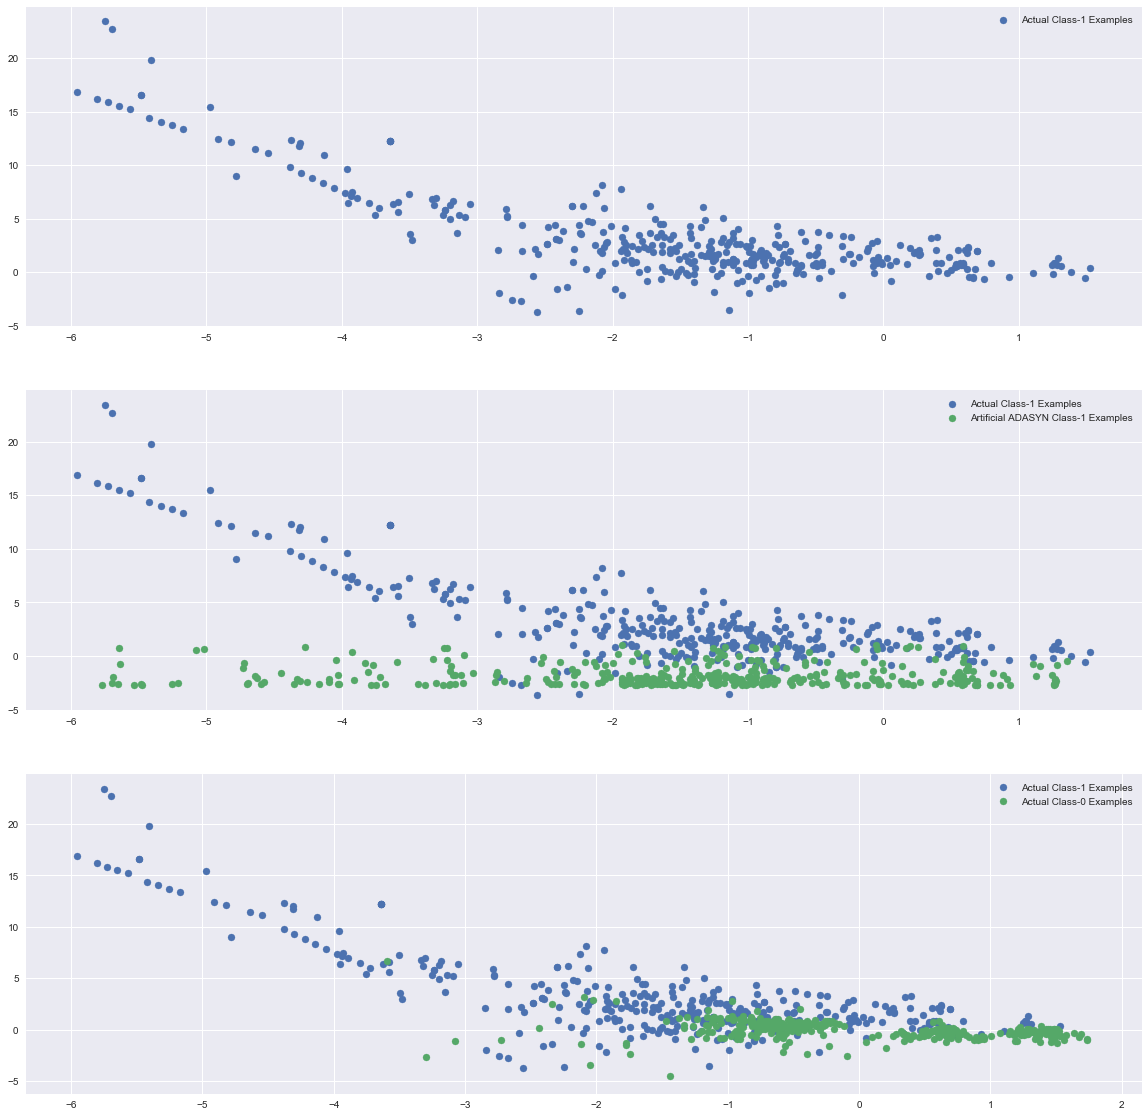

In [151]:
adasyn = ADASYN(random_state=16, n_jobs = -1)
X_train_ada, y_train_ada = adasyn.fit_resample(X_train_p, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_ada_1 = X_train_ada[X_train_p.shape[0]:]

X_train_1 = X_train_p.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_p.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_ada_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3,)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

plt.show()

#### Logistic Regression

In [130]:
# creating a logistic pipeline with transformation, adasyn oversampling and logistic model
ptrans = PowerTransformer(copy=True)
adasyn = ADASYN(random_state=16, n_jobs = -1)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, )
steps = [('ptrans', ptrans), ('adasyn', adasyn), ('lr', lr_model)]
lr_pipeline_adasyn = Pipeline(steps)

crossvalidation_results(lr_pipeline_adasyn, X_train, y_train)

(array([0.97628115, 0.97380824, 0.98578114, 0.97945548, 0.9655706 ]),
 0.9761793195777079,
 0.006649894992409366)

In [131]:
%%time
# tuning hyperparmaters  for l1 and l2 penalties
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['l1', 'l2'], 
         'lr__solver': ['liblinear', 'lbfgs','saga'], 'lr__class_weight' :[None, 'balanced']}

cv_results = grid_search(lr_pipeline_adasyn, param_grid, X_train, y_train)
cv_results.sort_values('rank_test_score').head(2)

Wall time: 0 ns
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 18.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__penalty,param_lr__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
112,21.473845,0.870935,0.142920,0.025402,4,None,l2,lbfgs,"{'lr__C': 4, 'lr__class_weight': None, 'lr__pe...",0.976306,...,0.976184,0.006650,1,0.990841,0.991041,0.98928,0.98956,0.990522,0.990249,0.000702
142,19.486386,0.409937,0.106892,0.014400,10,balanced,l2,lbfgs,"{'lr__C': 10, 'lr__class_weight': 'balanced', ...",0.976308,...,0.976184,0.006649,2,0.990841,0.991041,0.98928,0.98956,0.990523,0.990249,0.000702


In [132]:
%%time
# tuning hyperparmaters for elasticnet penalty
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 10], 'lr__penalty': ['elasticnet'], 
         'lr__solver': ['saga'], 'lr__class_weight' :[None, 'balanced'], 'lr__l1_ratio':[i/10 for i in range(1,11,1)]}

cv_results = grid_search(lr_pipeline_adasyn, param_grid, X_train, y_train)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 46.7min finished


Wall time: 47min 22s


C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__l1_ratio,param_lr__penalty,param_lr__solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
239,40.450813,6.584350,0.077065,0.001415,10,balanced,1,elasticnet,saga,"{'lr__C': 10, 'lr__class_weight': 'balanced', ...",...,0.976172,0.006639,1,0.990836,0.990981,0.989225,0.98956,0.990461,0.990212,0.000699
229,56.014254,8.971521,0.138517,0.029334,10,None,1,elasticnet,saga,"{'lr__C': 10, 'lr__class_weight': None, 'lr__l...",...,0.976172,0.006639,2,0.990836,0.990981,0.989225,0.98956,0.990461,0.990212,0.000699


In [140]:
# final logistic pipeline after hyperparameter tuning
ptrans = PowerTransformer(copy=True)
adasyn = ADASYN(random_state=16, n_jobs = -1)
lr_model = LogisticRegression(random_state= 16, n_jobs = -1, solver = 'lbfgs', penalty = 'l2', C = 4)
steps = [('ptrans', ptrans), ('adasyn', adasyn), ('lr', lr_model)]
lr_pipeline_adasyn_final = Pipeline(steps)

# fitting on train data and results for train and test data
lr_pipeline_adasyn_final.fit(X_train, y_train)

results_auc(lr_pipeline_adasyn_final, X_train, y_train, test = False)
results_auc(lr_pipeline_adasyn_final, X_test, y_test,test = True)


--------- Train Results ---------

Train auc is 0.9892

--------- confusion matrix ---------
[[196590  16646]
 [    13    356]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    213236
           1       0.02      0.96      0.04       369

    accuracy                           0.92    213605
   macro avg       0.51      0.94      0.50    213605
weighted avg       1.00      0.92      0.96    213605


--------- Test Results ---------

Test auc is 0.9729

--------- confusion matrix ---------
[[65432  5647]
 [   11   112]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     71079
           1       0.02      0.91      0.04       123

    accuracy                           0.92     71202
   macro avg       0.51      0.92      0.50     71202
weighted avg       1.00      0.92      0.96     71202



In [141]:
%%time
repeated_crossvalidation(lr_pipeline_adasyn_final, X, y)

0.9777942283299271 0.009748039428523371
Wall time: 1min 25s


array([0.96562232, 0.95393784, 0.98213411, 0.99257255, 0.99062911,
       0.98124182, 0.9656749 , 0.967971  , 0.99366271, 0.98056643,
       0.97143746, 0.97800935, 0.98101021, 0.97428172, 0.98731125,
       0.99035747, 0.96939303, 0.97714037, 0.97788616, 0.9759027 ,
       0.98391544, 0.98145019, 0.96361951, 0.98597452, 0.98746486,
       0.97021354, 0.99298438, 0.97991897, 0.96320821, 0.97961786,
       0.97673018, 0.97715082, 0.96917636, 0.97048168, 0.98865282,
       0.97026417, 0.98427623, 0.95388074, 0.97480715, 0.99158037,
       0.98697845, 0.97732846, 0.96391327, 0.97900737, 0.98077244,
       0.97972497, 0.97277969, 0.96792488, 0.98875439, 0.990417  ])

In [41]:
models_score.loc[12,:] = ['Logistic Regression', 'ADASYN over-sampling', 0.9892, 0.9762, 0.9729, 0.9778]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


#### Random Forest

In [52]:
# creating a base pipeline using adasyn and random forest
adasyn = ADASYN(random_state=16, n_jobs = -1)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1)
steps = [('adasyn', adasyn), ('rf',rf_model)]
rf_pipeline_adasyn = Pipeline(steps)
rf_pipeline_adasyn.fit(X_train_p, y_train)

crossvalidation_results(rf_pipeline_adasyn, X_train_p, y_train)

(array([0.97584431, 0.96724176, 0.95983638, 0.96882389, 0.98211908]),
 0.9707730841141571,
 0.0076201073548254694)

In [53]:
%%time
# tuning hyperparmaters - n_estimators, class_weight and max_depth 
param_grid = {'rf__n_estimators': [100, 300, 500, 600, 800], 'rf__class_weight' : [None],
             'rf__max_depth': range(2,14,2)}

cv_results, best_params = grid_search(rf_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 57.5min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 500}
Wall time: 58min 17s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
22,687.493032,19.479465,22.776880,5.431801,None,10,500,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976157,0.991286,...,0.985529,0.005415,1,0.999964,0.999959,0.999940,0.999950,0.999984,0.999959,0.000015
21,563.448956,85.490395,52.611548,2.833919,None,10,300,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.974742,0.991545,...,0.985343,0.006020,2,0.999959,0.999958,0.999939,0.999948,0.999983,0.999957,0.000015


In [57]:
%%time
# Further tuning hyperparmaters based on earlier results - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': range(300,600,50), 'rf__class_weight' : [None],
             'rf__max_depth': [9,10,11]}

cv_results, best_params = grid_search(rf_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 42.7min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 350}
Wall time: 43min 18s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,578.328495,45.407507,17.521065,5.121308,None,10,350,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976275,0.991600,...,0.985707,0.005524,1,0.999961,0.999958,0.99994,0.999949,0.999985,0.999959,0.000015
8,567.316002,40.605542,28.081744,12.183532,None,10,400,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976414,0.991578,...,0.985706,0.005470,2,0.999963,0.999959,0.99994,0.999948,0.999985,0.999959,0.000015


In [58]:
%%time
# Further tuning hyperparmaters based on earlier results - n_estimators, class_weight and max_depth
param_grid = {'rf__n_estimators': range(300,400,10), 'rf__class_weight' : [None],
             'rf__max_depth': [10]}

cv_results, best_params = grid_search(rf_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed: 18.2min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 19.5min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__n_estimators': 360}
Wall time: 20min 1s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,556.839685,26.197692,19.017228,16.644778,None,10,360,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976712,0.991451,...,0.985767,0.005332,1,0.999961,0.999959,0.999939,0.999949,0.999985,0.999959,0.000016
7,573.241191,7.238615,15.029322,10.064613,None,10,370,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976585,0.991352,...,0.985761,0.005401,2,0.999963,0.999958,0.999940,0.999950,0.999986,0.999959,0.000015


In [60]:
%%time
# Tuning max_features 
param_grid = {'rf__n_estimators':[360], 'rf__class_weight' : [None],
             'rf__max_depth': [10], 'rf__max_features': ['auto', 0.2, 0.4,0.6, 0.8, 1]}

cv_results, best_params = grid_search(rf_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed: 18.4min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 25.6min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__n_estimators': 360}
Wall time: 26min 13s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,541.481703,39.254868,58.235882,4.924722,None,10,auto,360,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.976712,...,0.985767,0.005332,1,0.999961,0.999959,0.999939,0.999949,0.999985,0.999959,0.000016
1,649.508254,30.963688,43.399947,1.465056,None,10,0.2,360,"{'rf__class_weight': None, 'rf__max_depth': 10...",0.974432,...,0.984826,0.006075,2,0.999962,0.999964,0.999937,0.999951,0.999987,0.999960,0.000017


In [61]:
%%time
# tuning min_samples_split and min_samples_leaf
param_grid = {'rf__n_estimators':[360], 'rf__class_weight' : [None],
             'rf__max_depth': [10], 'rf__max_features': ['auto'],
             'rf__min_samples_split': [2, 5, 10, 15,20], 'rf__min_samples_leaf':[1,5,10]}

cv_results, best_params = grid_search(rf_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 29.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 30.3min finished


{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 15, 'rf__n_estimators': 360}
Wall time: 30min 54s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,566.668895,14.746254,8.196801,4.481419,None,10,auto,1,15,360,...,0.985877,0.005555,1,0.999957,0.999950,0.999920,0.999935,0.999980,0.999948,0.000020
0,538.450992,63.539227,24.875706,23.413608,None,10,auto,1,2,360,...,0.985767,0.005332,2,0.999961,0.999959,0.999939,0.999949,0.999985,0.999959,0.000016


In [63]:
# final model for Random Forest after tuning hyperparameters
adasyn = ADASYN(random_state=16, n_jobs = -1)
rf_model = RandomForestClassifier(random_state=16, n_jobs = -1, max_depth= 10, n_estimators=360, min_samples_leaf= 1, 
                                 min_samples_split = 15, max_features = 'auto')
steps = [('adasyn', adasyn), ('rf',rf_model)]
rf_pipeline_final_adasyn = Pipeline(steps)
rf_pipeline_final_adasyn.fit(X_train_p, y_train)

# fitting on train data and results on train and test data
results_auc(rf_pipeline_final_adasyn, X_train_p, y_train)
results_auc(rf_pipeline_final_adasyn, X_test_p, y_test, test=True)


--------- Train Results ---------

Train auc is 0.9999

--------- confusion matrix ---------
[[210593   2643]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    213236
           1       0.12      1.00      0.22       369

    accuracy                           0.99    213605
   macro avg       0.56      0.99      0.61    213605
weighted avg       1.00      0.99      0.99    213605


--------- Test Results ---------

Test auc is 0.9729

--------- confusion matrix ---------
[[70177   902]
 [   19   104]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.10      0.85      0.18       123

    accuracy                           0.99     71202
   macro avg       0.55      0.92      0.59     71202
weighted avg       1.00      0.99      0.99     71202



In [64]:
%%time
# repeated cross validation for Random Forest pipelin+adaysn on train data
repeated_crossvalidation(rf_pipeline_final_adasyn, X_train_p, y_train)

0.9838993470397516 0.007736708284513168
Wall time: 20min 6s


array([0.97481775, 0.99019797, 0.98195241, 0.9859532 , 0.9842082 ,
       0.97802527, 0.97700735, 0.98181013, 0.98205381, 0.9930818 ,
       0.99280411, 0.97628077, 0.95964641, 0.98615251, 0.99640512,
       0.98917966, 0.98069792, 0.99192935, 0.98225597, 0.98345373,
       0.97541743, 0.97780332, 0.9843679 , 0.9908447 , 0.97729348,
       0.97929338, 0.99386478, 0.99134726, 0.97796493, 0.9840355 ,
       0.98006876, 0.98839277, 0.99346077, 0.97504625, 0.98640885,
       0.97213796, 0.99332262, 0.9835602 , 0.98565978, 0.9898529 ,
       0.96639326, 0.98829803, 0.99096226, 0.9819936 , 0.99280644,
       0.99176791, 0.97250876, 0.99608952, 0.98483433, 0.98125625])

In [42]:
models_score.loc[13,:] = ['Random Forest', 'ADASYN over-sampling', 0.9999, 0.9859, 0.9729, 0.9839]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


#### light gbm

In [137]:
# creating a base light gbm pipeline with adasyn and lightgbm model
adasyn = ADASYN(random_state=16, n_jobs = -1)
lgb_model_adasyn= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16, learning_rate= 0.05,
                              subsample = 0.8, colsample_bytree = 0.8)
steps = [('adasyn', adasyn), ('lgb',lgb_model_adasyn)]
lgb_pipeline_adasyn = Pipeline(steps)
lgb_pipeline_adasyn.fit(X_train_p, y_train)

crossvalidation_results(lgb_pipeline_adasyn, X_train_p, y_train)

(array([0.97325671, 0.99055065, 0.9763763 , 0.98901542, 0.98301835]),
 0.9824434867924839,
 0.006789027083681551)

In [139]:
### Tuning n_estimators and learning rate
param_grid = { 'lgb__n_estimators' : range(25, 1000,25), 'lgb__learning_rate': [0.01, 0.02, 0.05, 0.1]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 156 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed: 36.4min finished


{'lgb__learning_rate': 0.1, 'lgb__n_estimators': 75}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
119,15.235639,0.713516,0.358739,0.068758,0.1,75,"{'lgb__learning_rate': 0.1, 'lgb__n_estimators...",0.978626,0.988567,0.983789,...,0.984802,0.004101,1,0.997390,0.989773,0.999966,0.999840,0.999913,0.997376,0.003925
53,44.300168,0.584137,1.719420,0.154380,0.02,375,"{'lgb__learning_rate': 0.02, 'lgb__n_estimator...",0.981707,0.988446,0.981242,...,0.984679,0.003321,2,0.999963,0.999730,0.999971,0.999958,0.999970,0.999919,0.000094


In [140]:
### Tuning n_estimators with optimum learning rate of 0.1
param_grid = { 'lgb__n_estimators' : range(50,100,1), 'lgb__learning_rate': [0.1]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.1min finished


{'lgb__learning_rate': 0.1, 'lgb__n_estimators': 75}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
25,15.113858,0.359840,0.343289,0.012387,0.1,75,"{'lgb__learning_rate': 0.1, 'lgb__n_estimators...",0.978626,0.988567,0.983789,...,0.984802,0.004101,1,0.997390,0.989773,0.999966,0.999840,0.999913,0.997376,0.003925
19,14.730643,0.652964,0.342419,0.070612,0.1,69,"{'lgb__learning_rate': 0.1, 'lgb__n_estimators...",0.978534,0.988890,0.984030,...,0.984778,0.003998,2,0.999896,0.989777,0.999849,0.999882,0.999904,0.997862,0.004042


In [142]:
### Tuning min_child_samples and min_child_weight
param_grid = { 'lgb__n_estimators' : [75], 'lgb__learning_rate': [0.1], 
             'lgb__min_child_samples':range(10,200,20), 'lgb__min_child_weight':[0.001, 0.01, 0.1, 1, 5, 10, 50]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  4.3min finished


{'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 75}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
31,15.156493,0.210977,0.334833,0.037377,0.1,90,1,75,"{'lgb__learning_rate': 0.1, 'lgb__min_child_sa...",0.979036,...,0.985124,0.004498,1,0.999941,0.999933,0.999958,0.999946,0.999959,0.999948,0.000010
32,14.939163,0.273585,0.309144,0.011135,0.1,90,5,75,"{'lgb__learning_rate': 0.1, 'lgb__min_child_sa...",0.979158,...,0.985043,0.004505,2,0.999924,0.999906,0.999918,0.999880,0.999931,0.999912,0.000018


In [143]:
### Tuning subsample and colsample_bytree
param_grid = { 'lgb__n_estimators' : [75], 'lgb__learning_rate': [0.1], 
             'lgb__min_child_samples':[90], 'lgb__min_child_weight':[1], 
              'lgb__subsample':[i/10 for i in range(1,11,1)], 'lgb__colsample_bytree':[i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.2min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 75, 'lgb__subsample': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__subsample,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
49,12.64693,0.643135,0.322744,0.018184,0.5,0.1,90,1,75,1,...,0.985488,0.004498,1,0.999935,0.99995,0.999945,0.999943,0.999961,0.999947,0.000009
41,12.42756,0.788359,0.424692,0.109542,0.5,0.1,90,1,75,0.2,...,0.985488,0.004498,1,0.999935,0.99995,0.999945,0.999943,0.999961,0.999947,0.000009


In [145]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'lgb__n_estimators' : [75], 'lgb__learning_rate': [0.1], 
             'lgb__min_child_samples':[90], 'lgb__min_child_weight':[1], 
              'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[0.01,0.1, 1, 5, 10,50, 100],'lgb__reg_lambda':[0.01,0.1, 1, 5, 10,50, 100],}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.6min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 75, 'lgb__reg_alpha': 0.1, 'lgb__reg_lambda': 10, 'lgb__subsample': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,12.605470,0.553870,0.342896,0.012494,0.5,0.1,90,1,75,0.1,...,0.987118,0.003511,1,0.999872,0.999867,0.999879,0.999885,0.999899,0.999880,0.000011
32,12.751748,0.407962,0.354302,0.035954,0.5,0.1,90,1,75,10,...,0.987019,0.004467,2,0.999856,0.999881,0.999859,0.999884,0.999893,0.999875,0.000015


In [148]:
### Tuning subsample for bin
param_grid = { 'lgb__n_estimators' : [75], 'lgb__learning_rate': [0.1], 
             'lgb__min_child_samples':[90], 'lgb__min_child_weight':[1], 
              'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[0.1],'lgb__reg_lambda':[10],
             'lgb__subsample_for_bin': range(10000, 500000, 10000)}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.6min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 75, 'lgb__reg_alpha': 0.1, 'lgb__reg_lambda': 10, 'lgb__subsample': 0.1, 'lgb__subsample_for_bin': 200000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
19,12.533183,1.086689,0.344374,0.022048,0.5,0.1,90,1,75,0.1,...,0.987118,0.003511,1,0.999872,0.999867,0.999879,0.999885,0.999899,0.999880,0.000011
4,13.375106,1.129234,0.382634,0.054880,0.5,0.1,90,1,75,0.1,...,0.986379,0.003235,2,0.999886,0.999862,0.999865,0.999894,0.999882,0.999878,0.000012


In [150]:
### Tuning n_estimators again with lowe learning rate
param_grid = { 'lgb__n_estimators' : range(50,1000,50), 'lgb__learning_rate': [0.01], 
             'lgb__min_child_samples':[90], 'lgb__min_child_weight':[1], 
              'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[0.1],'lgb__reg_lambda':[10],
             'lgb__subsample_for_bin': [200000]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  3.8min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.01, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 100, 'lgb__reg_alpha': 0.1, 'lgb__reg_lambda': 10, 'lgb__subsample': 0.1, 'lgb__subsample_for_bin': 200000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,16.100011,1.011782,0.408423,0.023718,0.5,0.01,90,1,100,0.1,...,0.987310,0.004848,1,0.999333,0.999313,0.999095,0.999432,0.999281,0.999291,0.000110
0,13.177344,1.193047,0.261536,0.006268,0.5,0.01,90,1,50,0.1,...,0.986906,0.004721,2,0.999066,0.998899,0.998685,0.999126,0.998919,0.998939,0.000153


In [151]:
### Tuning n_estimators again with lowe learning rate
param_grid = { 'lgb__n_estimators' : range(50,100,1), 'lgb__learning_rate': [0.01], 
             'lgb__min_child_samples':[90], 'lgb__min_child_weight':[1], 
              'lgb__subsample':[0.1], 'lgb__colsample_bytree':[0.5], 
             'lgb__reg_alpha':[0.1],'lgb__reg_lambda':[10],
             'lgb__subsample_for_bin': [200000]}

cv_results, best_params = grid_search(lgb_pipeline_adasyn, param_grid, X_train_p, y_train)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.5min finished


{'lgb__colsample_bytree': 0.5, 'lgb__learning_rate': 0.01, 'lgb__min_child_samples': 90, 'lgb__min_child_weight': 1, 'lgb__n_estimators': 79, 'lgb__reg_alpha': 0.1, 'lgb__reg_lambda': 10, 'lgb__subsample': 0.1, 'lgb__subsample_for_bin': 200000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__colsample_bytree,param_lgb__learning_rate,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__reg_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
29,12.380309,0.826987,0.315535,0.007807,0.5,0.01,90,1,79,0.1,...,0.987333,0.004995,1,0.999234,0.999175,0.998939,0.999317,0.999145,0.999162,0.000126
44,13.334006,0.216153,0.440176,0.123080,0.5,0.01,90,1,94,0.1,...,0.987311,0.005009,2,0.999304,0.999291,0.999032,0.999406,0.999249,0.999257,0.000123


In [152]:
# final adasyn light gbm pipeline with tuned hyperparameters
params = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 
          'min_child_samples': 90, 'min_child_weight': 1, 
          'n_estimators': 79, 'reg_alpha': 0.1, 'reg_lambda': 10, 
          'subsample': 0.1, 'subsample_for_bin': 200000}

adasyn = ADASYN(random_state=16, n_jobs = -1)
lgb_model_adasyn_final= LGBMClassifier(objective = 'binary', n_jobs = -1, random_state =16)
lgb_model_adasyn_final.set_params(**params)

steps = [('adasyn', adasyn), ('lgb',lgb_model_adasyn_final)]
lgb_pipeline_adasyn_final = Pipeline(steps)
lgb_pipeline_adasyn_final.fit(X_train_p, y_train)

crossvalidation_results(lgb_pipeline_adasyn_final, X_train_p, y_train)

(array([0.97903385, 0.99167458, 0.99104195, 0.99086625, 0.98404913]),
 0.9873331533799197,
 0.004994982322136361)

In [153]:
# Results on train and test data
results_auc(lgb_model_adasyn_final, X_train_p, y_train)
results_auc(lgb_model_adasyn_final, X_test_p,y_test, test = True)


--------- Train Results ---------

Train auc is 0.9988

--------- confusion matrix ---------
[[207356   5880]
 [     3    366]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    213236
           1       0.06      0.99      0.11       369

    accuracy                           0.97    213605
   macro avg       0.53      0.98      0.55    213605
weighted avg       1.00      0.97      0.98    213605


--------- Test Results ---------

Test auc is 0.9712

--------- confusion matrix ---------
[[69080  1999]
 [   13   110]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.05      0.89      0.10       123

    accuracy                           0.97     71202
   macro avg       0.53      0.93      0.54     71202
weighted avg       1.00      0.97      0.98     71202



In [154]:
# repeated cross validation scores
repeated_crossvalidation(lgb_model_adasyn_final, X_train_p, y_train)

0.9734783074283833 0.01149545268991955


array([0.96826571, 0.98578937, 0.97416377, 0.97451311, 0.97405968,
       0.98336157, 0.94511036, 0.982172  , 0.97190306, 0.97146325,
       0.98170545, 0.95419658, 0.96090628, 0.97428133, 0.99426356,
       0.9917398 , 0.98084162, 0.95161188, 0.97251526, 0.97038764,
       0.96990593, 0.96306274, 0.96322133, 0.98515579, 0.97854511,
       0.95898826, 0.96519051, 0.98730892, 0.98305226, 0.97759071,
       0.97522648, 0.9685536 , 0.98212669, 0.97019498, 0.97382678,
       0.9791445 , 0.97368894, 0.97719541, 0.95483444, 0.97946467,
       0.95682336, 0.97464382, 0.98847595, 0.96562478, 0.99388966,
       0.98359861, 0.95044137, 0.9853147 , 0.98440688, 0.96116691])

In [43]:
models_score.loc[14,:] = ['Light GBM', 'ADASYN over-sampling', 0.9988, 0.9873, 0.9712, 0.9734]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


#### XGBoost

In [234]:
%%time
# creating the base pipeline with adasyn and xgb
adaysn = ADASYN(random_state=16, n_jobs = -1)
xgb_model_adasyn = XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', random_state =16, subsample = 0.8, 
                          colsample_bytree = 0.8, n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
steps = [('adasyn', adasyn), ('xgb',xgb_model_adasyn)]
xgb_pipeline_adasyn = Pipeline(steps)

crossvalidation_results(xgb_pipeline_adasyn, X_train_p, y_train)

Wall time: 16.4 s


(array([0.97415383, 0.98292678, 0.97913798, 0.98458179, 0.97748741]),
 0.9796575548830289,
 0.0037471706928887045)

In [237]:
### Tuning n_estimators and learning_rate
param_grid = { 'xgb__n_estimators' : range(25, 510,25), 'xgb__learning_rate': [0.01, 0.05, 0.1]}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 17.9min finished


{'xgb__learning_rate': 0.05, 'xgb__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
23,5.387553,0.602343,0.093751,0.009882,0.05,100,"{'xgb__learning_rate': 0.05, 'xgb__n_estimator...",0.973246,0.991540,0.981356,...,0.982699,0.006554,1,0.999797,0.999907,0.999865,0.999912,0.999929,0.999882,0.000047
15,22.472934,0.515819,0.241884,0.018587,0.01,400,"{'xgb__learning_rate': 0.01, 'xgb__n_estimator...",0.970609,0.990967,0.983569,...,0.982485,0.006875,2,0.999760,0.999846,0.999829,0.999874,0.999873,0.999836,0.000042


In [238]:
### Tuning n_estimators based on the optimum learning rate achieved earlier
param_grid = { 'xgb__n_estimators' : range(75, 125,1), 'xgb__learning_rate': [0.05]}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  6.4min finished


{'xgb__learning_rate': 0.05, 'xgb__n_estimators': 86}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,5.223108,1.044303,0.105705,0.035065,0.05,86,"{'xgb__learning_rate': 0.05, 'xgb__n_estimator...",0.974037,0.991014,0.981433,...,0.982819,0.006693,1,0.999755,0.999849,0.999815,0.999864,0.999888,0.999834,0.000046
18,4.366337,0.531207,0.095372,0.008639,0.05,93,"{'xgb__learning_rate': 0.05, 'xgb__n_estimator...",0.972808,0.991182,0.981479,...,0.982794,0.006775,2,0.999773,0.999886,0.999843,0.999891,0.999909,0.999860,0.000049


In [239]:
### Tuning max_depth and min_child_samples
param_grid = { 'xgb__n_estimators' : [86], 'xgb__learning_rate': [0.05], 
             'xgb__max_depth': range(2,10,2), 'xgb__min_child_samples': range(10,100,10)}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  4.5min finished


{'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__min_child_samples': 10, 'xgb__n_estimators': 86}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
17,3.435368,0.067837,0.084734,0.023074,0.05,4,90,86,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.971006,...,0.98322,0.007139,1,0.998426,0.99882,0.998508,0.998628,0.998578,0.998592,0.000133
15,3.460290,0.043095,0.071876,0.012500,0.05,4,70,86,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.971006,...,0.98322,0.007139,1,0.998426,0.99882,0.998508,0.998628,0.998578,0.998592,0.000133


In [240]:
### Further tuning max_depth and min_child_samples
param_grid = { 'xgb__n_estimators' : [86], 'xgb__learning_rate': [0.05], 
             'xgb__max_depth': [3,4,5], 'xgb__min_child_samples': range(20,200,20)}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  2.7min finished


{'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__min_child_samples': 20, 'xgb__n_estimators': 86}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,4.213475,0.501291,0.068750,0.007656,0.05,4,100,86,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.971006,...,0.98322,0.007139,1,0.998426,0.99882,0.998508,0.998628,0.998578,0.998592,0.000133
17,4.484454,0.544062,0.068424,0.009696,0.05,4,180,86,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.971006,...,0.98322,0.007139,1,0.998426,0.99882,0.998508,0.998628,0.998578,0.998592,0.000133


In [241]:
### Tuning gamma
param_grid = { 'xgb__n_estimators' : [86], 'xgb__learning_rate': [0.05], 
             'xgb__max_depth': [4], 'xgb__min_child_samples': [100], 
              'xgb__gamma': [0, 0.01, 0.1, 0.5, 1, 5,10, 50]}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   43.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   49.6s finished


{'xgb__gamma': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__min_child_samples': 100, 'xgb__n_estimators': 86}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,3.919412,0.483412,0.069851,0.011085,0.5,0.05,4,100,86,"{'xgb__gamma': 0.5, 'xgb__learning_rate': 0.05...",...,0.983413,0.007076,1,0.998429,0.99882,0.998508,0.998628,0.998621,0.998601,0.000132
0,5.238206,0.549622,0.068563,0.005802,0,0.05,4,100,86,"{'xgb__gamma': 0, 'xgb__learning_rate': 0.05, ...",...,0.983220,0.007139,2,0.998426,0.99882,0.998508,0.998628,0.998578,0.998592,0.000133


In [242]:
### Tuning subsample and colsample_bytree
param_grid = { 'xgb__n_estimators' : [86], 'xgb__learning_rate': [0.05], 
             'xgb__max_depth': [4], 'xgb__min_child_samples': [100], 
              'xgb__gamma': [0.5], 'xgb__subsample': [i/10 for i in range(1,11,1)], 
              'xgb__colsample_bytree': [i/10 for i in range(1,11,1)]}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  8.8min finished


{'xgb__colsample_bytree': 0.3, 'xgb__gamma': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__min_child_samples': 100, 'xgb__n_estimators': 86, 'xgb__subsample': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
29,3.375384,0.069772,0.082161,0.022283,0.3,0.5,0.05,4,100,86,...,0.986073,0.004102,1,0.998833,0.998791,0.998500,0.998646,0.998800,0.998714,0.000125
39,3.408665,0.050491,0.066737,0.006087,0.4,0.5,0.05,4,100,86,...,0.985834,0.005307,2,0.998876,0.998916,0.998569,0.998852,0.998933,0.998829,0.000133


In [244]:
### Tuning reg_alpha and reg_lambda
param_grid = { 'xgb__n_estimators' : [86], 'xgb__learning_rate': [0.05], 
             'xgb__max_depth': [4], 'xgb__min_child_samples': [100], 
              'xgb__gamma': [0.5], 'xgb__subsample': [1], 'xgb__colsample_bytree': [0.3], 
             'xgb__reg_alpha': [0, 0.01, 0.1, 0.5, 1, 5, 10, 50], 'xgb__reg_lambda': [0, 0.01, 0.1, 0.5, 1, 5, 10, 50]}

cv_results, best_params = grid_search(xgb_pipeline_adasyn, param_grid, X_train_p, y_train, njobs = 4)
print(best_params)
cv_results.sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   41.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:  5.7min finished


{'xgb__colsample_bytree': 0.3, 'xgb__gamma': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__min_child_samples': 100, 'xgb__n_estimators': 86, 'xgb__reg_alpha': 50, 'xgb__reg_lambda': 50, 'xgb__subsample': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_samples,param_xgb__n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
63,3.426879,0.127268,0.076478,0.014174,0.3,0.5,0.05,4,100,86,...,0.986513,0.003730,1,0.998643,0.998485,0.998340,0.998516,0.998519,0.998501,0.000097
41,4.008305,0.259476,0.070833,0.008232,0.3,0.5,0.05,4,100,86,...,0.986398,0.003828,2,0.998845,0.998721,0.998488,0.998629,0.998742,0.998685,0.000120


In [245]:
# Finalizing the model based on tuned hyper-parameters
params = {'colsample_bytree': 0.3, 'gamma': 0.5, 'learning_rate': 0.05, 
          'max_depth': 4, 'min_child_samples': 100, 'n_estimators': 86, 
          'reg_alpha': 50, 'reg_lambda': 50, 'subsample': 1}

xgb_model_adasyn_final = XGBClassifier(objective= 'binary:logistic', random_state =16,  
                                      n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                          tree_method = 'gpu_hist', predictor = 'cpu_predictor')
xgb_model_adasyn_final.set_params(**params)
steps = [('adasyn', adasyn), ('xgb',xgb_model_adasyn_final)]
xgb_pipeline_adasyn_final = Pipeline(steps)

crossvalidation_results(xgb_pipeline_adasyn_final, X_train_p, y_train)

(array([0.98243699, 0.99332294, 0.98724713, 0.98463201, 0.98492686]),
 0.9865131841133106,
 0.0037304699317871593)

In [248]:
# fitting the final xgb pipeline on train data and results for train and test data
xgb_pipeline_adasyn_final.fit(X_train_p, y_train)
results_auc(xgb_pipeline_adasyn_final, X_train_p, y_train)
results_auc(xgb_pipeline_adasyn_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 0.9982

--------- confusion matrix ---------
[[205297   7939]
 [     2    367]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    213236
           1       0.04      0.99      0.08       369

    accuracy                           0.96    213605
   macro avg       0.52      0.98      0.53    213605
weighted avg       1.00      0.96      0.98    213605


--------- Test Results ---------

Test auc is 0.9748

--------- confusion matrix ---------
[[68433  2646]
 [   12   111]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71079
           1       0.04      0.90      0.08       123

    accuracy                           0.96     71202
   macro avg       0.52      0.93      0.53     71202
weighted avg       1.00      0.96      0.98     71202



In [251]:
%%time
# repeated crossvalidation score
repeated_crossvalidation(xgb_pipeline_adasyn_final, X_train_p, y_train, njobs = 4)

0.9839198819231876 0.008188598226174513
Wall time: 55.1 s


array([0.97346806, 0.99027846, 0.99200951, 0.98311247, 0.98270323,
       0.97142778, 0.97650226, 0.98213176, 0.98917861, 0.99277824,
       0.99537999, 0.98105297, 0.95542524, 0.98701502, 0.99762332,
       0.99211561, 0.98027839, 0.9896463 , 0.98141183, 0.98361439,
       0.97854016, 0.98107991, 0.97908585, 0.99074917, 0.97964782,
       0.97746767, 0.99131462, 0.98818791, 0.97966493, 0.98229542,
       0.98259132, 0.98165534, 0.99297406, 0.9735652 , 0.98596698,
       0.97456272, 0.99316403, 0.98934797, 0.98159213, 0.99158206,
       0.97166676, 0.98679084, 0.99269522, 0.97689138, 0.99399692,
       0.99371986, 0.96986956, 0.99479257, 0.98405658, 0.97932572])

In [44]:
models_score.loc[15,:] = ['XGBoost', 'ADASYN over-sampling', 0.9982, 0.9865, 0.9748, 0.9839]
models_score

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
5,Random Forest,Random over-sampling,1.0000,0.9842,0.9696,0.9821
6,Light GBM,Random over-sampling,0.9997,0.9865,0.9706,0.9802
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
9,Random Forest,SMOTE over-sampling,1.0000,0.9870,0.9731,0.9829


### Comparison of models and selecting optimal threshold

#### Comparison of model and selecting best model

In [45]:
# sorting the models based on test_score and selecting the best models for normal dataset and oversampled dataset
models_score.sort_values('test_score', ascending = False)

,Model,Description,train_score,cv_score,test_score,repeated_cv_score
7,XGBoost,Random over-sampling,1.0000,0.9885,0.9806,0.9828
10,Light GBM,SMOTE over-sampling,0.9996,0.9861,0.9801,0.9860
11,XGBoost,SMOTE over-sampling,0.9999,0.9875,0.9800,0.9864
3,XGBoost model,No sampling,0.9998,0.9872,0.9786,0.9806
4,Logistic Regression,Random over-Sampling,0.9884,0.9787,0.9767,0.9784
1,Random Forest,No sampling,0.9998,0.9862,0.9751,0.9751
15,XGBoost,ADASYN over-sampling,0.9982,0.9865,0.9748,0.9839
8,Logistic Regression,SMOTE over-sampling,0.9875,0.9774,0.9746,0.9770
2,Lightgbm model,No sampling,1.0000,0.9864,0.9741,0.9808
0,Logistic Regression,No sampling,0.9850,0.9824,0.9736,0.9822


**Selecting XGBoost using smote oversampling as the best model based on test score (0.98) and repeated cv_score (0.9864)**

1. First three models (XGBoost using smote, lightgbm using smote and XGBoost using random oversampling)  gave similar test scores. 
2. Models built based on boosting algorithms and using balanced techniques fared better than models on normal dataset without using any balancing techniques.

**For normal dataset without any oversampling:**
XGBoost Algorithm worked well and gave an `roc_auc` of **0.9786** on test dataset

**For dataset using various oversample techniques:**
XGBoost using smote, Lightgbm using smote and XGBoost using random oversampling gave an `roc_auc` score of **0.98**
    

In [46]:
# Finalizing the model based on tuned hyper parameters
smote = SMOTE(random_state=16, n_jobs = -1)
params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 
          'max_depth': 12, 'min_child_samples': 50, 'n_estimators': 415,
          'reg_alpha': 0.5, 'reg_lambda': 5, 'subsample': 0.2}

xgb_model_smote_final = XGBClassifier(objective= 'binary:logistic', random_state =16,  
                                      n_jobs = 4, verbosity = 1, eval_metric = 'auc', 
                                      tree_method = 'gpu_hist', predictor = 'cpu_predictor')
xgb_model_smote_final.set_params(**params)
steps = [('smote', smote), ('xgb',xgb_model_smote_final)]
xgb_pipeline_smote_final = Pipeline(steps)

# cross validation for the xgb final pipeline
crossvalidation_results(xgb_pipeline_smote_final, X_train_p, y_train)

(array([0.98138923, 0.99138845, 0.98824638, 0.98806386, 0.98859208]),
 0.9875359988484076,
 0.003302205191015705)

In [510]:
# fitting on the train data and resuults for train and test data
xgb_pipeline_smote_final.fit(X_train_p, y_train)
results_auc(xgb_pipeline_smote_final, X_train_p, y_train)
results_auc(xgb_pipeline_smote_final, X_test_p, y_test, test = True)


--------- Train Results ---------

Train auc is 0.9999

--------- confusion matrix ---------
[[212997    239]
 [     0    369]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.61      1.00      0.76       369

    accuracy                           1.00    213605
   macro avg       0.80      1.00      0.88    213605
weighted avg       1.00      1.00      1.00    213605


--------- Test Results ---------

Test auc is 0.98

--------- confusion matrix ---------
[[70978   101]
 [   19   104]]

--------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.51      0.85      0.63       123

    accuracy                           1.00     71202
   macro avg       0.75      0.92      0.82     71202
weighted avg       1.00      1.00      1.00     71202



AUC score is 0.98 on test dataset.

Without selecting optimum threshold, we are able to achieve 
1. `Recall : 0.85`
2. `F1 score : 0.63`
3. `Precision : 0.51` 

#### Feature importance of the best model

In [49]:
xgb_pipeline_smote_final.fit(X_train_p, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=-1, random_state=16,
                       sampling_strategy='auto')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, eval_metric='auc', gamma=0,
                               gpu_id=0, importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=0, max_depth=12,
                               min_child_samples=50, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=415, n_jobs=4, num_parallel_tree=1,
                               objective='binary:logistic',
                               predictor='cpu_predictor', random_state=16,
                             

In [50]:
# using the best model to create feature importance
feat_imp = pd.DataFrame({'features': X_train_p.columns, 'feature_importance': xgb_model_smote_final.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
feat_imp.head()

,features,feature_importance
13,V14,0.401017
16,V17,0.133556
9,V10,0.113453
3,V4,0.066807
10,V11,0.036398


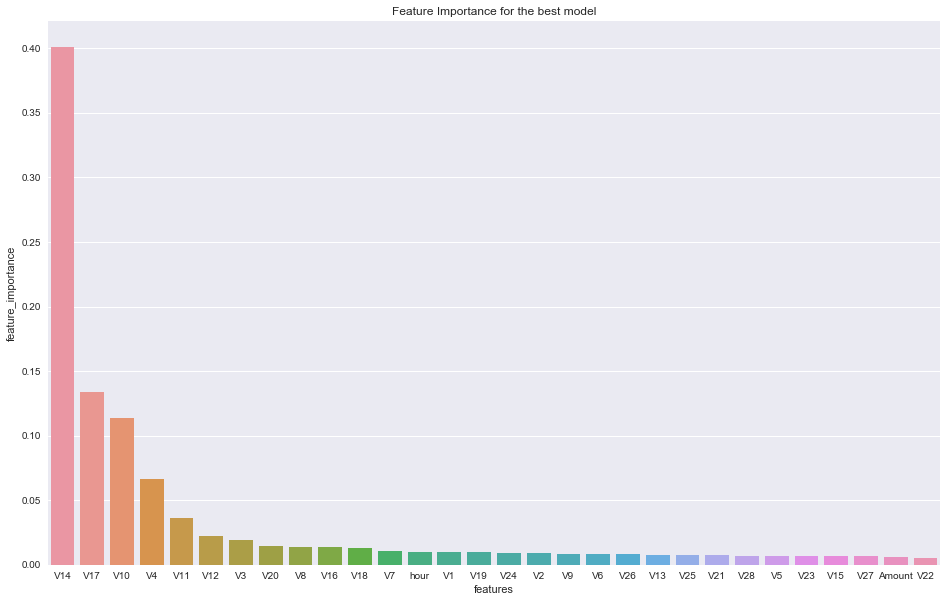

In [51]:
# plotting the feature importances

plt.figure(figsize = (16,10))
sns.barplot(x = 'features', y ='feature_importance', data = feat_imp)
plt.title('Feature Importance for the best model')
plt.show()

V14, V17 and V10 are the top features based on the best model

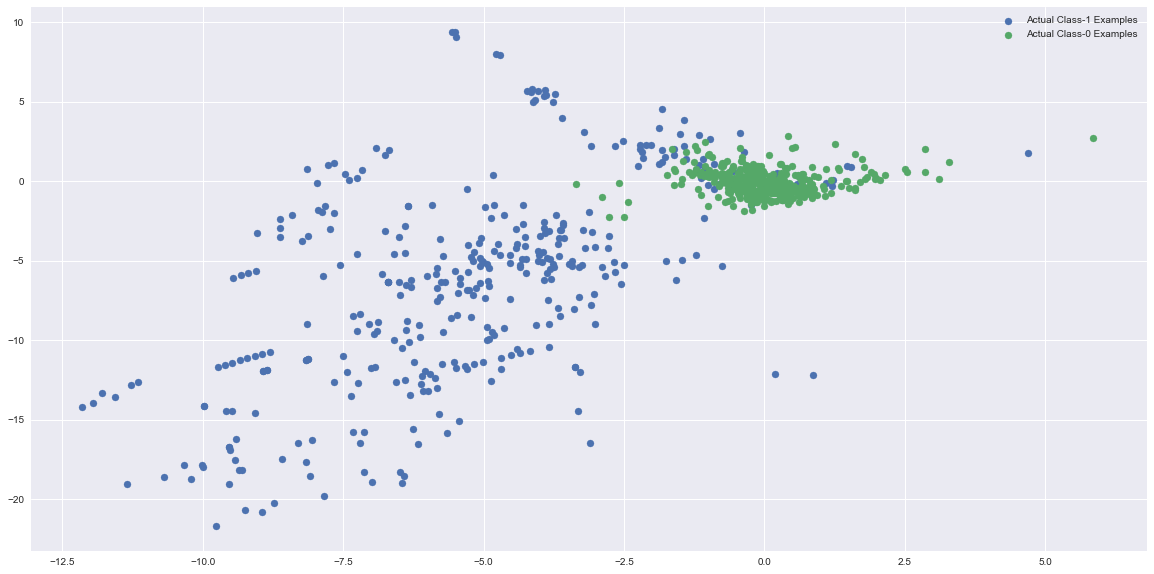

In [53]:
# creating a scatter plot based on top two variables (V14, V17)

# creating separate dataframes for fraud and normal
X_train_fraud = X_train_p[(y_train == 1).values]
X_train_normal = X_train_p[(y_train == 0).values]

X_train_normal = shuffle(X_train_normal)
X_train_normal = X_train_normal.iloc[:X_train_fraud.shape[0], :]

plt.figure(figsize = (20,10))
plt.scatter(X_train_fraud['V14'], X_train_fraud['V17'], label='Actual Class-1 Examples')
plt.scatter(X_train_normal['V14'], X_train_normal['V17'], label='Actual Class-0 Examples')
plt.legend()
plt.show()

You can see a clear boundary line. Most of fraudelent transactions have negative values for both `V14` and `V17`

#### Identifying the right threshold for the best model

##### Plotting roc-auc, pr curve and sensitivity vs specificity

In [54]:
#  Creating a function metrics_curve for drawing ROC_curve, precision recall curve and sensitivity specifity curve
def metrics_curves(y_train, X_train, model):  
    
    # plotting roc curve
    probs = np.array([x[-1] for x in model.predict_proba(X_train)])
    fpr, tpr, thresholds = roc_curve( y_train, probs)
    auc_score = roc_auc_score( y_train, probs )
    plt.figure(figsize=(10, 8))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # plotting sensitivity vs specificity 
    sens_spec = pd.DataFrame({'actual_pred':y_train, 'pred_probability':probs})
    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        sens_spec[i]= sens_spec['pred_probability'].map(lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    pre_recal = pd.DataFrame( columns = ['prob','accuracy','precision','recall'])

    for i in numbers:
        cm1 = metrics.confusion_matrix(sens_spec['actual_pred'], sens_spec[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        prec = cm1[1,1]/(cm1[0,1]+ cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
        pre_recal.loc[i] =[ i ,accuracy,prec,sensi] 
    
    pre_recal.plot.line(x='prob', y=['precision','recall'], figsize = (10,8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision vs Recall Trade-Off Curve')
    plt.show()
        
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi', 'speci'], figsize = (10,8))
    plt.title('Accuracy vs Sensitivity vs Specificity')
    plt.show()
    
    print(cutoff_df)

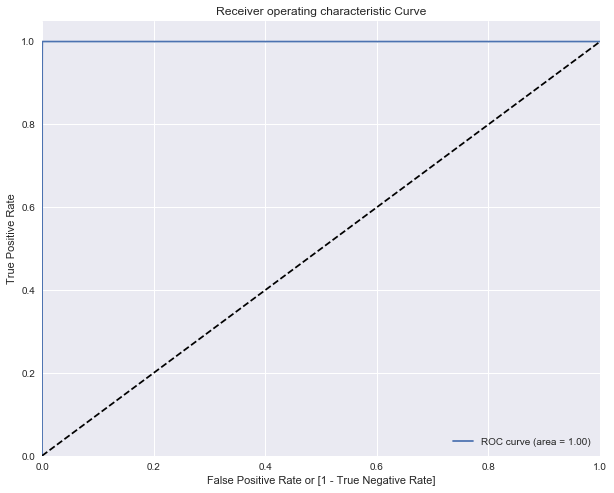

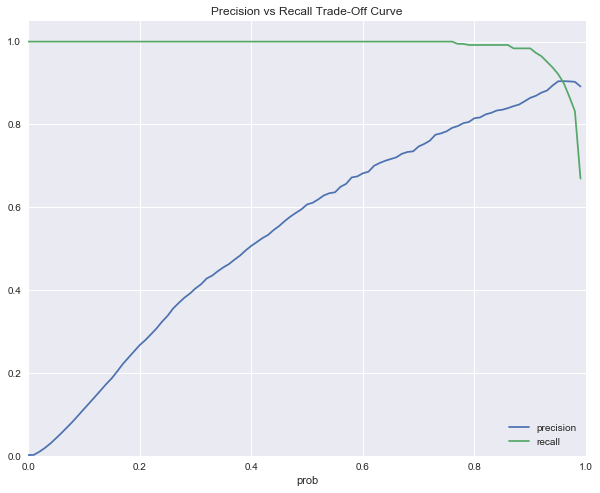

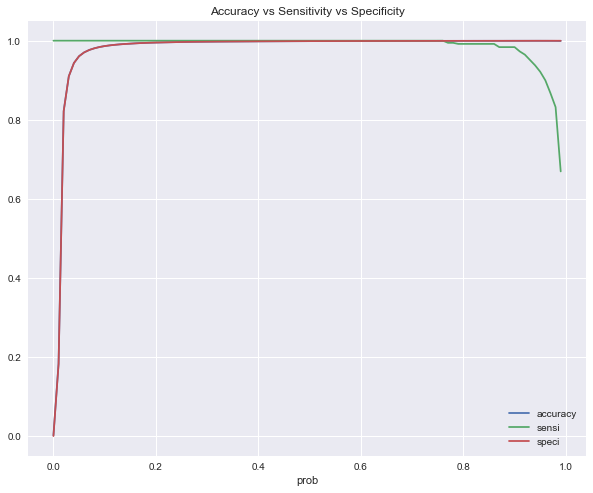

      prob  accuracy     sensi     speci
0.00  0.00  0.001727  1.000000  0.000000
0.01  0.01  0.183062  1.000000  0.181649
0.02  0.02  0.822102  1.000000  0.821794
0.03  0.03  0.910138  1.000000  0.909982
0.04  0.04  0.943573  1.000000  0.943476
...    ...       ...       ...       ...
0.95  0.95  0.999696  0.921409  0.999831
0.96  0.96  0.999663  0.899729  0.999836
0.97  0.97  0.999611  0.867209  0.999841
0.98  0.98  0.999555  0.831978  0.999845
0.99  0.99  0.999288  0.669377  0.999859

[100 rows x 4 columns]


In [55]:
# using the functions above to draw roc_auc curve, pr curve and sensitivity vs specificty for train_data
results_df = metrics_curves(y_train, X_train_p, xgb_pipeline_smote_final)

# Note For sensitivity vs specificity plot - accuracy is almost same as specificity thats why its not visible

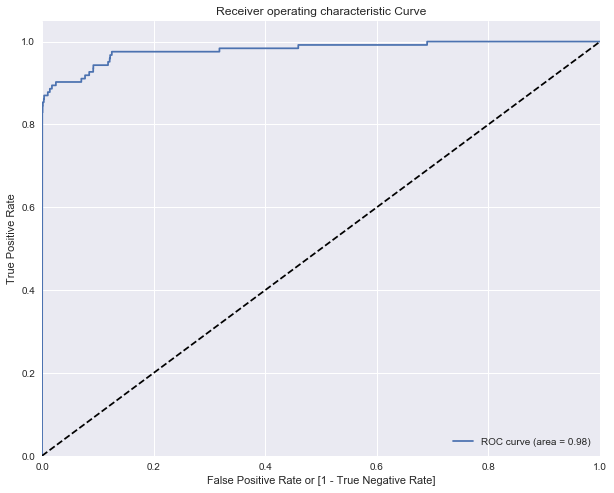

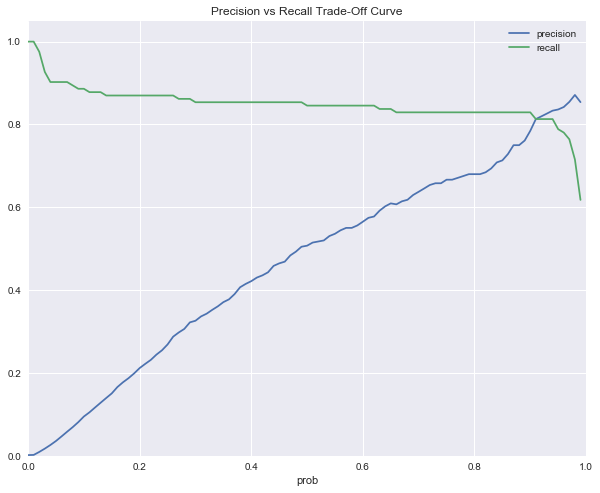

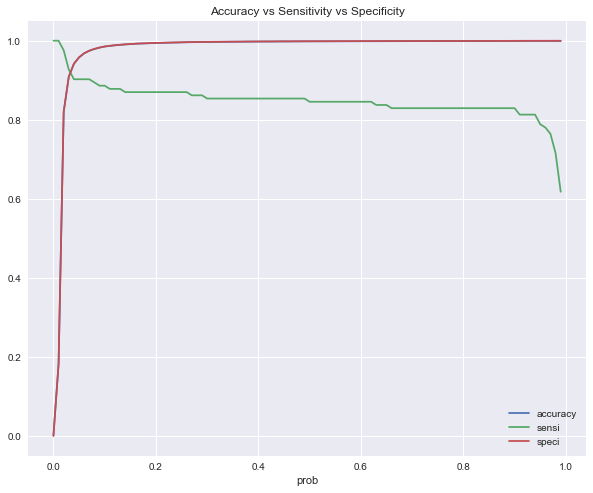

      prob  accuracy     sensi     speci
0.00  0.00  0.001727  1.000000  0.000000
0.01  0.01  0.182200  1.000000  0.180785
0.02  0.02  0.820244  0.975610  0.819975
0.03  0.03  0.909118  0.926829  0.909087
0.04  0.04  0.941673  0.902439  0.941741
...    ...       ...       ...       ...
0.95  0.95  0.999368  0.788618  0.999733
0.96  0.96  0.999368  0.780488  0.999747
0.97  0.97  0.999368  0.764228  0.999775
0.98  0.98  0.999326  0.715447  0.999817
0.99  0.99  0.999157  0.617886  0.999817

[100 rows x 4 columns]


In [56]:
# using the functions above to draw roc_auc curve, pr curve and sensitivity vs specificty for test_data
results_df = metrics_curves(y_test, X_test_p, xgb_pipeline_smote_final)
# Note For sensitivity vs specificity plot - accuracy is almost same as specificity thats why its not visible

##### Identifying the right thresholds using f1score, pr-curve and ks-statistic

In [57]:
# predicted train and test_prob using the best model
pred_train_prob = xgb_pipeline_smote_final.predict_proba(X_train_p)[:, 1]
pred_test_prob = xgb_pipeline_smote_final.predict_proba(X_test_p)[:, 1]

opt_thresh = pd.DataFrame({'best_threshold': [], 'basis': [], 'test_recall': [], 
              'test_precision': []})

In [58]:
# finding the optimum threshold based on max_f1 score
from sklearn.metrics import f1_score
f1scores = []
thresholds = np.arange(0, 1.01, 0.001)
for threshold in thresholds:
    y_threshold = [1 if x >= threshold else 0 for x in pred_train_prob]
    f1scores.append(f1_score(y_threshold,y_train))
    
# identifying best_threshold and best_f1score
best_threshold = thresholds[np.argmax(f1scores)]

y_test_pred = [1 if x >= best_threshold else 0 for x in pred_test_prob]

pr = metrics.precision_score(y_test,y_test_pred)
re = metrics.recall_score(y_test, y_test_pred)

opt_thresh.loc[0, :] = [round(best_threshold, 4), 'max_f1score', round(re,4), round(pr,4)]

In [59]:
# Checking the opt_thresh
opt_thresh

,best_threshold,basis,test_recall,test_precision
0,0.903,max_f1score,0.8293,0.7969


In [60]:
# finding the optimum threshold based on interesection point on pr-curve
thresholds = np.arange(0, 1.001, 0.001)
prec_recall_diff = []

for threshold in thresholds:
    # calcuting y_pred for the threshold
    y_threshold = [1 if x >= threshold else 0 for x in pred_train_prob]
    
    # calculating diff between precision and recall for identifying intersection point
    train_pr = metrics.precision_score(y_train,y_threshold)
    train_re = metrics.recall_score(y_train, y_threshold)
    prec_recall_diff.append(np.abs(train_pr-train_re))
    
# identifying best_threshold based on intersection
best_threshold = thresholds[np.argmin(prec_recall_diff)]

y_test_pred = [1 if x >= best_threshold else 0 for x in pred_test_prob]
pr = metrics.precision_score(y_test,y_test_pred)
re = metrics.recall_score(y_test, y_test_pred)

opt_thresh.loc[1, :] = [round(best_threshold,4), 'interesction pr curve', round(re,4), round(pr,4)]

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


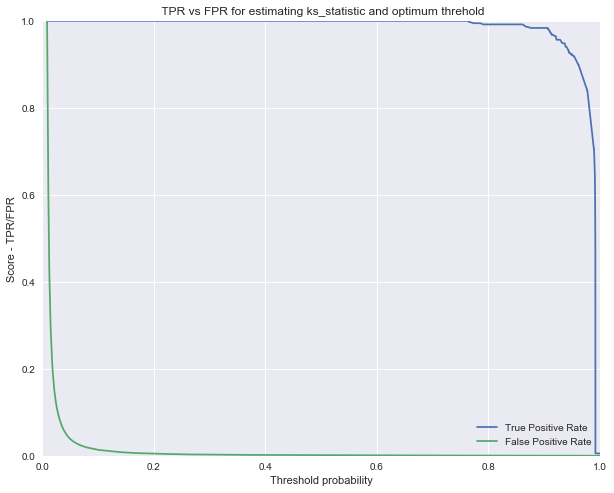

In [61]:
# finding the best threshold based on ks statistic

fpr, tpr, thresholds = roc_curve( y_train,pred_train_prob)

# plotting KS statistic curve for the test dataset
plt.figure(figsize = (10,8))
sns.lineplot( y= tpr, x = thresholds, label = 'True Positive Rate')
sns.lineplot(y = fpr, x = thresholds, label = 'False Positive Rate')
plt.title(' TPR vs FPR for estimating ks_statistic and optimum threhold')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Threshold probability')
plt.ylabel('Score - TPR/FPR')
plt.show()

# creating a dataframe for calculating ks statistic
ks_df = pd.DataFrame({'threshold':thresholds, 'fpr': fpr, 'tpr':tpr})

# calculating ks_statistic using tpr and fpr
ks_df['ks_statistic'] = ks_df['tpr'] - ks_df['fpr']
ks_df[ks_df['ks_statistic'] == ks_df['ks_statistic'].max()]

#calcuating the optimum threhold
best_threshold = ks_df[ks_df['ks_statistic'] == ks_df['ks_statistic'].max()]['threshold'].values[0]

y_test_pred = [1 if x >= best_threshold else 0 for x in pred_test_prob]
pr = metrics.precision_score(y_test,y_test_pred)
re = metrics.recall_score(y_test, y_test_pred)

opt_thresh.loc[2, :] = [round(best_threshold,4), 'ks statistic', round(re,4), round(pr,4)]

In [62]:
opt_thresh

,best_threshold,basis,test_recall,test_precision
0,0.9030,max_f1score,0.8293,0.7969
1,0.9570,interesction pr curve,0.7805,0.8348
2,0.7648,ks statistic,0.8293,0.6711


Based on the above three:
- max f1score offers the best recall on the test data while also not comprimising on precision
- **So selecting 0.903 as threshold probability**


##### Final Metrics based on optimum threshold

In [63]:
# predictions for the test dataset based on optimum threshold
best_threshold = 0.903
y_pred_opt = [1 if x >= best_threshold else 0 for x in pred_test_prob]

# printing confustion matrix and Classification report

print('The confusion matrix based on the optimum threshod is')
print(confusion_matrix(y_test,y_pred_opt))

print('The Classification report of the best model and optimum threshold is:')
print(classification_report(y_test, y_pred_opt))

The confusion matrix based on the optimum threshod is
[[71053    26]
 [   21   102]]
The Classification report of the best model and optimum threshold is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.80      0.83      0.81       123

    accuracy                           1.00     71202
   macro avg       0.90      0.91      0.91     71202
weighted avg       1.00      1.00      1.00     71202



### Cost Analysis for the model

Total savings for the cost analysis can be calculated using the formula:

Total Cost Savings  =  cost_savings_prediction - additional_call_cost

cost_savngs_prediction = (TP X Amount) - (FN X Amount)

additional_call_cost = (TP+FP) X Call_cost

Note: As the dataset is from European Countries. we are assuming the amount is in euros and using the conversion factor of 80 for converting it to INR

In [64]:
# calculating cost_savings_prediction 
fraud_pred = X_test.reset_index()[['index', 'Amount']]
fraud_pred['actual_class'] = y_test.values
fraud_pred['predicted_class'] = y_pred_opt

# For cost savings we are concentrating only on fraud transaction 
# Therefore filtering the transactions with actual frauds
fraud_pred = fraud_pred[fraud_pred['actual_class'] == 1]

# creating a multiplier (1 or -1) depending up on the actual class and predicted class
fraud_pred['cost_savings_multiplier'] = [1 if fraud_pred.iloc[i, 2] == fraud_pred.iloc[i,3] else -1 
                                         for i in range(len(fraud_pred))]

# multiplying amount and cost_savings_multiplier
fraud_pred['cost_savings'] = fraud_pred['cost_savings_multiplier']*fraud_pred['Amount']

# sum to get cost_savings_prediction
# using a conversion factor of Euro to INR
cost_savings_pred = fraud_pred['cost_savings'].sum()

print('The cost savings due to prediction are {} Rupees'.format(round(cost_savings_pred,2)))

The cost savings due to prediction are 4257.63 Rupees


In [65]:
# Calculating Additional costs due to calls for each prediction made by 
TP = confusion_matrix(y_test,y_pred_opt)[1][1]
FP = confusion_matrix(y_test, y_pred_opt)[0][1]
total_preds = TP+FP
additional_call_cost = (TP+FP)*10

print('The total additional_call_cost is {} Rupees'.format(additional_call_cost))

The total additional_call_cost is 1280 Rupees


In [66]:
total_cost_savings = cost_savings_pred - additional_call_cost

print('The total cost savings due to the model are {} Rupees'.format(round(total_cost_savings,2)))

The total cost savings due to the model are 2977.63 Rupees


*************

**End of Document**